
<h1><center><font color="blue"><b>Summary for the Sale predictions of the Ames Iowa dwellings.</b></font></center></h1>

    Two datasets are provided: 
        1) one with 2430 entries for training and validation
        2) one with 500 entries for testing (SalePrice is not given)

    In these datasets they are in total 79 features without the PID, Order and the target variable (SalePrice), separated as following: 

        - 19 continuous
        - 17 discrete
        - 23 nominal 
        - 20 ordinal

    In the first part of the notebook, each category of the features is examined separately and several tests, mentioned below, are performed. For these tests, the first dataset is split into 50-50 for training and validation and a ridge model is fit with the default alpha parameter (a=1). The model receives successively the different category of features as they are examined. 

    For all the tests, custom transformers, that work with pandas dataframes, were built in order to replace missing values, correct inconsistencies and add or process features. The tests performed for each feature category are summarized below. 


    For the continuous features:

        1) polynomial features with or without interactions up to 2nd degree
        2) transformations like log, power or quantiles either for all the continuous features or for those that were explored during EDA.
        3) 9 binary features like for e.g. has_Pool and Total Porch
        4) an outlier detector was also inserted during fitting which fits the training data without the outliers by checking specific features.

    For the discrete features:

        1) adding Date sold
        2) dummy processing for either the 10 features (except months and years) or dummy processing for only the MS SubClass feauture
        3) adding 2 indicator variables  for the dwellings (Recently Built and Recently Remodeled)

    For the nominal features the performance of the model was tested by processing:

        1) all features to dummies
        2) merging the Condition 1 and Condition 2 features before creating dummies
        3) merging the Exterior 1st and Exterior 2nd features before creating dummies
        4) merging both the Conditions and Exteriors before creating dummies

    For the ordinal features:

        - the encoding was performed on 16 features except: 'Fence', 'Utilities', 'Functional', and 'Paved Drive'. Because for those features their encoding was not very clear, they were converted to dummies 
        - no further steps were performed

    According to the results obtained from the above tests it was decided in the end to use only the following prepossessing steps (other than replacing nulls and correcting inconsistencies):

        1) add 2nd polynomial without interactions for 7 continuous features
        2) add log transformations for all the continuous features
        3) add the two indicator features
        4) merge Condition 1 & 2 and Exterior 1st & 2nd before creating the dummy variables for the nominal features
        5) ordinal encoding as discussed above

    The second part of the notebook contains the final step of the project were the 3 different models (complex, intermediate and simple) are tested. For these tests the first dataset is split into four different training and validation sets (80-20, 70-30, 60-40 and 50-50) with 10 different random seeds. 
        - For the complex and intermediate models, a Linear and a Ridge regressor are compared. For the Ridge regressor, a grid search is performed.
        - For the simple model, a Linear and a Huber regressor with and without fitting the outliers are compared. 

    Several attempts were also made to fit in addition a Lasso regressor with grid search but it was very difficult to converge it even by trying to increase the maximum number of iterations and switching on the warm_start flag. 

    For the intermediate and simple model, the SelectKBest method was used to select features. In the beginning, some trials were made to use the GridSearchCV in order to select the number of features (for the intermediate model) by checking the best MAE for the validation sets between the score functions f_regression and mutual_info_regression. Also this attempt was not successful as several problems were raised to run the algorithm as for e.g. RuntimeWarning: invalid value encountered in true_divide F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom. Another problem that was raised was when using the SelectKBest inside the pipeline after the preprocessing steps. This was very computational intensive and running for many hours. In order to speed up this procedure, the feature matrix is preprocessed first and then the SelectKBest with the f_regression score is used. The features selected in the different train-validation splits for 10 different random seeds are stored in a list and the unique values are extracted. A custom transformer that takes this list and returns the dataframe with only those features is then passed to the pipeline that runs the models. 

    In the end of the second part, the comparison between the different size models from the validation set is presented. Checking the predictions sanity and performance of the models built, the predictions on the unseen data are a bit higher than the results obtained from the validation set. In particular:

        - for the complex model, the test MAE is ~880$ higher than the validation MAE   
        
        - for the intermediate model, the MAE is ~550$ higher than the validation MAE 
        
        - for the simple model, the MAE is ~1460$  higher than the validation MAE

In [1]:
# Import Basic Libraries
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format

---
<h1><center><font color="blue"><b>PART 1</b></font></center></h1>


---
# <font color="blue">**A. General overview of the dataset**</font>
---

---
### **Load data into a dataframe and check the shape**
---

In [2]:
# Read data
data_df = pd.read_csv('house-prices.csv')

# Check the shape
print('Shape of the train-validation dataset:\n entries = ', data_df.shape[0], '\n features = ', data_df.shape[1] )

Shape of the train-validation dataset:
 entries =  2430 
 features =  82


---
### **A quick look on the data**
---

In [3]:
# Check how the dataframe looks like
data_df.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    484  528275070           60        RL           nan      8795   Pave   
1   2586  535305120           20        RL         75.00     10170   Pave   
2   2289  923228250          160        RM         21.00      2001   Pave   
3    142  535152150           20        RL         70.00     10552   Pave   
4   2042  903475060          190        RM         60.00     10120   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
2   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
3   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Bnk  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       4    2009       WD           Normal     236000  
1        0       6    2006       WD           Normal     155000  
2        0       1    2007       WD           Normal      75000  
3        0       4    2010       WD           Normal     165500  
4        0       1    2007       WD           Normal     122000  

[5 rows x 82 columns]

---
### **Get info from the dataset**
---

In [4]:
data_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2430 non-null   int64  
 1   PID              2430 non-null   int64  
 2   MS SubClass      2430 non-null   int64  
 3   MS Zoning        2430 non-null   object 
 4   Lot Frontage     2010 non-null   float64
 5   Lot Area         2430 non-null   int64  
 6   Street           2430 non-null   object 
 7   Alley            163 non-null    object 
 8   Lot Shape        2430 non-null   object 
 9   Land Contour     2430 non-null   object 
 10  Utilities        2430 non-null   object 
 11  Lot Config       2430 non-null   object 
 12  Land Slope       2430 non-null   object 
 13  Neighborhood     2430 non-null   object 
 14  Condition 1      2430 non-null   object 
 15  Condition 2      2430 non-null   object 
 16  Bldg Type        2430 non-null   object 
 17  House Style   

---
    From the above we see that we have:
        a) in total 82 variables separated in 43 categorical and 39 numerical.
            - numerical variables are either of type `int` or `float`. Float types are those variables with missing values. 
        b) variables with a lot of missing entries.
        c) inconsistencies in the name of some features with respect to the documentation. On this no renaming will be done. 
---

### **Check in details the missing variables**
---

In [5]:
# Function for calculating the percentage of nulls 
def calc_nulls(df):

    # Get from all columns the sum of NaN values and calculate the percentage of missing data
    nulls = df.isnull().sum()
    nulls_perc = nulls.apply(lambda x: (x*100/df.shape[0]))
    typeof = df.dtypes

    # Mask for null values
    mask = nulls>0

    # Create a dataframe with all the information
    df_nulls = pd.concat([nulls[mask], nulls_perc[mask], typeof[mask]], axis=1, keys=['Missing values', 'Percentage (%)', 'Type']).sort_values(by='Missing values', ascending=False)
    
    return df_nulls  

In [6]:
# Print the dataframe with the nulls
calc_nulls(data_df)

Missing values  Percentage (%)     Type
Pool QC                   2418           99.51   object
Misc Feature              2340           96.30   object
Alley                     2267           93.29   object
Fence                     1941           79.88   object
Fireplace Qu              1186           48.81   object
Lot Frontage               420           17.28  float64
Garage Cond                138            5.68   object
Garage Qual                138            5.68   object
Garage Finish              138            5.68   object
Garage Yr Blt              138            5.68  float64
Garage Type                136            5.60   object
Bsmt Exposure               74            3.05   object
BsmtFin Type 2              72            2.96   object
BsmtFin Type 1              71            2.92   object
Bsmt Qual                   71            2.92   object
Bsmt Cond                   71            2.92   object
Mas Vnr Area                20            0.82  float64
Mas Vnr Type                20            0.82   object
Bsmt Half Bath               2            0.08  float64
Bsmt Full Bath               2            0.08  float64
Total Bsmt SF                1            0.04  float64
Bsmt Unf SF                  1            0.04  float64
Garage Cars                  1            0.04  float64
Garage Area                  1            0.04  float64
BsmtFin SF 2                 1            0.04  float64
BsmtFin SF 1                 1            0.04  float64
Electrical                   1            0.04   object

---
### **Check for duplicates**
---

In [7]:
data_df.duplicated(subset='PID').value_counts()

False    2430
dtype: int64

---
    No duplicated values found based on the PID.
---

---
### **Check the target variable with different transformations**
---

In [8]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer


# Call to different transformers
pt1 = PowerTransformer(method='yeo-johnson', standardize=True)
pt2 = PowerTransformer(method='box-cox', standardize=True)
qt = QuantileTransformer(output_distribution='normal', random_state=0, copy=False)

# Define a dataframe with only the target var
df_target = pd.DataFrame(data=data_df, columns=['SalePrice'])

# Add transformations
df_target['SalePrice_pt1'] = pt1.fit_transform(df_target)
df_target['SalePrice_pt2'] = pt2.fit_transform(df_target[['SalePrice']])                      
df_target['SalePrice_quantile'] = qt.fit_transform(df_target[['SalePrice']])
df_target['SalePrice_log'] = np.log10(df_target[['SalePrice']])

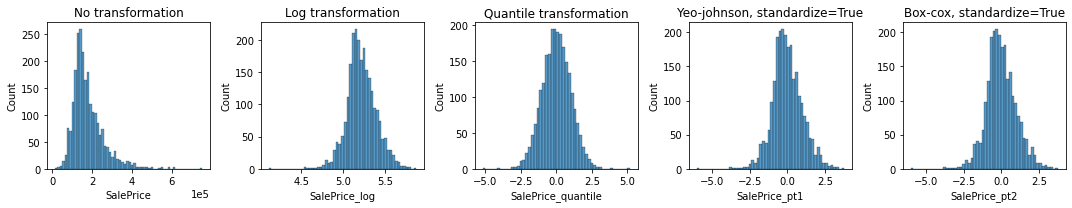

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,3))


sns.histplot(x=df_target['SalePrice'], ax = ax[0])
ax[0].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
ax[0].set_title('No transformation')

sns.histplot(x=df_target['SalePrice_log'], ax = ax[1])
ax[1].set_title('Log transformation')

sns.histplot(x=df_target['SalePrice_quantile'], ax = ax[2])
ax[2].set_title('Quantile transformation')

sns.histplot(x=df_target['SalePrice_pt1'], ax = ax[3])
ax[3].set_title('Yeo-johnson, standardize=True')

sns.histplot(x=df_target['SalePrice_pt2'], ax = ax[4])
ax[4].set_title('Box-cox, standardize=True')


plt.tight_layout()
plt.show()

---
    From the above transformations, we see that the quantile transformation gives a better Gaussian shape for the target variable.

---
### **Separate features according to documentation in continuous, descrete, nominal, ordinal**
---

In [10]:
cols_numerical = list(data_df.drop(['Order', 'PID', 'SalePrice'], axis=1).select_dtypes(include=[np.number]).columns.values)
cols_categorical =  list(data_df.select_dtypes('object').columns.values)

# Continuous
continuous = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
              '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF','Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 
              'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

# Descrete
descrete = data_df[cols_numerical].columns.difference(continuous).to_list()

# Nominal
nominal = ['MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood','Condition 1',
           'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd','Mas Vnr Type',
           'Foundation', 'Heating', 'Central Air','Electrical','Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition']     
                

# Ordinal
ordinal = data_df[cols_categorical].columns.difference(nominal).to_list()

# For printing output put all the above column types into a dictionary
columns_list={'Continuous': len(continuous),
              'Discrete': len(descrete),
              'Nominal':len(nominal),
              'Ordinal':len(ordinal),
              'Total': (len(continuous)+len(descrete)+len(nominal)+len(ordinal))}

columns_list = pd.Series(columns_list) # convert to pd.Series

print('Features (w/o Order, PID, SalePrice):')
print('------------------------------------')
print(columns_list.to_string()) # not interested in dtype; print only the relevant information

Features (w/o Order, PID, SalePrice):
------------------------------------
Continuous    19
Discrete      17
Nominal       23
Ordinal       20
Total         79


---
# <font color="blue">**B. Continuous Features**</font>
---

---
### **1. Descriptive Statistics**
---

In [11]:
# Get descriptive statistics
data_df[continuous].describe().T

count      mean      std      min      25%      50%  \
Lot Frontage    2,010.00     69.20    23.49    21.00    58.00    68.00   
Lot Area        2,430.00 10,243.56 8,353.93 1,470.00 7,482.00 9,500.00   
Mas Vnr Area    2,410.00    102.00   176.61     0.00     0.00     0.00   
BsmtFin SF 1    2,429.00    443.94   457.45     0.00     0.00   375.00   
BsmtFin SF 2    2,429.00     51.07   172.14     0.00     0.00     0.00   
Bsmt Unf SF     2,429.00    556.48   439.65     0.00   216.00   462.00   
Total Bsmt SF   2,429.00  1,051.50   444.69     0.00   794.00   990.00   
1st Flr SF      2,430.00  1,159.85   393.10   334.00   880.50 1,086.00   
2nd Flr SF      2,430.00    326.67   419.49     0.00     0.00     0.00   
Low Qual Fin SF 2,430.00      4.59    47.22     0.00     0.00     0.00   
Gr Liv Area     2,430.00  1,491.10   496.18   334.00 1,120.00 1,440.00   
Garage Area     2,429.00    471.98   215.75     0.00   324.00   478.00   
Wood Deck SF    2,430.00     93.92   128.11     0.00     0.00     0.00   
Open Porch SF   2,430.00     47.09    67.12     0.00     0.00    27.00   
Enclosed Porch  2,430.00     22.29    62.39     0.00     0.00     0.00   
3Ssn Porch      2,430.00      2.47    24.88     0.00     0.00     0.00   
Screen Porch    2,430.00     16.53    56.82     0.00     0.00     0.00   
Pool Area       2,430.00      2.40    36.11     0.00     0.00     0.00   
Misc Val        2,430.00     56.18   616.66     0.00     0.00     0.00   

                      75%        max  
Lot Frontage        80.00     313.00  
Lot Area        11,604.50 215,245.00  
Mas Vnr Area       164.75   1,600.00  
BsmtFin SF 1       737.00   5,644.00  
BsmtFin SF 2         0.00   1,526.00  
Bsmt Unf SF        799.00   2,336.00  
Total Bsmt SF    1,299.00   6,110.00  
1st Flr SF       1,387.75   5,095.00  
2nd Flr SF         698.00   2,065.00  
Low Qual Fin SF      0.00   1,064.00  
Gr Liv Area      1,740.00   5,642.00  
Garage Area        576.00   1,488.00  
Wood Deck SF       168.00   1,424.00  
Open Porch SF       70.00     742.00  
Enclosed Porch       0.00   1,012.00  
3Ssn Porch           0.00     508.00  
Screen Porch         0.00     490.00  
Pool Area            0.00     800.00  
Misc Val             0.00  17,000.00

---
    From the descriptive statistics we see that:
        a) The following 7 features have zero values up to the 75th percantile:
            - BsmtFin SF 2, Low Qual Fin SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Misc Val
            - the Misc Val according to the documentation is in dollars ($) 
        b) The following 3 features have zero values up to 50%:
            - Mas Vnr Area, 2nd Flr SF, Wood Deck SF
        c) there are only 4 features with a min value not zero:
            - Lot Frontage, Lot Area, 1st Flr SF, Gr Liv Area
        
---

---
### **2. Missing values**
---

In [12]:
# Check nulls
calc_nulls(data_df[continuous])

Missing values  Percentage (%)     Type
Lot Frontage              420           17.28  float64
Mas Vnr Area               20            0.82  float64
BsmtFin SF 1                1            0.04  float64
BsmtFin SF 2                1            0.04  float64
Bsmt Unf SF                 1            0.04  float64
Total Bsmt SF               1            0.04  float64
Garage Area                 1            0.04  float64

In [13]:
#### Create a mask for the Garage nulls to check if they belong to the same entry

mask = data_df['BsmtFin SF 1'].isnull() | data_df['BsmtFin SF 2'].isnull() | data_df['Bsmt Unf SF'].isnull() | data_df['Total Bsmt SF'].isnull() 
data_df.loc[mask, ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']]

BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF
104           nan           nan          nan            nan

---
    - The Lot Frontage nulls can be replaced with the mean or median since this feature represents the linear feet of the street connected to property which in principle is greater than zero.
    - The missing values in the rest features except can be replaced with zeros since it seems that there is no Basement, Garage Area and Mas Vnr Area. Those features have already a min value of zero. 
---

---
### **3. Distribution of features and correlation with the target**
---

In [14]:
# Create a dummy dataframe with the continuous features and the target variable
df_delme = data_df[continuous + ['SalePrice']].copy()

# Add some transformations
for col in df_delme.columns:
    df_delme[col+'_log'] = np.log1p(df_delme[[col]])
    df_delme[col+'_pt'] = pt1.fit_transform(df_delme[[col]])
    df_delme[col+ '_quantile'] = qt.fit_transform(df_delme[[col]]) 

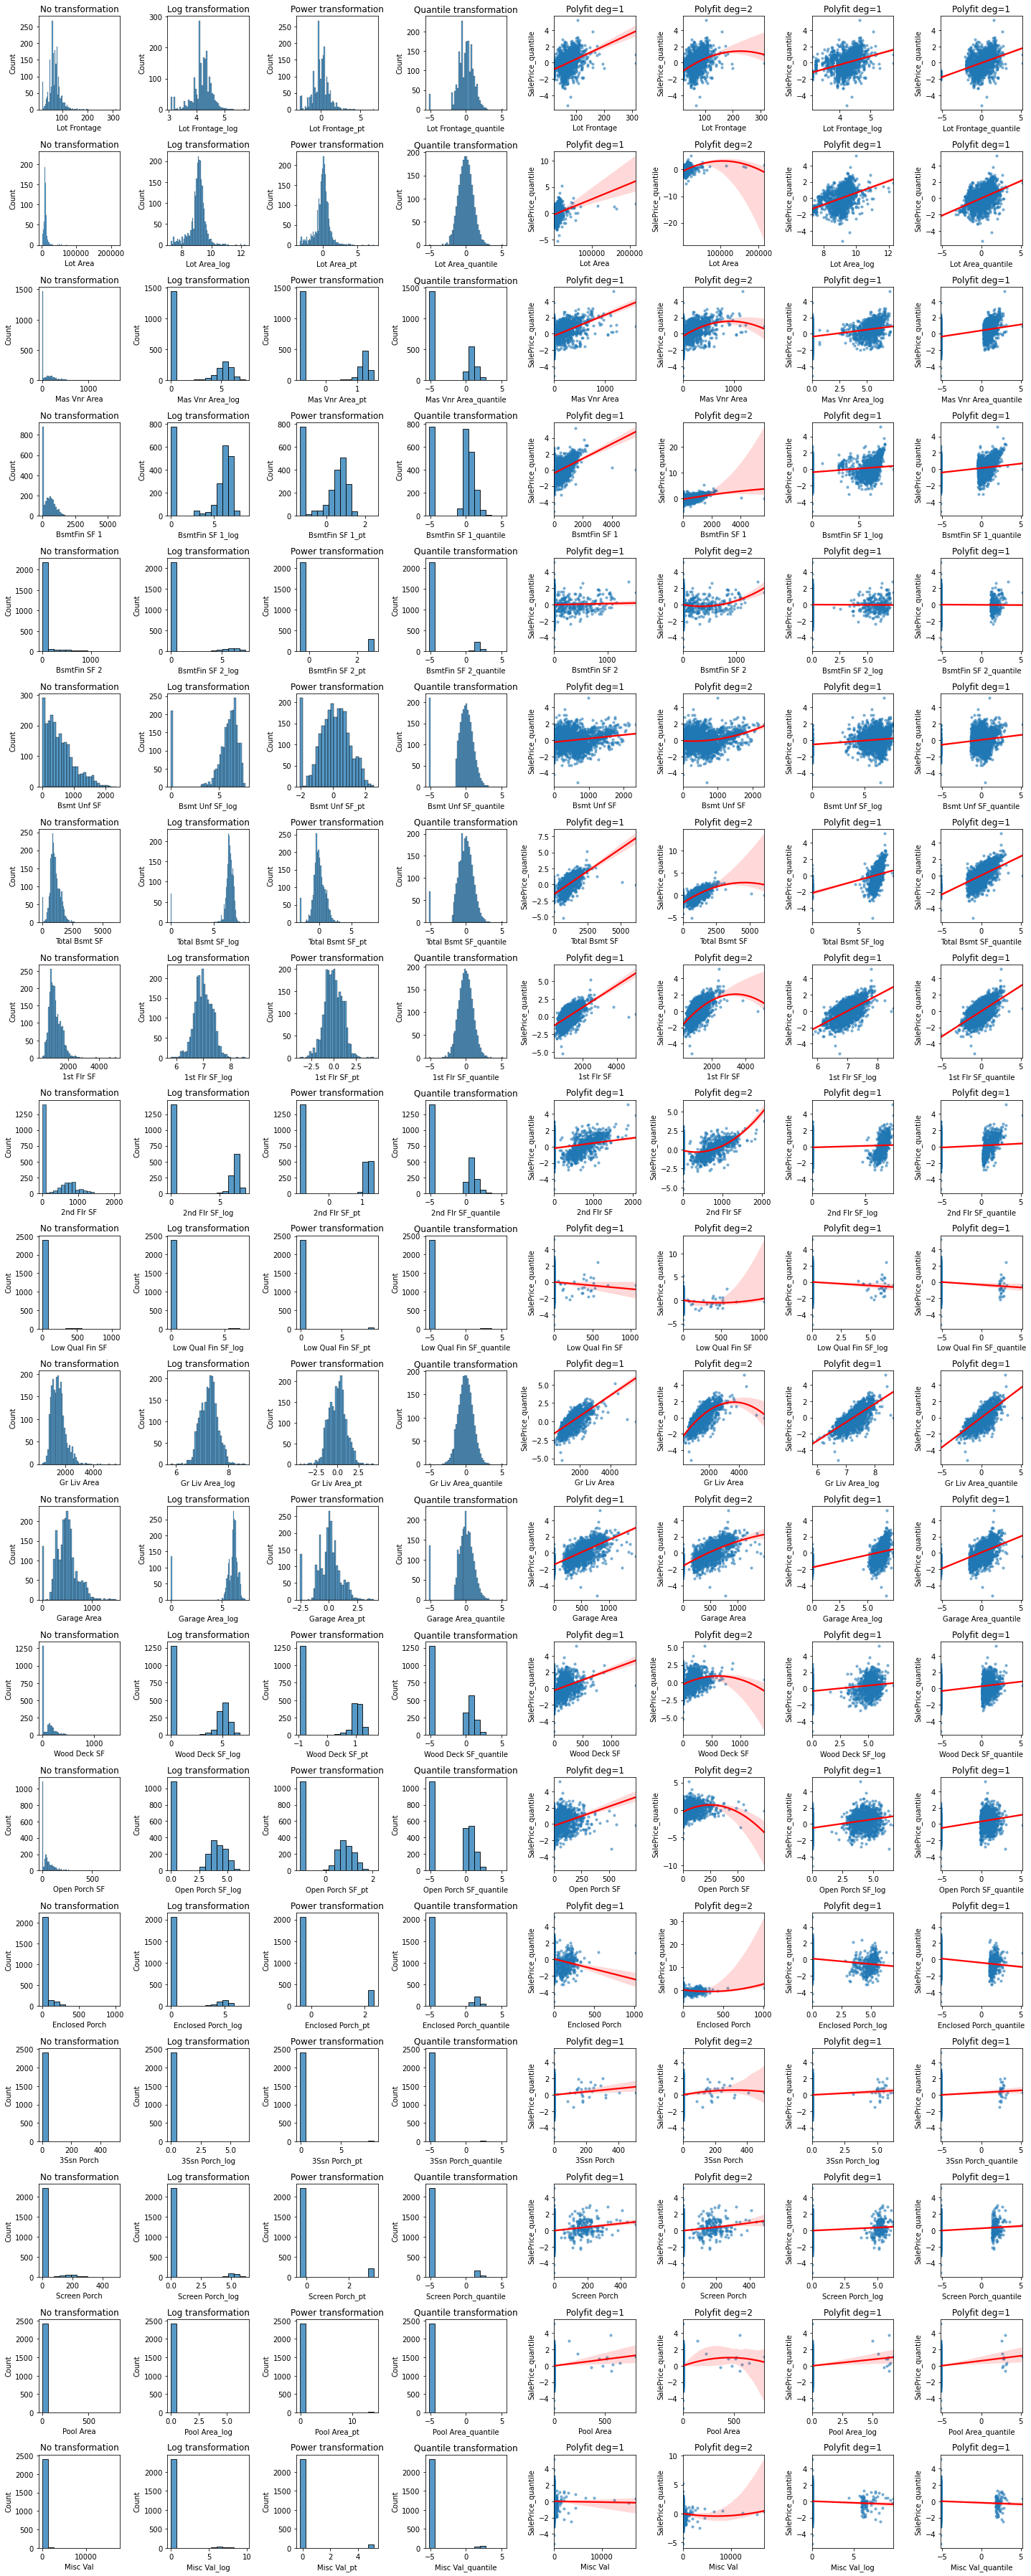

In [15]:
# Plot the distributions and correlations
fig, ax = plt.subplots(nrows=len(continuous), ncols=8, figsize=(20, 50))

for row in range(0,len(continuous)):
    
    col = continuous[row]
    
    sns.histplot(df_delme[col], ax=ax[row,0])
    ax[row,0].set_xlabel(col)
    ax[row,0].set_title('No transformation')
    
    sns.histplot(df_delme[col+'_log'], ax=ax[row,1])
    ax[row,1].set_title('Log transformation')
    
    sns.histplot(df_delme[col+'_pt'], ax=ax[row,2])
    ax[row,2].set_title('Power transformation')    
    
    sns.histplot(df_delme[col+'_quantile'], ax=ax[row,3])
    ax[row,3].set_title('Quantile transformation')      
    
    sns.regplot(x=df_delme[col], y=df_delme['SalePrice_quantile'], scatter_kws={"s": 10, 'alpha':0.5}, line_kws={'color': 'red'}, ax=ax[row,4])
    ax[row,4].set_title('Polyfit deg=1')
    
    sns.regplot(x=df_delme[col], y=df_delme['SalePrice_quantile'], scatter_kws={"s": 10, 'alpha':0.5}, line_kws={'color': 'red'}, order=2, ax=ax[row,5])
    ax[row,5].set_title('Polyfit deg=2')    
    
    sns.regplot(x=df_delme[col+'_log'], y=df_delme['SalePrice_quantile'], scatter_kws={"s": 10, 'alpha':0.5}, line_kws={'color': 'red'}, ax=ax[row,6])
    ax[row,6].set_title('Polyfit deg=1')    
    
    sns.regplot(x=df_delme[col+'_quantile'], y=df_delme['SalePrice_quantile'], scatter_kws={"s": 10, 'alpha':0.5}, line_kws={'color': 'red'}, ax=ax[row,7])
    ax[row,7].set_title('Polyfit deg=1')        
    
plt.tight_layout()
plt.show()    

---
    As mentioned above, the following features have many zeros:
       * Mas Vnr Area
       * BsmFin SF1 and SF2, Bsm Unf
       * 2nd Floor
       * Low Qual Fin
       * Wood deck
       * Porch features
       * Pool Area
       * Misc Value

    Concerning transformations: 

       * The quantile transformer for the Lot Frontage, Gr Liv Area and 1st Floor gives nice Gaussian distributions. For the Total Bsmt SF and Bsmt Unf SF the transformation looks also ok but due to the many zero values the distribution on the left side of the gaussian is cut. 
       * For the rest of the features, due to the many zeros is very hard to understand from those plots their distribution and their transformations. Below those features are plotted in log y-scale in order to understand better. 
       
    Concerning polynomial features is not easy to have a clear idea as the continuous features are in total 19. In the above figures, each feature is plotted independenly as a function of the Saleprice and from those plots it seems that only for the features:
    - Bsmt Fin SF 2
    - Bsmt Unf SF,
    - Garage Area
    - Enclosed Porch 
    it would probably make sense to add polynomial features up to 2nd degree but this will be tested better below. 
---

#### **4.1 Plot of distributions and  their transformation in log y-scale.**
---

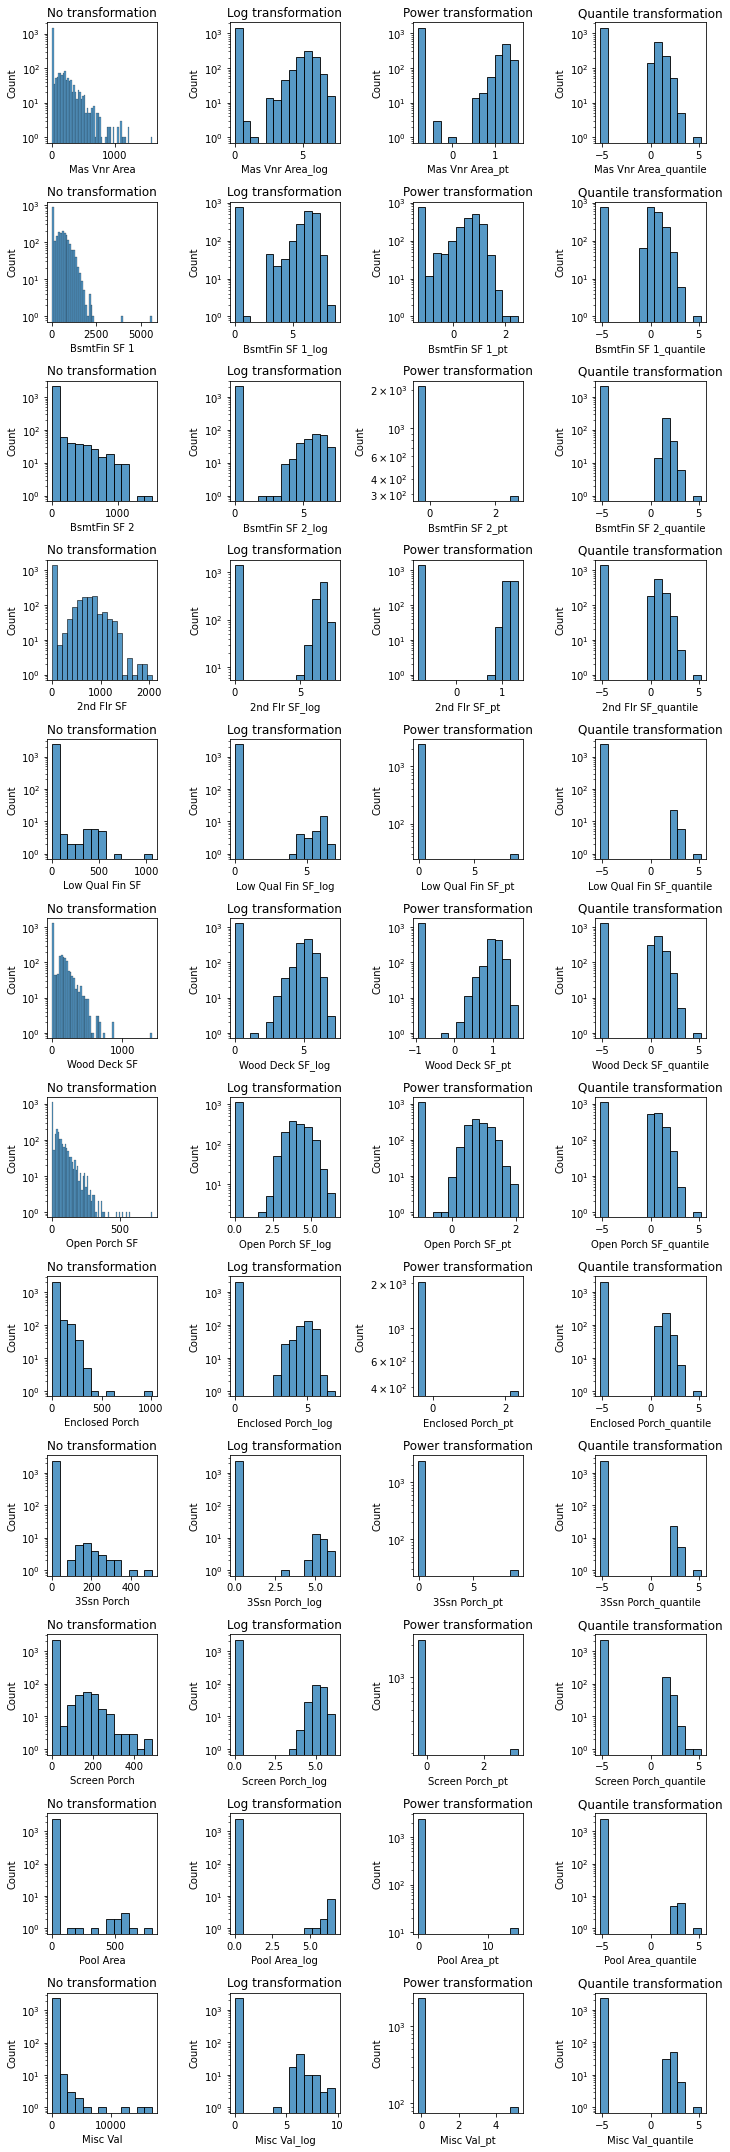

In [16]:
to_drop = ['Lot Frontage','Lot Area', 'Total Bsmt SF', 'Bsmt Unf SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area']
new_continous_list = [col for col in continuous if col not in to_drop]

fig, ax = plt.subplots(nrows=len(new_continous_list), ncols=4, figsize=(10, 30))

for row in range(0,len(new_continous_list)):
    
    col = new_continous_list[row]
    
    sns.histplot(df_delme[col], ax=ax[row,0])
    ax[row,0].set_xlabel(col)
    ax[row,0].set_title('No transformation')
    ax[row,0].set_yscale('log')
    
    sns.histplot(df_delme[col+'_log'], ax=ax[row,1])
    ax[row,1].set_title('Log transformation')
    ax[row,1].set_yscale('log')
    
    sns.histplot(df_delme[col+'_pt'], ax=ax[row,2])
    ax[row,2].set_title('Power transformation') 
    ax[row,2].set_yscale('log')      
    
    sns.histplot(df_delme[col+'_quantile'], ax=ax[row,3])
    ax[row,3].set_title('Quantile transformation') 
    ax[row,3].set_yscale('log')
    
plt.tight_layout()
plt.show()   

---
    Again we see that is not very clean which transformations will give best results. For this reason several combinations will be tested.
---

---
### **3. Check if some features are correlated**
---

#### **3.1 Basement Features**
---

MAE = 0.00


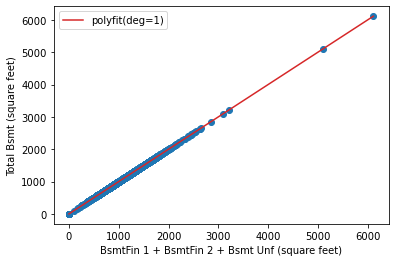

In [17]:
def MAE(y, y_predict):
    return np.mean(np.abs(y-y_predict))

components_bsm = data_df['BsmtFin SF 1'].dropna() + data_df['BsmtFin SF 2'].dropna() + data_df['Bsmt Unf SF'].dropna()

x = components_bsm.values
y = data_df['Total Bsmt SF'].dropna().values

# Fit a linear regression of degree 1
coefs = np.polyfit(x, y, deg=1)

# Generate x_values for the fit
x_values = np.linspace(x.min(), x.max(), 100)

# Evaluate y values for the fit
y_values = np.polyval(coefs, x_values)

# Predict y values
y_predict = np.polyval(coefs, x)

print('MAE = {:.2f}'.format(MAE(y,y_predict)) )

plt.scatter(x, y)
plt.plot(x_values, y_values, c='C3', label='polyfit(deg=1)')
plt.xlabel('BsmtFin 1 + BsmtFin 2 + Bsmt Unf (square feet)')
plt.ylabel('Total Bsmt (square feet)')
plt.legend()
plt.show()

---
    There is an exact linear relation of the Total Bsmt with the features BsmtFin 1 + BsmtFin 2 + Bsmt Unf
---

---
#### **3.2 Gr Liv Area with 1st, 2nd Floor and Low Qual Fin**
---

MAE = 0.00


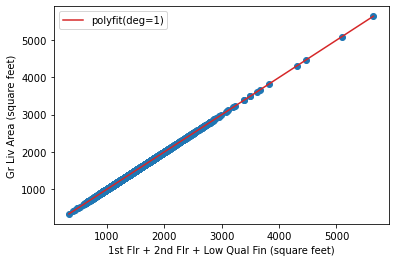

In [18]:
components_liv_area = data_df['1st Flr SF'] + data_df['2nd Flr SF'] + data_df['Low Qual Fin SF']

x = components_liv_area.values
y = data_df['Gr Liv Area'].values

# Fit a linear regression of degree 1
coefs = np.polyfit(x, y, deg=1)

# Generate x_values for the fit
x_values = np.linspace(x.min(), x.max(), 100)

# Evaluate y values for the fit
y_values = np.polyval(coefs, x_values)

# Predict y values
y_predict = np.polyval(coefs, x)

print('MAE = {:.2f}'.format(MAE(y,y_predict)) )

plt.scatter(x, y)
plt.plot(x_values, y_values, c='C3', label='polyfit(deg=1)')
plt.xlabel('1st Flr + 2nd Flr + Low Qual Fin (square feet)')
plt.ylabel('Gr Liv Area (square feet)')
plt.legend()
plt.show()

---
    There is also an exact linear relation of the Gr Liv Area with the features 1st Flr + 2nd Flr + Low Qual Fin
---    

---
### **4. Check outliers**
---

    In the documentation is written that a plot of the SALE PRICE versus GR LIV AREA will indicate quickly that there are 5 observations that can be removed. Three of them are true outliers (Partial Sales that likely don't represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). 
---    

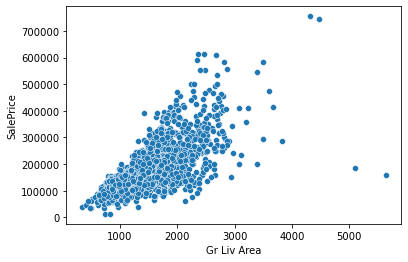

In [19]:
# Check Gr Liv Area as a function of the SalePrice
sns.scatterplot(x=data_df['Gr Liv Area'], y=data_df['SalePrice'])
plt.show()

---
    On this dataset it seems that the very abnormal datapoints are in total 4.
---    

#### **4.1 Check outliers with a simple function and combination of different features.**

    The same logic is also implemented in the detector outlier class used afterwards.
---

In [20]:
# Function to mask outliers
def remove_outliers(x, threshold):
    idx = (x-x.mean())/x.std()
    mask = np.abs(idx)> threshold

    return mask

Outliers detected: 9 , 0.37%


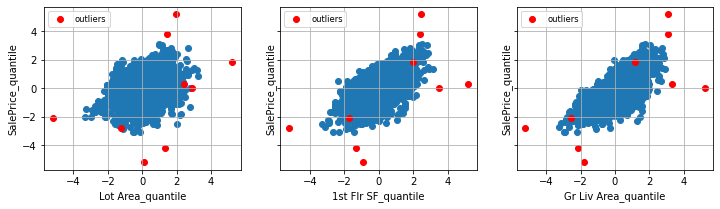

In [21]:
# Take the columns with the quantile transformation
quant_cols = [col for col in df_delme.columns.to_list() if col.endswith('_quantile')]

# Create a dummy dataframe to check
df_quants = df_delme[quant_cols].copy()
df_quants = df_quants.fillna(0)

idx1 = remove_outliers(df_delme['SalePrice_quantile'], 3.5)
idx2 = remove_outliers(df_delme['Lot Area_quantile'], 3.5)
idx3 = remove_outliers(df_delme['1st Flr SF_quantile'], 3.5)
idx4 = remove_outliers(df_delme['Gr Liv Area_quantile'], 3.5)

idx =  idx1 | idx2 | idx3 | idx4

outliers = idx.value_counts()[1]*100/df_quants.shape[0]

print('Outliers detected:', idx.value_counts()[1], ', {:,.2f}%'.format(outliers))

# Plot
cols = ['Lot Area_quantile', '1st Flr SF_quantile', 'Gr Liv Area_quantile']

fig, ax = plt.subplots(nrows=1, ncols=len(cols), figsize=(12,3), sharey=True)

for i in range(0, len(cols)):

    ax[i].scatter(df_delme.loc[~idx,cols[i]], df_delme.loc[~idx,'SalePrice_quantile'])
    ax[i].scatter(df_delme.loc[idx,cols[i]], df_delme.loc[idx,'SalePrice_quantile'], c='red', label='outliers')    
    ax[i].set_xlabel(cols[i])  
    ax[i].set_ylabel('SalePrice_quantile') 
    ax[i].grid()
    ax[i].legend(loc='upper left', shadow=False, fontsize='small')
    
plt.show()

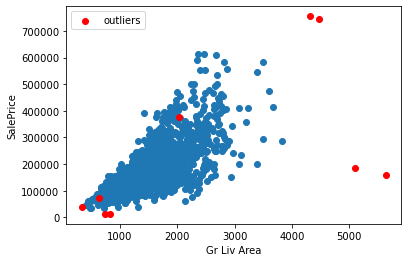

In [22]:
plt.scatter(x=df_delme.loc[~idx,'Gr Liv Area'], y=df_delme.loc[~idx,'SalePrice'])
plt.scatter(x=df_delme.loc[idx,'Gr Liv Area'], y=df_delme.loc[idx,'SalePrice'], c='red', label='outliers')
plt.xlabel('Gr Liv Area')
plt.ylabel('SalePrice')
plt.legend(loc='upper left')
plt.show()

---
#### **4.2 Custom estimator with SKlearn to check features and target variable**

    This estimator works only with dataframes. The same class is adapted to work with numpy arrays and is used later on this notebook in the Experimenation section.
---

In [23]:
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom outliers detector base on z-scores
# Adapted from https://github.com/scikit-learn/scikit-learn/issues/9630#issuecomment-325202441
class ZScoresOutlierClassifier(BaseEstimator, ClassifierMixin):
    '''
    Outliers are marked if:
        - all the features provided in the 'columns' for checking
        - OR the target variable
    have a z score above a certain threshold
    
    This function works only with dataframes and is for testing since it replaces the missing values on the columns given with zero. 
    '''
    
    def __init__(self, columns, threshold=3):
        self.columns = columns
        self.threshold = threshold

    def fit(self, X_df, y):
        # Check that X_df is a DataFrame
        assert type(X_df) == pd.DataFrame

        # Compute train mean/std for features
        self.train_mean_ = X_df[self.columns].mean()
        self.train_std_ = X_df[self.columns].std()
        
        # Compute train mean/std for the target
        self.ytrain_mean_ = y.mean()
        self.ytrain_std_ = y.std()  
        
        # pass it for reference to predict
        self.y = y

        # Return estimator
        return self

    def predict(self, X_df):
        # Check that X_df is a DataFrame
        assert type(X_df) == pd.DataFrame

        # Apply threshold
        z_scores = (X[self.columns] - self.train_mean_) / (self.train_std_)
        z_scoresy = (self.y - self.ytrain_mean_) / (self.ytrain_std_)
        
        below_threshold = np.abs(z_scores.fillna(0)) > self.threshold
        below_thresholdy = np.abs(z_scoresy) > self.threshold
        
        # Find ouliers
        mask = below_threshold.any(axis=1) | below_thresholdy

        # Return predictions: +1 for outliers, -1 for inliners
        return mask.replace({True: 1, False: -1})

---
#### **Check if custom estimator works the same as the simple function**
---

In [24]:
X = df_quants.drop('SalePrice_quantile', axis=1)
y = df_quants.SalePrice_quantile

# Define columns to check
to_check = ['Lot Area_quantile', '1st Flr SF_quantile', 'Gr Liv Area_quantile']

# Call the ZScoresOutlierClassifier and check how many ones it found
outliers_clf = ZScoresOutlierClassifier(to_check, threshold=3.5)
outliers_clf.fit(X, y)
mask_outliers = outliers_clf.predict(X)
mask_outliers.value_counts()


-1    2421
 1       9
dtype: int64

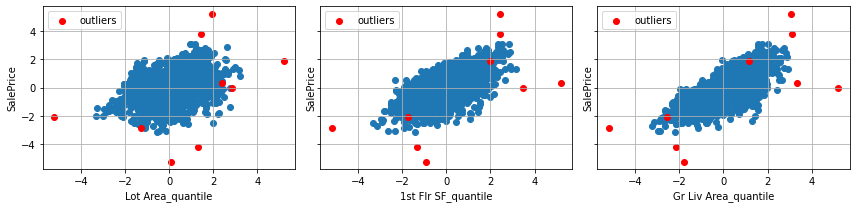

In [25]:
# Plot the outliers
fig, ax = plt.subplots(nrows=1, ncols=len(to_check), figsize=(12,3), sharey=True)

for i in range(0, len(to_check)):
   
    ax[i].scatter(X.loc[mask_outliers==-1,to_check[i]], y.loc[mask_outliers==-1])
    ax[i].scatter(X.loc[mask_outliers==1,to_check[i]], y.loc[mask_outliers==1], c='red', label='outliers')    
    ax[i].set_xlabel(to_check[i])
    ax[i].set_ylabel('SalePrice')
    ax[i].grid()
    ax[i].legend(loc='upper left', shadow=False, fontsize='medium')
     

plt.tight_layout()    
plt.show()


---
    We found the same number of outliers as before. This class works the same as the simple function. 
---

---
### **5. Check binary features**
---

In [26]:
# Create the binary features
df_delme['has_MasVnrArea'] = df_delme['Mas Vnr Area'].apply(lambda x: 1 if x > 0 else 0)
df_delme['has_Basement']  = df_delme['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
df_delme['has_2ndFloor'] = df_delme['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)
df_delme['has_Garage'] = df_delme['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
df_delme['has_Pool'] = df_delme['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
df_delme['has_WoodDeck'] = df_delme['Wood Deck SF'].apply(lambda x: 1 if x > 0 else 0)
df_delme['has_Porch'] = (df_delme['Open Porch SF'] |  
                         df_delme['Enclosed Porch'] | 
                         df_delme['3Ssn Porch'] |
                         df_delme['Screen Porch']).apply(lambda x: 1 if x > 0 else 0)
df_delme['has_MiscVal'] = df_delme['Misc Val'].apply(lambda x: 1 if x > 0 else 0)
df_delme['has_LowQualFinSF'] = df_delme['Low Qual Fin SF'].apply(lambda x: 1 if x > 0 else 0)

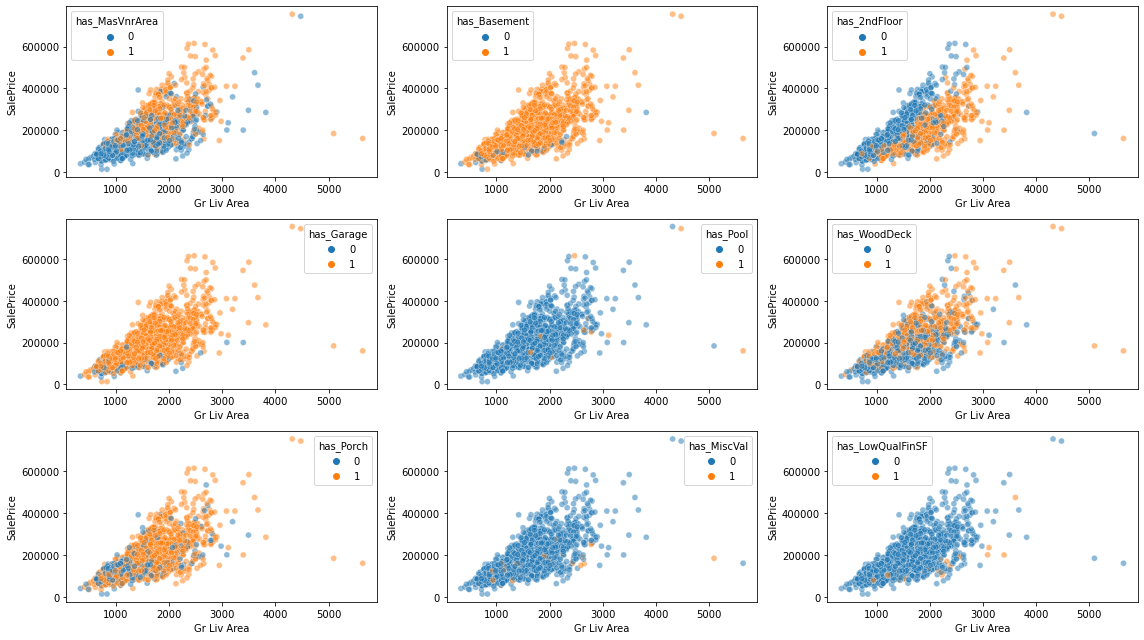

In [27]:
# Create a list with only the binary features to pass it in the hue
cols_bin = [col for col in df_delme if col.startswith('has')]

# Plot the 9 features created
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 9))

i=0
for row in range(3):
    for col in range(3):
        sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=df_delme, hue=cols_bin[i], ax=ax[row,col], alpha=0.5)
        i=i+1

plt.tight_layout()    
plt.show()      

---
    From the binary features those that probably would add some value to the model are the following:
        - has_MasVnrArea
        - has_2ndFloor
        - has_WoodDeck
---

---
## **6. Experimentation**
---

### **Define a Cleaning Preprocessor for the continuous variables**
---

In [1]:
from sklearn.base import TransformerMixin, BaseEstimator

class CleaningPreprocessorContVars(BaseEstimator, TransformerMixin):
    '''
    This class cleans only the features below...No possibility to add extra features..Not needed...
    A function to return the name of the feautures is provided in the end. 
    Is helpful to check the model coefficients wrt to a given feature. 
    '''
    
    def __init__(self):
        self.columns = []
        self.cont_vars_for_zero_ = ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Area']
        self.cont_vars_for_mean_  = ['Lot Frontage']
        
    # Function to replace nulls in continuous variables    
    def preprocess_f(self, X_df, train_mean):
        # Work on a copy
        X_df = X_df.copy()

        # Missing values to be filled with zero
        for c in self.cont_vars_for_zero_:
            if c in X_df.columns:
                X_df[c] = X_df[c].fillna(0)
        
        # Missing values to be filled with the mean
        for c in self.cont_vars_for_mean_:
            if c in X_df.columns:
                X_df[c] = X_df[c].fillna(train_mean[c])      

        return X_df
        

    def fit(self, X_df, y=None):

        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Save train mean for continuous variables
        self.train_mean_ = X_df[self.cont_vars_for_mean_].mean()

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_mean_)

        # Save columns names/order for inference time
        self.columns_ = X_preprocessed.columns

        return self  

    def transform(self, X_df):

        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_mean_)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns_, fill_value=0)
        
        # Update columns
        self.columns = X_reindexed.columns

        return X_reindexed
    
    # Needed to get the name of the features out to compare the coefficients
    def get_features_name(self):        
        return self.columns    

---
### **Define a method for splitting data into train and test sets, calculate metrics and plot predictions**
---

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

def fit_pipe(X,y, pipe, verbose=False):
        
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)
    
    # Fit the model
    if verbose==True:
        pipe.fit(X_tr, y_tr, verbose=True)
    else:
        pipe.fit(X_tr, y_tr)
        
    # Evaluate predictions on test and training data
    y_pred_te = pipe.predict(X_te)
    y_pred_tr = pipe.predict(X_tr)
    
    # Calculate baseline
    pred_baseline = np.full_like(y_tr, fill_value=np.median(y_tr), dtype=np.float)
    
    # Calculate MAE and R2
    baseline_mae = MAE(y_tr, pred_baseline)
    train_mae = MAE(y_tr, y_pred_tr)
    test_mae = MAE(y_te, y_pred_te)
    train_mse = MSE(y_tr, y_pred_tr, squared=False)
    test_mse = MSE(y_te, y_pred_te, squared=False)    
    train_r2 = pipe.score(X_tr, y_tr)
    test_r2 = pipe.score(X_te, y_te)   
        
    # Append results to a dictionary
    gs_results = []
    gs_results.append({
        'test_size': 50,
        'baseline_mae ($)': baseline_mae,
        'train_mae ($)': train_mae,
        #'train_rmse': train_mse,
        'test_mae ($)': test_mae,
        #'test_rmse': test_mse,
        'train_R2': train_r2,
        'test_R2': test_r2,
    })
    
    # Make the dictionary a pandas dataframe to display the results nice
    pd.options.display.float_format = '{:,.2f}'.format
    gs_results = pd.DataFrame(gs_results)     
    display(gs_results)
    
    #### Plot predictions 
    # adapted from:https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
    fig, ax = plt.subplots(1,3, figsize=(14,4))
    string_score = f"Train MAE: {train_mae:.0f} $"
    string_score += f"\nTest MAE: {test_mae:.0f} $" 
    
    ax[0].scatter(y_te, y_pred_te, s=12, alpha=0.5)
    ax[0].plot([y_te.min(), y_pred_te.max()], [y_te.min(), y_pred_te.max()], '--r', linewidth=2)
    ax[0].set_ylabel('Model Predictions', fontsize=13)
    ax[0].set_xlabel('True target', fontsize=13)   
    #ax[0].text(y_te.max()/1.3, y_pred_te.min()*1.2, string_score)
    ax[0].text(0.95, 0.01, string_score,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax[0].transAxes,
            fontsize=14)  
    ax[0].set_title('True target vs Predictions', fontsize='x-large', x=0.5, y=1.05)
    ax[0].ticklabel_format(axis='both', style='sci',  scilimits=(0,0))
    
    ax[1].scatter(y_te, y_te-y_pred_te, s=12, alpha=0.5)
    ax[1].plot([y_te.min(), y_te.max()], [0, 0], '--r', linewidth=2)
    ax[1].set_ylabel('Residuals', fontsize=13)
    ax[1].set_xlabel('True target', fontsize=13)
    #ax[1].text(y_te.min()/1.3, (y_te-y_pred_te)*1.2, string_score)
    ax[1].set_title('True target vs Residuals', fontsize='x-large', x=0.5, y=1.05)
    ax[1].ticklabel_format(axis='both', style='sci',  scilimits=(0,0))
    
    sns.histplot(y_te-y_pred_te, ax=ax[2])
    ax[2].set_xlabel('True target - Model predictions', fontsize=13)
    ax[2].set_title('Residuals', fontsize='x-large', x=0.5, y=1.05)
    ax[2].ticklabel_format(axis='x', style='sci',  scilimits=(0,0))    
    
    
    plt.tight_layout()
    plt.show()   
    
    return gs_results   

---
### **6.1. Test a Ridge model with y untranformed**

    -> Used as a reference
---

test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      28,001.79     27,937.28      0.77     0.62

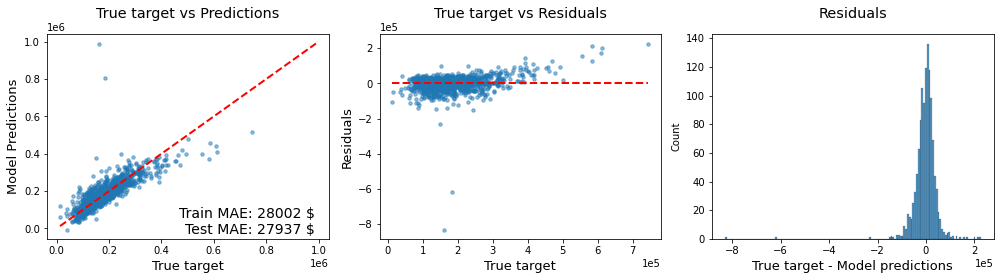

In [30]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


X = data_df[continuous]
y = data_df['SalePrice'] 

# Define the pipeline
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()), 
    ('scaler', StandardScaler()),  
])

# Define the model
model = make_pipeline(
    preprocessor,
    Ridge()
)

# Fit the model and get predictions
res1 = fit_pipe(X, y, model)

---
### **6.2 Add QuantileTransformer for the target**
---

test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      26,721.85     26,459.54      0.76     0.67

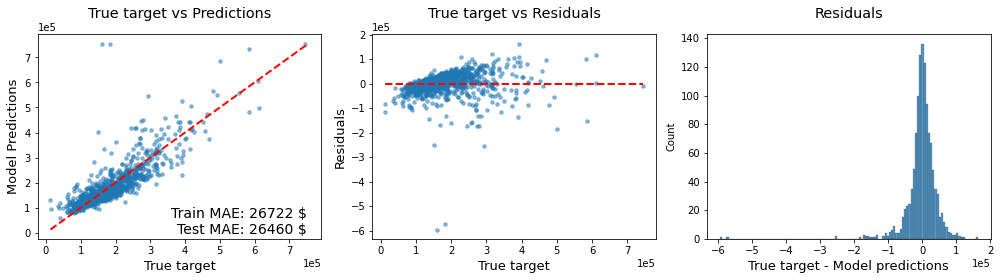

In [31]:
from sklearn.compose import TransformedTargetRegressor

X = data_df[continuous]
y = data_df['SalePrice'] 

# Define the pipeline
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()), 
    ('scaler', StandardScaler()), # performs a bit better than Standard Scaler  
])


# Define the model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor = Ridge(), 
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    ),
)

# Fit the model and get predictions
res2 = fit_pipe(X, y, model)

---
    The test MAE improved by ~1400$ after transforming the target variable with the Quantile Transformer, however it seems now that the residuals are tilted wrt to the previous test.
---

---
### **6.3 Add polynomial features**
---

In [32]:
from sklearn.preprocessing import PolynomialFeatures

class AddPolyFeatures(BaseEstimator, TransformerMixin):
    
    '''
    - To get only x degree features flag 'only_degree' should be set to True
    - To get poly features with or without interactions flag 'only_degree' should be set to False
        - interactions have their own flag 'only_inter' which works only if flag 'only_degree' is set to True
        
    '''
    
    def __init__(self, columns_for_features, deg=2, only_inter=False, include_bias=False, only_degree = False):
        self.columns = []
        self.columns_for_features = columns_for_features 
        self.deg = deg
        self.only_inter = only_inter
        self.include_bias = include_bias
        self.only_degree = only_degree
        
    def preprocess_f(self, X_df):
        
        # To get poly features with interactions or only interactions
        if (self.only_degree==False): 
        
            # Create the polynomial object
            pf_obj = PolynomialFeatures(degree=self.deg, interaction_only=self.only_inter, include_bias=self.include_bias)

            # Preprocess data
            X_poly = pf_obj.fit_transform(X_df[self.columns_for_features])      

            # Convert the numpy array to dataframe
            X_preprocessed = pd.DataFrame(X_poly, columns=pf_obj.get_feature_names(self.columns_for_features)) 
            
        
        else: # To get only feautures according to degree without interactions
            
            '''
            Manual created features gives a copy warning. Not clear the reason why. 
            An alternative is implemented which is a bit overkilling for memory but it works well. 
            '''
            
            # Define the PolynomialFeatures with interactions and only interactions
            pf_obj_all = PolynomialFeatures(degree=self.deg, interaction_only=False, include_bias=self.include_bias)
            pf_obj_inter = PolynomialFeatures(degree=self.deg, interaction_only=True, include_bias=self.include_bias)
            
            # Fit the input X
            X_poly_all = pf_obj_all.fit_transform(X_df[self.columns_for_features]) 
            X_poly_inter = pf_obj_inter.fit_transform(X_df[self.columns_for_features]) 
            
            # Convert the numpy array to dataframe
            X_preprocessed_all = pd.DataFrame(X_poly_all, columns=pf_obj_all.get_feature_names(self.columns_for_features)) 
            X_preprocessed_inter = pd.DataFrame(X_poly_inter, columns=pf_obj_inter.get_feature_names(self.columns_for_features))     
            
            # Get in a list all the columns with degree without interactions and without the original feautures
            cols_diff = [col for col in X_preprocessed_all.columns.to_list() if col not in X_preprocessed_inter.columns.to_list()] 
            
            # Create a new dataframe with the degrees
            X_df_degs = X_preprocessed_all[cols_diff]
            X_df_degs = X_df_degs.set_index(X_df.index) # set the same index as the original dataframe X_df
            
            # Merge the dataframes
            X_preprocessed = pd.merge(X_df, X_df_degs, left_index=True, right_index=True)

            #for col in self.columns:
                # Create the polynomial features manually
             #   for i in np.arange(1, self.deg):
             #       x = X_df[col]
             #       X_df[col+'^'+str(i+1)] = np.c_[x**(i+1)] ### Copy warning, 
            
        return X_preprocessed        
        
        
            
    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        # update final columns
        self.columns = X_reindexed.columns

        return X_reindexed
    

    def get_features_name(self):
        return self.columns  

---
#### **Test the preprocessor**
---

In [33]:
X = data_df[continuous]
y = data_df['SalePrice'] 

# Define the pipeline
pipe = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()), 
    ('add_poly_features' , AddPolyFeatures(continuous, only_degree=True, deg=2, only_inter=False)) 
])

X_preprocessed = pipe.fit_transform(X,y)
X_preprocessed.head()

Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
0         69.20      8795          0.00        300.00          0.00   
1         75.00     10170        522.00          0.00          0.00   
2         21.00      2001         80.00          0.00          0.00   
3         70.00     10552          0.00      1,018.00          0.00   
4         60.00     10120          0.00          0.00          0.00   

   Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  ...  \
0       652.00         952.00         980        1276                0  ...   
1       216.00         216.00        1575           0                0  ...   
2       546.00         546.00         546         546                0  ...   
3       380.00       1,398.00        1700           0                0  ...   
4       925.00         925.00         964         925                0  ...   

   Low Qual Fin SF^2  Gr Liv Area^2  Garage Area^2  Wood Deck SF^2  \
0               0.00   5,089,536.00     306,916.00       50,176.00   
1               0.00   2,480,625.00     160,000.00            0.00   
2               0.00   1,192,464.00      81,796.00            0.00   
3               0.00   2,890,000.00     199,809.00            0.00   
4               0.00   3,568,321.00      94,864.00            0.00   

   Open Porch SF^2  Enclosed Porch^2  3Ssn Porch^2  Screen Porch^2  \
0         2,916.00              0.00          0.00            0.00   
1             0.00              0.00          0.00            0.00   
2             0.00              0.00          0.00            0.00   
3         1,444.00              0.00          0.00            0.00   
4             0.00         69,696.00          0.00            0.00   

   Pool Area^2  Misc Val^2  
0         0.00        0.00  
1         0.00        0.00  
2         0.00        0.00  
3         0.00        0.00  
4         0.00        0.00  

[5 rows x 38 columns]

---
#### **Add features**
---

test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      24,920.39     24,483.25      0.80     0.73

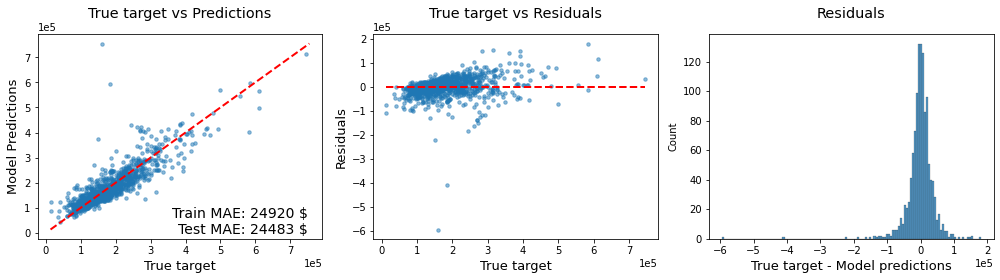

In [34]:
X = data_df[continuous]
y = data_df['SalePrice'] 

# Final columns to add poly features
cols_for_poly = ['Lot Frontage', 'BsmtFin SF 1', '1st Flr SF', '2nd Flr SF','Gr Liv Area', 'Garage Area', 'Open Porch SF']

# Define the preprocessing steps
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True, deg=2, only_inter=False)),
    ('scaler', StandardScaler()),  
])

# Define the model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(), 
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    ),
)

# Fit and get metrics from predictions
res3 = fit_pipe(X, y, model)

---
    From all the combinations checked a reduction of ~2000$ in test MAE was achieved adding only 2nd degree polynomials without interactions to the following features:
        - Lot Frontage, 
        - BsmtFin SF 1, 
        - 1st Flr SF, 
        - 2nd Flr SF,
        - Gr Liv Area,
        - Garage Area,
        - Open Porch SF
   
---

---
### **6.4 Add transformations**
---

In [35]:
class AddTransformations(BaseEstimator, TransformerMixin):
    
    '''
    - extra_columns flag is used as False to replace the original features with transformed ot as True to create new columns
    - For all columns in 'colls_all' list, logs or power or quantile transformations can be added
    - To get either quantile or power transformations for different feautures pass the corresponding lists to 'cols_powerTr' and 'cols_quantiles'
    
    '''
    def __init__(self, cols_powerTr=[], cols_quantiles=[], cols_all=[], all_logs=False, all_quantiles=False, all_power_transform=False, extra_columns=False):
        self.columns = []
        self.cols_powerTr = cols_powerTr
        self.cols_quantiles = cols_quantiles
        self.cols_all = cols_all
        self.all_logs = all_logs
        self.all_quantiles = all_quantiles
        self.all_power_transform = all_power_transform
        self.extra_columns = extra_columns
        
        
    def preprocess_f(self, X_df):
        # Work on a copy
        X_df = X_df.copy()
        
        # For same transformations in all columns
        if len(self.cols_all)>0:
            
            for col in self.cols_all:
                
                if col in X_df.columns:
                               
                    # For replacing original data with transformations 
                    if self.extra_columns==False: 

                        X_df[col+'_copy'] = X_df[col] # get a copy of the initial values

                        # Only one transformation can be applied
                        if (self.all_logs==True):
                            X_df[col] = X_df[col+'_copy'] # first reset if switching between different transformations
                            X_df[col] = np.log1p(X_df[col])
                        elif (self.all_power_transform==True):
                            pp = PowerTransformer() 
                            X_df[col] = X_df[col+'_copy'] # first reset if switching between different transformations
                            x = X_df[col].to_numpy()
                            X_df[col] = pp.fit_transform(x[:, np.newaxis])
                        elif (self.all_quantiles==True):
                            qt = QuantileTransformer(output_distribution='normal', random_state=0, copy=False, n_quantiles=100) 
                            X_df[col] = X_df[col+'_copy'] # first reset if switching between different transformations
                            x = X_df[col].to_numpy()    
                            X_df[col] = qt.fit_transform(x[:, np.newaxis])
                        else:     
                            if (col+'_copy') in X_df.columns:
                                X_df[col] = X_df[col+'_copy'] # first reset if switching between different transformations
                                X_df = X_df.drop(columns=[col+'_copy'], axis=1) # drop extra column

                    # For adding extra columns
                    else: 
                        # For log transformations
                        if (self.all_logs==True):
                            X_df[col+'_log'] = np.log1p(X_df[col]) 
                        else:
                            if (col+'_log') in X_df.columns:
                                X_df = X_df.drop(columns=[col+'_log'], axis=1) # drop the column

                        # For power transformations
                        if (self.all_power_transform==True):  
                            pp = PowerTransformer()
                            x = X_df[col].to_numpy()
                            X_df[col+'_powerTr'] = pp.fit_transform(x[:, np.newaxis]) 
                        else:
                            if (col+'_powerTr') in X_df.columns:
                                X_df = X_df.drop(columns=[col+'_powerTr'], axis=1) # drop the column                        

                        # For quantile transformations
                        if (self.all_quantiles==True):  
                            qt = QuantileTransformer(output_distribution='normal', random_state=0, copy=False, n_quantiles=100) 
                            x = X_df[col].to_numpy()
                            X_df[col+'_quantile'] = qt.fit_transform(x[:, np.newaxis]) 
                        else:
                            if (col+'_quantile') in X_df.columns:
                                X_df = X_df.drop(columns=[col+'_quantile'], axis=1) # drop the column                            

  
         # Mixed transformation 
        else:
            if len(self.cols_powerTr)>0:
                
                pp = PowerTransformer()

                for col in self.cols_powerTr:
                    
                    if col in X_df.columns:
                        x = X_df[col].to_numpy()
                        if self.extra_columns==False:
                            X_df[col] = pp.fit_transform(x[:, np.newaxis])
                        else:
                            X_df[col+'_powerTr'] = pp.fit_transform(x[:, np.newaxis]) 
                        
            if len(self.cols_quantiles)>0:
                
                qt = QuantileTransformer(output_distribution='normal', random_state=0, copy=False, n_quantiles=100) 

                for col in self.cols_quantiles:
                    
                    if col in X_df.columns:
                        x = X_df[col].to_numpy()
                        if self.extra_columns==False:
                            X_df[col] = qt.fit_transform(x[:, np.newaxis])
                        else:
                            X_df[col+'_quantile'] = qt.fit_transform(x[:, np.newaxis])                
        
        # Clean remnants
        for col in self.cols_all:
            if col in X_df.columns:
                if (col+'_copy') in X_df.columns:
                    X_df[col] = X_df[col+'_copy'] # first reset if switching between different transformations
                    X_df = X_df.drop(columns=[col+'_copy'], axis=1) # drop extra column            
            

        return X_df
    

    def fit(self, X_df, y=None):
        
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)     

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self  

    def transform(self, X_df):

        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame
              
        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        self.columns = X_reindexed.columns

        return X_reindexed
    
    def get_features_name(self):
        return self.columns      

---
#### **Test the transformer**
---

In [36]:
X = data_df[continuous]
y = data_df['SalePrice'] 

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, random_state=0)

# Define the preprocessing steps
pipe = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True, deg=2, only_inter=False)), # 7 columns in total 
    ('add_transformations', AddTransformations(cols_powerTr=[], cols_quantiles=[], cols_all=continuous, 
                                               all_logs=True, 
                                               all_quantiles=True, 
                                               all_power_transform=True, 
                                               extra_columns=True)),
])

X_tr_preprocessed = pipe.fit_transform(X_tr,y_tr)
X_tr_preprocessed.head()

Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
339          -1.19     20896         -5.20          2.41         -5.20   
1557         -0.19      8930         -5.20         -5.20         -5.20   
2167         -1.34      3811          0.70          2.10         -5.20   
706           0.04     11200          0.37          1.64         -5.20   
2396          2.07     31250         -5.20         -5.20         -5.20   

      Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  \
339         -0.30           2.14        2097           0                0   
1557        -5.20          -5.20        1318         584                0   
2167        -1.10           1.22        1646           0                0   
706         -1.37           0.63        1298           0                0   
2396        -5.20          -5.20        1600           0                0   

      ...  3Ssn Porch_quantile  Screen Porch_log  Screen Porch_powerTr  \
339   ...                -5.20              0.00                 -0.32   
1557  ...                -5.20              0.00                 -0.32   
2167  ...                -5.20              5.05                  3.08   
706   ...                -5.20              0.00                 -0.32   
2396  ...                -5.20              0.00                 -0.32   

      Screen Porch_quantile  Pool Area_log  Pool Area_powerTr  \
339                   -5.20           0.00              -0.06   
1557                  -5.20           0.00              -0.06   
2167                   1.57           0.00              -0.06   
706                   -5.20           0.00              -0.06   
2396                  -5.20           0.00              -0.06   

      Pool Area_quantile  Misc Val_log  Misc Val_powerTr  Misc Val_quantile  
339                -5.20          0.00             -0.18              -5.20  
1557               -5.20          0.00             -0.18              -5.20  
2167               -5.20          0.00             -0.18              -5.20  
706                -5.20          0.00             -0.18              -5.20  
2396               -5.20          0.00             -0.18              -5.20  

[5 rows x 83 columns]

---
#### **Add transformations**
---

In [37]:
# Define which columns will be transformed with the PowerTransformer and which with the QuantileTransformer
quantile_columns = ['Lot Area', '1st Flr SF', 'Gr Liv Area']
powerTr_columns = [col for col in continuous if col not in quantile_columns] # Rest of continous columns

test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      23,676.87     23,053.74      0.82     0.74

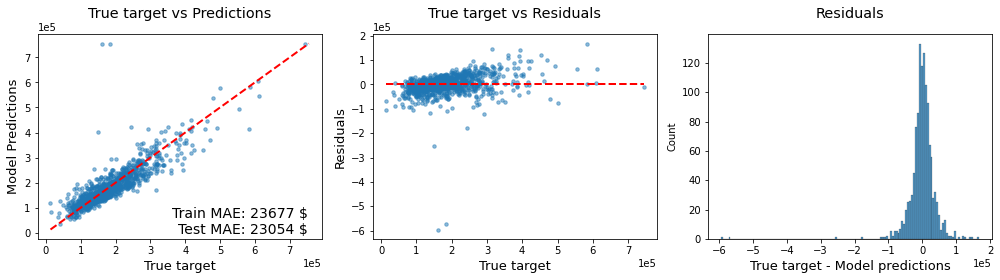

In [38]:
X = data_df[continuous]
y = data_df['SalePrice'] 

# Define the preprocessing steps
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True, deg=2, only_inter=False)),    
    ('add_transformations', AddTransformations(cols_powerTr=[], cols_quantiles=[], cols_all=continuous, 
                                               all_logs=True, 
                                               all_quantiles=False, 
                                               all_power_transform=False, 
                                               extra_columns=True)),
    ('scaler', StandardScaler()),  
])

# Define the model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor = Ridge(), 
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    ),
)

res4 = fit_pipe(X, y, model)

---
 
    Several transformations and combinations were checked. With the log transformation for all the continuous a further reduction in the test MAE of ~1400$ was achieved.
   
---

---
### **6.5 Add binary features and/or Total Porch**
---

In [39]:
# To check all that we saw above
class AddBinaryFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, has_MasVnrArea=False, has_Basement=False, has_2ndFloor=False, has_Garage=False, has_Pool=False,
                       has_WoodDeck=False, has_Porch=False, has_MiscVal=False, has_LowQualFinSF=False, total_porch=False):
        
        self.columns = []  # useful to well behave with FeatureUnion
        self.has_MasVnrArea = has_MasVnrArea
        self.has_Basement = has_Basement
        self.has_2ndFloor = has_2ndFloor
        self.has_Garage = has_Garage
        self.has_Pool = has_Pool
        self.has_WoodDeck = has_WoodDeck
        self.has_Porch = has_Porch
        self.has_MiscVal = has_MiscVal
        self.has_LowQualFinSF = has_LowQualFinSF
        self.total_porch = total_porch
        

    def add_binary(self, X_df):
        # Work on a copy
        X_df = X_df.copy()
        
        if self.has_MasVnrArea==True:
            if ('Mas Vnr Area') in X_df.columns:
                X_df['has_MasVnrArea'] = X_df['Mas Vnr Area'].apply(lambda x: 1 if x > 0 else 0)    
                
        if self.has_Basement==True:
            if ('Total Bsmt SF') in X_df.columns:
                X_df['has_Basement']  = X_df['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
                
        if self.has_2ndFloor==True:
            if ('2nd Flr SF') in X_df.columns:
                X_df['has_2ndFloor'] = X_df['2nd Flr SF'].apply(lambda x: 1 if x > 0 else 0)
                
        if self.has_Garage==True:
            if ('Garage Area') in X_df.columns:
                X_df['has_Garage'] = X_df['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
                
        if self.has_Pool==True:
            if ('Pool Area') in X_df.columns:
                X_df['has_Pool'] = X_df['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
            
        if self.has_WoodDeck==True:
            if ('Wood Deck SF') in X_df.columns:
                X_df['has_WoodDeck'] = X_df['Wood Deck SF'].apply(lambda x: 1 if x > 0 else 0)
            
            
        if self.has_Porch==True:
            if ('Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch') in X_df.columns:
                X_df['has_Porch'] = (X_df['Open Porch SF'] |  
                                     X_df['Enclosed Porch'] | 
                                     X_df['3Ssn Porch'] |
                                     X_df['Screen Porch']).apply(lambda x: 1 if x > 0 else 0)
                
        if self.has_MiscVal==True:
            if ('Misc Val') in X_df.columns:
                X_df['has_MiscVal'] = df_delme['Misc Val'].apply(lambda x: 1 if x > 0 else 0)
            
            
        if self.has_LowQualFinSF==True:
            if ('Low Qual Fin SF') in X_df.columns:
                X_df['has_LowQualFinSF'] = df_delme['Low Qual Fin SF'].apply(lambda x: 1 if x > 0 else 0)
            
        # This is not binary    
        if self.total_porch==True:
            if ('Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch') in X_df.columns:
                X_df['Total Porch'] = X_df['Open Porch SF'] + X_df['Enclosed Porch'] + X_df['3Ssn Porch'] + X_df['Screen Porch']

        return X_df
    
    def fit(self, X_df, y=None):
        # Check that X_df is a DataFrame
        assert type(X_df) == pd.DataFrame
        
        # Preprocess data
        X_preprocessed = self.add_binary(X_df)     

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns
        
        # Return estimator
        return self    
    

    def transform(self, X_df):

        assert type(X_df) == pd.DataFrame        
        
        # Preprocess data
        X_preprocessed = self.add_binary(X_df)
        
        # Save columns names/order for inference time
        #self.columns = X_preprocessed.columns        
        
        #self.columns = X_df.columns 
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        self.columns = X_reindexed.columns 
        
        return X_reindexed
    

    def get_features_name(self): 
        return self.columns

test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      23,697.09     23,043.68      0.82     0.74

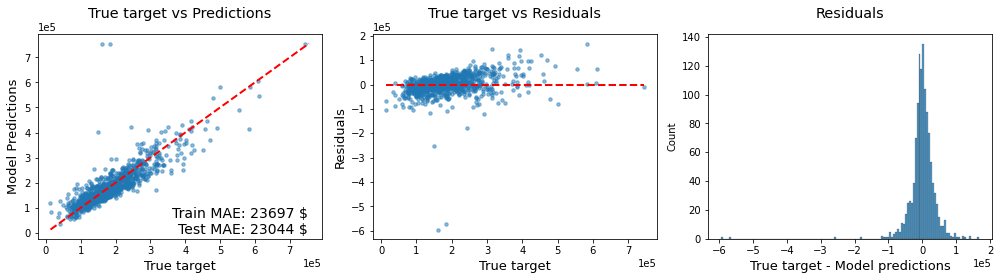

In [40]:
X = data_df[continuous]
y = data_df['SalePrice'] 

# Define the preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),   
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True, deg=2, only_inter=False)),       
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Basement=False, has_2ndFloor=False, has_Garage=True, has_Pool=False,
                       has_WoodDeck=False, has_Porch=False, has_MiscVal=False, has_LowQualFinSF=False, total_porch=False)),     
    ('scaler', StandardScaler())
])

# Define the model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor = Ridge(), 
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)
    ),
)

# Fit and get predictions and metrics
res5 = fit_pipe(X, y, model)

---
    From this test, the test MAE was reduced only by 10$ when adding only two binary features:
        - has_MasVnrArea
        - has_Garage
---

---
### **6.6 Add outlier regressor**
---

---
#### **6.6.1 ZScoresOutlierClassifier in numpy implementation**
---

In [41]:
from sklearn.base import BaseEstimator, ClassifierMixin

# Custom outliers detector base on z-scores
# Adapted from https://github.com/scikit-learn/scikit-learn/issues/9630#issuecomment-325202441
class ZScoresOutlierClassifier(BaseEstimator, ClassifierMixin):
    '''
    This outlier detector works with numpy arrays
    '''
    
    def __init__(self, columns, threshold=3, verbose=True):
        self.columns = columns
        self.threshold = threshold
        self.verbose = verbose
        
    def transformXy(self, X, y):
        
        # Check if X is dataframe, if yes return a numpy array
        if isinstance(X, pd.DataFrame):  
            X = X.to_numpy()
            
        # Check if y is series object, if yes return a numpy array
        if isinstance(y, pd.core.series.Series):
            y = y.to_numpy()        
        
        return X,y        
        
    def fit(self, X, y):
                
        X, y = self.transformXy(X,y)
                        
        # Calculate mean and standard deviation for X and y
        self.train_mean_ = np.mean(X[:,self.columns], axis=0)
        self.train_std_ = np.std(X[:,self.columns], axis=0)
        
        self.ytrain_mean_ = np.mean(y)
        self.ytrain_std_ = np.std(y)
                
        self.X_= X    
        self.y_ = y;     
        
        return self

    def predict(self, X):
        
        # Create two arrays with zeros for X and y with same dimensions
        z_score_X = np.zeros(self.X_[:,self.columns].shape)
        z_score_y = np.zeros(self.y_.shape)

        # Calculate z scores for X, y
        z_score_X = (self.X_[:,self.columns] - self.train_mean_) / (self.train_std_)
        z_score_y = (self.y_ - self.ytrain_mean_) / (self.ytrain_std_)
        
        # Return boolean arrays of values according to threshold
        below_thresholdX = np.abs(z_score_X)>= self.threshold 
        below_thresholdy = np.abs(z_score_y)>= self.threshold 
        
        
        # Find inliners for X
        Xmask = np.all(below_thresholdX, axis=1) # Change to all() because I will check untransformed but scaled features

        mask = Xmask | below_thresholdy
        
        # Replace +1 for outliers, -1 for inliners 
        mask = np.where(mask==True, 1, -1)
        
        unique, counts = np.unique(mask, return_counts=True)
        
        if self.verbose==True:
            if (len(unique)==1): 
                print('Outliers detected: {} ({:.1f}%)'.format(
                            0, 0))
            else:
                print('Outliers detected: {} ({:.1f}%)'.format(
                            counts[1], ((100*counts[1])/(counts[0]+counts[1]))))           

        return mask

---
#### **6.6.2 WithoutOutliersRegressor - transforms X,y to numpy**
---

In [42]:
from sklearn.base import RegressorMixin, clone

# Custom regressor with an embedded outliers detector
class WithoutOutliersRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, outlier_detector, regressor):
        self.outlier_detector = outlier_detector
        self.regressor = regressor
        
    def transformXy(self, X, y):
        
        # Check if X is dataframe, if yes return a numpy array
        if isinstance(X, pd.DataFrame):  
            X = X.to_numpy()
            
        # Check if y is series object, if yes return a numpy array
        if isinstance(y, pd.core.series.Series):
            y = y.to_numpy()
        
        return X,y
    

    def fit(self, X, y, verbose=False):
        
        X, y = self.transformXy(X,y)
        
        # Fit outliers detector, use it on X
        self.outlier_detector_ = clone(self.outlier_detector).fit(X, y)
        outliers = self.outlier_detector_.predict(y) == 1 # Outliers are those with 1
        
        # Print the number of outliers detected
        if verbose:
            print('Outliers detected: {} ({:.1f}%)'.format(
                    outliers.sum(), 100*outliers.mean()))
          
        # Fit regressor without the outliers
        self.regressor_ = clone(self.regressor).fit(X[~outliers], y[~outliers])
        
        # Return the estimator
        return self

    def predict(self, X):
        
        # Make predictions with the regressor (fitted without the outliers)    
        return self.regressor_.predict(X)

---
#### **6.6.3 Test the model without fitting the outliers**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      23,578.83     22,948.30      0.82     0.74

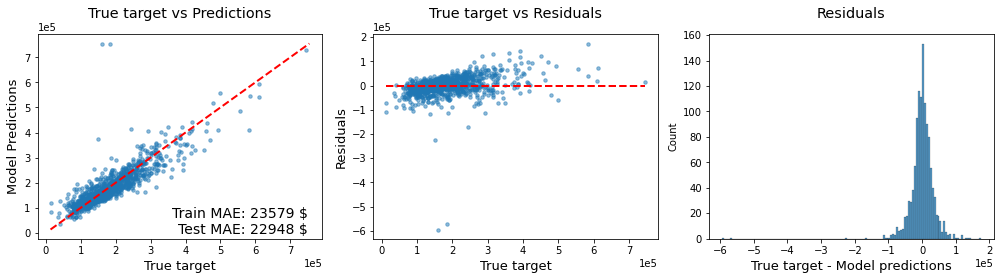

In [43]:
X = data_df[continuous].drop(['Pool Area', 'Misc Val'], axis=1)
y = data_df['SalePrice'] 

# Define preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),   
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),      
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('scaler', StandardScaler())
])


# Features to check for outliers
cols_for_outliers = ['Gr Liv Area','Lot Area'] # those are scaled anyway 
cols_for_outliers_indices = [X.columns.get_loc(col) for col in cols_for_outliers] # Get indices of columns since the detector works with numpy arrays

# Define Model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor = WithoutOutliersRegressor(
                        outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                        regressor = Ridge()),
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)    
    )
                     
)

res6 = fit_pipe(X, y, model)

---
    Removing the four outliers discussed previously, a further improve in the test MAE of ~95$ was achieved.
---

---
## **Summary for the Continuous Features**
---

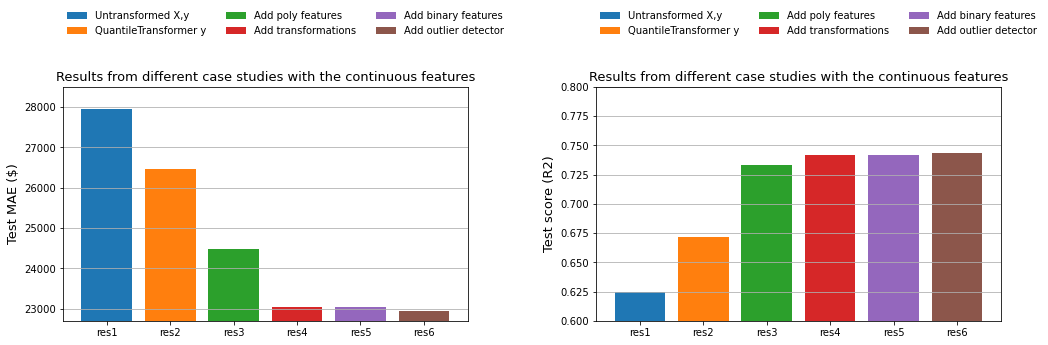

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        
ax[0].bar('res1', np.int(np.round(res1['test_mae ($)'].to_list()[0])), label='Untransformed X,y')
ax[0].bar('res2', np.int(np.round(res2['test_mae ($)'].to_list()[0])), label='QuantileTransformer y')
ax[0].bar('res3', np.int(np.round(res3['test_mae ($)'].to_list()[0])), label='Add poly features')
ax[0].bar('res4', np.int(np.round(res4['test_mae ($)'].to_list()[0])), label='Add transformations')
ax[0].bar('res5', np.int(np.round(res5['test_mae ($)'].to_list()[0])), label='Add binary features')
ax[0].bar('res6', np.int(np.round(res6['test_mae ($)'].to_list()[0])), label='Add outlier detector')
ax[0].set_title('Results from different case studies with the continuous features', fontsize=13)
ax[0].set_ylabel('Test MAE ($)', fontsize=13)
ax[0].legend(loc='lower left', bbox_to_anchor= (0.0, 1.2), ncol=3, borderaxespad=0, frameon=False)
ax[0].set_ylim(22700, 28500)
ax[0].grid(axis='y')

ax[1].bar('res1', res1['test_R2'].to_list()[0], label='Untransformed X,y')
ax[1].bar('res2', res2['test_R2'].to_list()[0], label='QuantileTransformer y')
ax[1].bar('res3', res3['test_R2'].to_list()[0], label='Add poly features')
ax[1].bar('res4', res4['test_R2'].to_list()[0], label='Add transformations')
ax[1].bar('res5', res5['test_R2'].to_list()[0], label='Add binary features')
ax[1].bar('res6', res6['test_R2'].to_list()[0], label='Add outlier detector')
ax[1].set_title('Results from different case studies with the continuous features', fontsize=13)
ax[1].set_ylabel('Test score (R2)', fontsize=13)
ax[1].legend(loc='lower left', bbox_to_anchor= (0.0, 1.2), ncol=3, borderaxespad=0, frameon=False)
ax[1].set_ylim(0.6, 0.8)
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

---
    Adding the quantile transformer for the target variable, the polynomial features, the log transformations and the fit without the outliers, the test MAE has been decreased by ~5000$.
---

---
# <font color="blue">**C. Discrete Variables**</font>
---

### **1. Check Descriptive Statistics**
---

In [45]:
data_df[descrete].describe().T

count     mean   std      min      25%      50%      75%  \
Bedroom AbvGr  2,430.00     2.84  0.82     0.00     2.00     3.00     3.00   
Bsmt Full Bath 2,428.00     0.43  0.53     0.00     0.00     0.00     1.00   
Bsmt Half Bath 2,428.00     0.06  0.24     0.00     0.00     0.00     0.00   
Fireplaces     2,430.00     0.60  0.65     0.00     0.00     1.00     1.00   
Full Bath      2,430.00     1.56  0.55     0.00     1.00     2.00     2.00   
Garage Cars    2,429.00     1.76  0.76     0.00     1.00     2.00     2.00   
Garage Yr Blt  2,292.00 1,977.86 25.54 1,896.00 1,960.00 1,978.00 2,002.00   
Half Bath      2,430.00     0.37  0.50     0.00     0.00     0.00     1.00   
Kitchen AbvGr  2,430.00     1.04  0.21     0.00     1.00     1.00     1.00   
MS SubClass    2,430.00    57.09 42.90    20.00    20.00    50.00    70.00   
Mo Sold        2,430.00     6.21  2.72     1.00     4.00     6.00     8.00   
Overall Cond   2,430.00     5.57  1.12     1.00     5.00     5.00     6.00   
Overall Qual   2,430.00     6.09  1.41     1.00     5.00     6.00     7.00   
TotRms AbvGrd  2,430.00     6.41  1.55     2.00     5.00     6.00     7.00   
Year Built     2,430.00 1,971.17 30.21 1,875.00 1,954.00 1,973.00 2,000.00   
Year Remod/Add 2,430.00 1,984.24 20.75 1,950.00 1,966.00 1,993.00 2,003.00   
Yr Sold        2,430.00 2,007.78  1.31 2,006.00 2,007.00 2,008.00 2,009.00   

                    max  
Bedroom AbvGr      8.00  
Bsmt Full Bath     3.00  
Bsmt Half Bath     2.00  
Fireplaces         4.00  
Full Bath          4.00  
Garage Cars        4.00  
Garage Yr Blt  2,207.00  
Half Bath          2.00  
Kitchen AbvGr      3.00  
MS SubClass      190.00  
Mo Sold           12.00  
Overall Cond       9.00  
Overall Qual      10.00  
TotRms AbvGrd     15.00  
Year Built     2,010.00  
Year Remod/Add 2,010.00  
Yr Sold        2,010.00

---
    - From the descriptive statistics we see that the feature 'Garage Yr Blt' has a wrong max value at 2207
    - The are dwellings that were built from 1875 but the remodelling or addition was from 1950
    - All the dwellings were sold between 2006 and 2010
    - There are dwellings that have not even the basics as for e.g. kitchen or bathroom 
---

### **2. Check missing values**
---

In [46]:
calc_nulls(data_df[descrete])

Missing values  Percentage (%)     Type
Garage Yr Blt              138            5.68  float64
Bsmt Full Bath               2            0.08  float64
Bsmt Half Bath               2            0.08  float64
Garage Cars                  1            0.04  float64

---
#### **2.1 Garage Nulls**
---

In [47]:
pd.options.display.float_format = "{:,.0f}".format

# Define a list with all the Garage columns
cols_grg = ['Garage Area', 'Garage Yr Blt', 'Garage Cars']

print('Wrong entry in Garage Yr Blt:')
print(data_df['Garage Yr Blt'].loc[data_df['Garage Yr Blt']>2010], '\n')

# Create a mask if any of the above are zero
mask = data_df[cols_grg].isnull().any(axis=1)
print('Nulls in any of :',cols_grg)
print(mask.value_counts())

# Create new masks based on the previous mask by checking the Garage Area
mask_area_zero = data_df[cols_grg][mask].loc[data_df['Garage Area'][mask]==0].index # when GarageArea = 0
mask_area_nzer = data_df[cols_grg][mask].loc[data_df['Garage Area'][mask]!=0].index # when GarageArea != 0


print('\nIf [Garage Area==0] :\n')
display(data_df.loc[mask_area_zero,cols_grg].describe().T)

print('\nIf [Garage Area!=0] :\n')
display(data_df.loc[mask_area_nzer, cols_grg +['Garage Type', 'Neighborhood']])



Wrong entry in Garage Yr Blt:
2219   2,207
Name: Garage Yr Blt, dtype: float64 

Nulls in any of : ['Garage Area', 'Garage Yr Blt', 'Garage Cars']
False    2292
True      138
dtype: int64

If [Garage Area==0] :



count  mean  std  min  25%  50%  75%  max
Garage Area      136     0    0    0    0    0    0    0
Garage Yr Blt      0   nan  nan  nan  nan  nan  nan  nan
Garage Cars      136     0    0    0    0    0    0    0


If [Garage Area!=0] :



Garage Area  Garage Yr Blt  Garage Cars Garage Type Neighborhood
1114          360            nan            1      Detchd      OldTown
1565          nan            nan          nan      Detchd       IDOTRR

---
    1. When the Garage Area is 0 we can replace the missing values of the Garage Yr Blt feature with 0. This will replace the 136 nulls. 
    2. For the other 2 entries we can fill in the missing values as following:
        a) When Garage Area>0 the Garage Yr Built can be filled in with the same year that the property was built (Year Built)
        b) When Garage Area=nan the Garage Area and Carage cars can be filled in with the median of the training data
    3. We can also correct the wrong entry on Garage Yr Blt=2207 with the year that the property was built. As we can see there is 1 entry.
---

#### **2.2 Basement Nulls**
---

In [48]:
basm_cols = ['BsmtFin SF 1','BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']

data_df[basm_cols].loc[data_df['Bsmt Full Bath'].isnull() | data_df['Bsmt Half Bath'].isnull()]

BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Bsmt Full Bath  \
104            nan           nan          nan            nan             nan   
2056             0             0            0              0             nan   

      Bsmt Half Bath  
104              nan  
2056             nan

---
    The missing values of the Bsmt Full and Half Bath features can be replaced with 0  
---

### **3. Some checks**
---

---
#### **3.1 Check if the garages were built together with the houses**
---

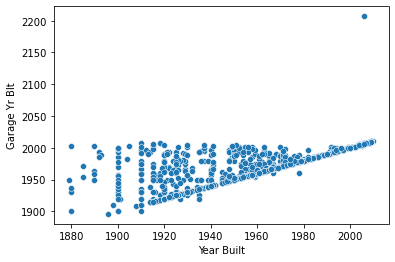

In [49]:
sns.scatterplot(x='Year Built', y='Garage Yr Blt', data=data_df)
plt.show()

---    
    We see that most of the garages were built the same year as the houses or afterwards and few that were built before. For the later case, this probably can happen especially if the garage type is builtin ot attached to the house. For the garages that are detached, as we see from below, all of them were built before 1950. It might be that at that time, these were areas where people were living and probably they didn't have cars. When afterwards they built their houses, they declared these areas as garages. So for this no correction will be done.
---    

In [50]:
data_df.loc[data_df['Garage Yr Blt'] < data_df['Year Built'], ['Garage Yr Blt', 'Year Built', 'Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Gr Liv Area']]

Garage Yr Blt  Year Built Garage Type Garage Finish  Garage Cars  \
140           1,962        1963      Detchd           Unf            1   
154           1,926        1935      Detchd           Unf            1   
330           1,960        1978      Detchd           Unf            1   
414           1,920        1927      Detchd           Unf            1   
476           1,949        1950      Detchd           Unf            2   
1029          1,954        1959     BuiltIn           Fin            2   
1281          1,920        1935      Detchd           Unf            1   
1316          1,956        1959      Attchd           Unf            2   
1464          2,005        2006      Attchd           Fin            3   
1474          2,005        2006      Attchd           RFn            2   
1527          1,900        1910      Detchd           Unf            2   
1537          1,922        1923      Detchd           Unf            2   
1662          1,925        1930      Detchd           Unf            1   
1899          2,003        2005     BuiltIn           Fin            2   
2063          1,940        1941      Detchd           Unf            1   
2118          1,961        1967     BuiltIn           Fin            2   

      Garage Area  Gr Liv Area  
140           336         1144  
154           180         1242  
330           252         1152  
414           240          520  
476           400         1040  
1029          539         1194  
1281          162         1378  
1316          440         1580  
1464        1,110         2338  
1474          674         1500  
1527          506         2291  
1537          370         1848  
1662          160          790  
1899          736         1904  
2063          256         1298  
2118          564         2978

---
#### **3.2 Check if the renovation year is earlier than the year the property was built.**
---

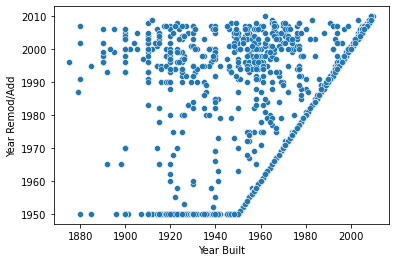

In [51]:
sns.scatterplot(x='Year Built', y='Year Remod/Add', data=data_df)
plt.show()

In [52]:
data_df.loc[data_df['Year Remod/Add'] < data_df['Year Built']].shape[0]

0

---
    We see that that renovation year which starts at 1950 is either afterwards or the same year that the houses were built which agrees with the documentation: 
        - The `Year Remod/Ads` is same as the construction date if no remodeling or additions were done.
---

---
#### **3.3 Check if a property was sold before it was built or remodeled**
---

In [53]:
data_df.loc[(data_df['Year Remod/Add'] > data_df['Yr Sold']) | (data_df['Year Built'] > data_df['Yr Sold']), ['Year Built', 'Year Remod/Add', 'Yr Sold', 'Sale Condition']]

Year Built  Year Remod/Add  Yr Sold Sale Condition
71         2008            2009     2007        Partial
263        2007            2008     2007        Partial

---
    The fact that a property was sold before it was built or renovated is not sth unusual. For this reason, no correction will be performed.
---

---
#### **3.4 Check inconsistencies in the MS SubClass**

    - This feature is a combination of 'Bldg Type', 'House Style' and 'Year Built' carrying also some extra information 
    - The numbering and the distance between the numbers on this feature does not really make sense. Thus it will be checked if the model performs better after one hot encoding.
---

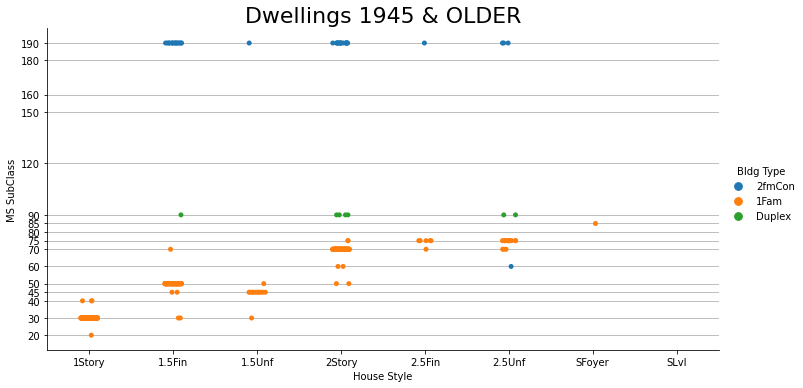

In [54]:
# Select dwellings built 1945 & OLDER 
g = sns.catplot(y='MS SubClass',x='House Style',data=data_df.loc[data_df['Year Built'] <= 1945], hue='Bldg Type',
           order=['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'], height=5, aspect=2)
g.set(yticks=[20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190])
plt.title('Dwellings 1945 & OLDER', size = 22)
plt.grid(axis='y')
plt.show()

---
    For dwellings built in 1945 & before:
        a) 1Story: should have Subclass=30, 40, 190 -> Correct the entry at Subclass=20
        b) 1.5Fin: should have Subclass=50, 150, 190 -> Correct entries with Subclass=30, 45, 70
        c) 1.5Unf: should have Subclass=45 -> Correct entries with SubClass=30, 50
        d) 2Story: should have Subclass=70 -> Correct entries with SubClass=50, 60, 75
        e) 2.5Fin: should have Subclass=75 -> Correct entry with Subclass=70
        f) 2.5Unf: should have Subclass=75 -> Correct entries with Subclass=60, 70
---         

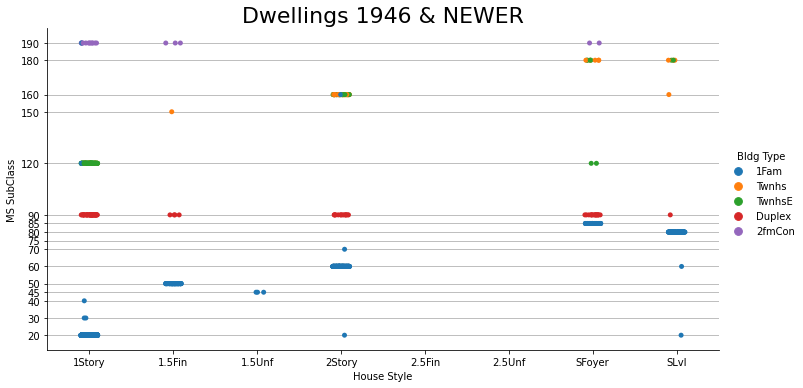

In [55]:
g = sns.catplot(y='MS SubClass',x='House Style',data=data_df.loc[data_df['Year Built'] > 1945], hue='Bldg Type',
           order=['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'], height=5, aspect=2)
g.set(yticks=[20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190])
plt.title('Dwellings 1946 & NEWER', size = 22)
plt.grid(axis='y')
plt.show()

---
    For dwellings built in 1946 and afterwards:
        a) 1Story: should have SubClass=20, 40, 120 -> Correct the entry at Subclass=30 & Subclass=190
        b) 2Story: should have SubClass=60 -> Correct entries at SubClass=20, 70 
        c) SFoyer: should have SubClass=180 -> Corrent entries at SubClass=120
        d) SLvl: should have SubClass=80, 180 -> Correct entries with SubClass=20, 60, 160

---   

### **4. Custom preprocessor for cleaning and fill in nulls**
---

In [56]:
class CleaningPreprocessorDescrVars(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns=[]
        self.grg_vars_ = ['Garage Area', 'Garage Cars']
        self.bsmt_vars_ = ['Bsmt Full Bath', 'Bsmt Half Bath']

    def preprocess_f(self, X_df, train_median):
        # Work on a copy
        X_df = X_df.copy()

        # Missing values in Garage features
        for c in self.grg_vars_:
            X_df[c] = X_df[c].fillna(train_median[c])  
        
        mask1 = (X_df['Garage Yr Blt'].isnull()) & (X_df['Garage Area']>0)
        X_df.loc[mask1, 'Garage Yr Blt'] = X_df['Year Built']
        
        mask2 = (X_df['Garage Yr Blt'].isnull()) & (X_df['Garage Area']==0)
        X_df.loc[mask2, 'Garage Yr Blt'] = 0
        
        # Correct wrong entry on Garage Yr Built
        mask3 = X_df['Garage Yr Blt']>2010
        X_df.loc[mask3, 'Garage Yr Blt'] = X_df['Year Built']
                    
        # Missing values in Basement features    
        for c in self.bsmt_vars_:
            X_df[c] = X_df[c].fillna(0)  
            

        return X_df
    

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Save train mean for the Garage variables
        self.train_median_ = X_df[self.grg_vars_].median()

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_median_)

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self  

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_median_)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        self.columns = X_reindexed.columns

        return X_reindexed
    
    def get_features_name(self):
        return self.columns

---
### **5. Distributions and correlation with the SalePrice**
---

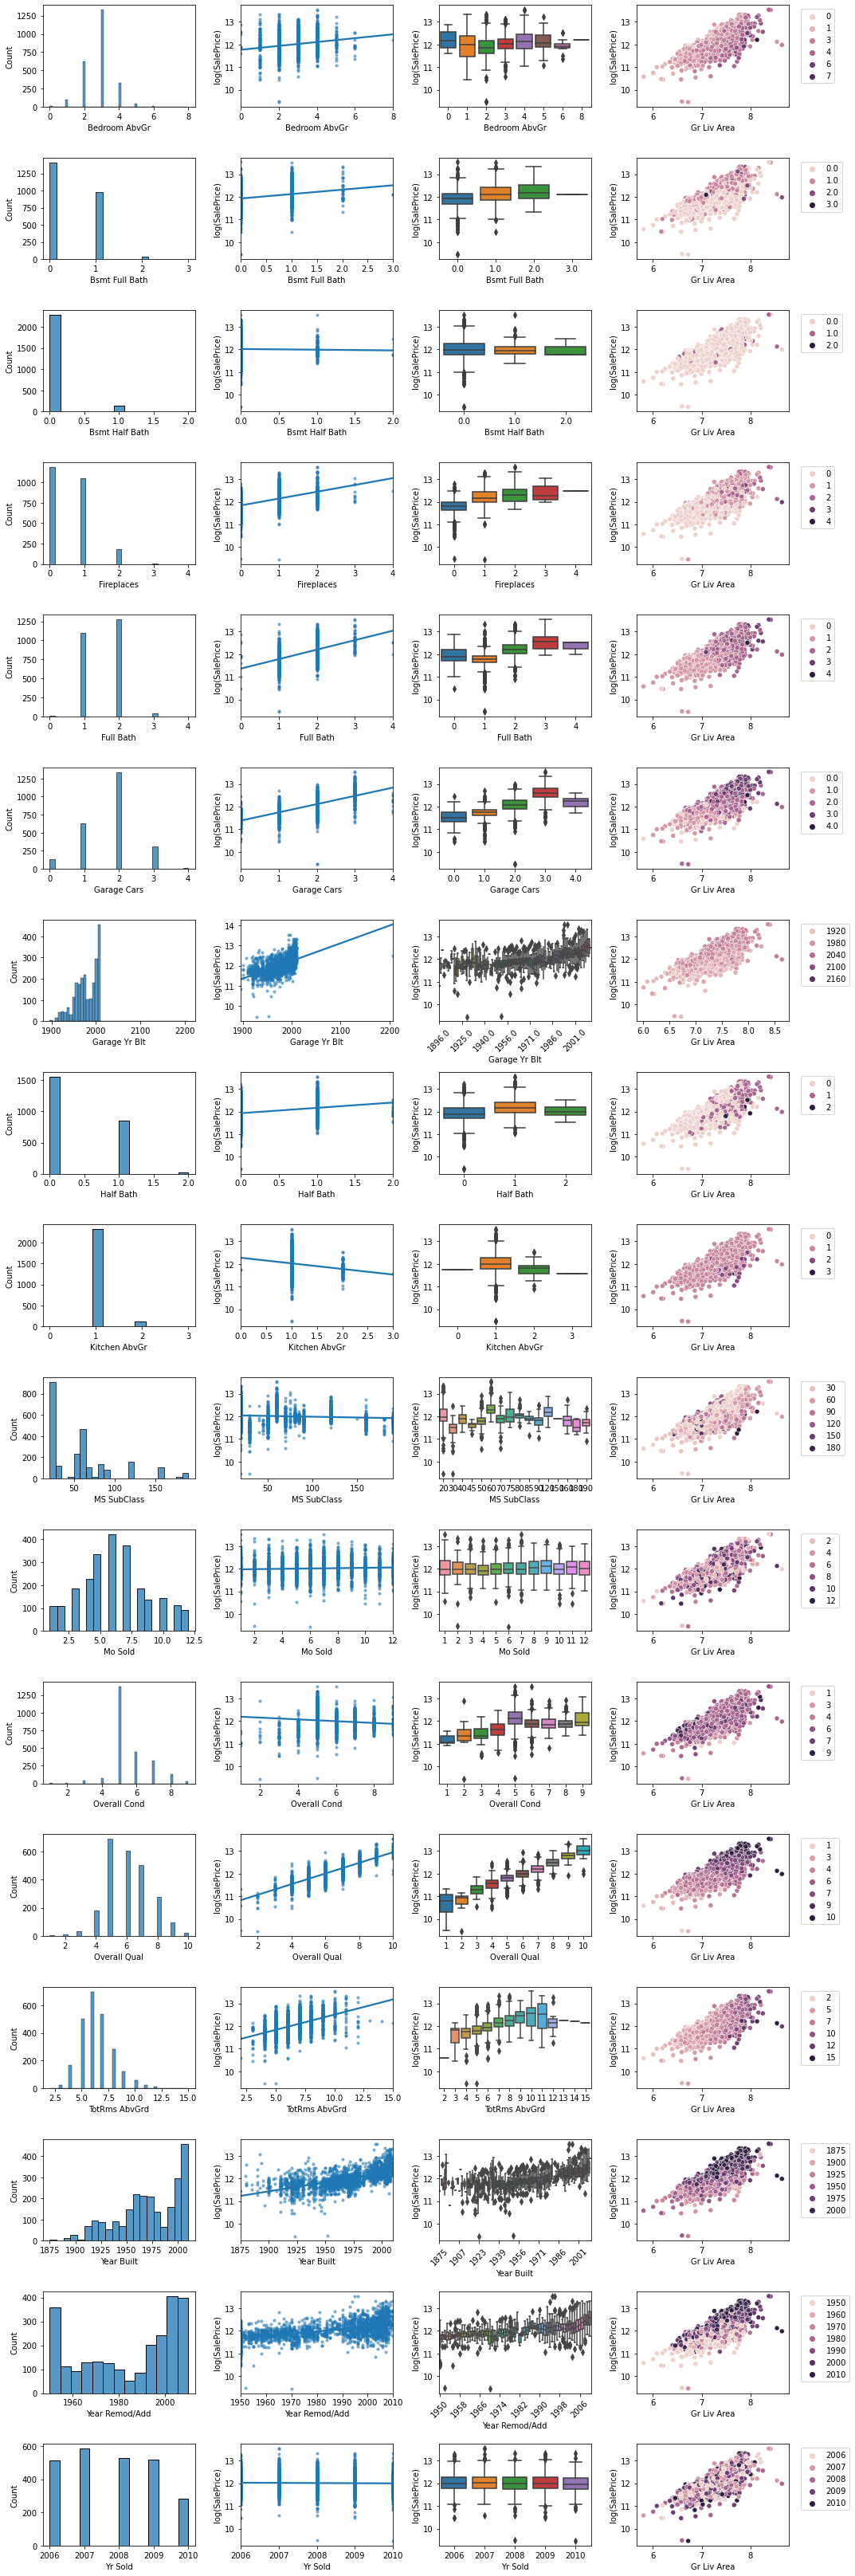

In [57]:
fig, ax = plt.subplots(nrows=len(descrete), ncols=4, figsize=(15, 45))

for row in range(0,len(descrete)):
     
    # distribution of feature 
    sns.histplot(x=descrete[row], data=data_df, ax=ax[row,0])
    
    # feature as a function of the Log(SalePrice) - regplot
    h2 = sns.regplot( x = data_df[descrete[row]], y = np.log1p(data_df['SalePrice']), robust=True, ci=None, scatter_kws={"s": 10, 'alpha':0.5}, ax = ax[row,1])
    h2.set_ylabel('log(SalePrice)')
        
    # feature as a function of the Log(SalePrice) - box plot
    h2 = sns.boxplot( x = data_df[descrete[row]], y = np.log1p(data_df['SalePrice']), ax = ax[row,2])
    if ((descrete[row]=='Garage Yr Blt') | (descrete[row]=='Year Built') | (descrete[row]=='Year Remod/Add')):
        h2.xaxis.set_major_locator(plt.MaxNLocator(8))
        h2.tick_params("x", labelrotation=45)
    h2.set_ylabel('log(SalePrice)')
    
    # feature as a hue
    h3 = sns.scatterplot(hue = data_df[descrete[row]], x=np.log1p(data_df['Gr Liv Area']), y = np.log1p(data_df['SalePrice']), hue_order=[0.0, 1.0],
                          legend='auto', ax = ax[row,3])
    h3.set_ylabel('log(SalePrice)')
    h3.legend(bbox_to_anchor=(1.05, 1))
    
plt.tight_layout()
plt.show()

---
    - From the histograms we see that:
        * most of the dwellings have :
            * 1 kitchen, 3 bedrooms, 1 to 2 full bathrooms and in total 5-7 total rooms above ground
            * no or 1 bathroom in the basement if there is a basement (we can check in the continuous variables)
            * no or 1 fireplace
            * space for 2 cars in the garage
       * more than 2/3 of the dwellings were built or renovated after the 2nd World War II. We also see a drop in the early 80's on the construction probably due to the worldwide economic recession at that period. 
       * from 2006 up to 2009 the number of dwellings sold is almost constant per year but most of the sellings were done in the summer period and especially on June
       * the sellings dropped ~50% in 2010
   
    - From the regplots or the scatterplots it seems that only the 3 features: Garage Yr Blt, Year Built and Year Remod/Add) have a more clear linear relation while the others will probably need to be encoded. We can check this by plotting separately each descrete value per feature.  

    - The most pronounched feature that seems to affect the SalePrice is the Overall Quality. 
---  

#### **5.1 Plot unique values for each descrete feature as a function of the SalePrice**
---

3    1329
2     620
4     327
1      93
5      40
6      12
0       8
8       1
Name: Bedroom AbvGr, dtype: int64


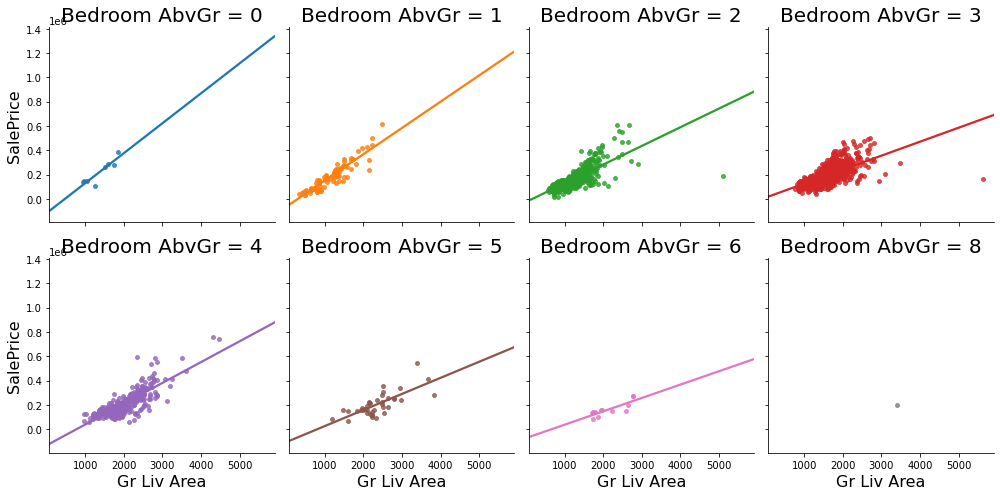

0    1412
1     980
2      34
3       2
Name: Bsmt Full Bath, dtype: int64


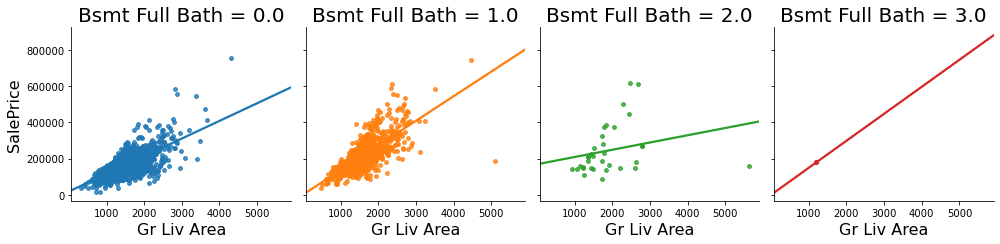

0    2285
1     140
2       3
Name: Bsmt Half Bath, dtype: int64


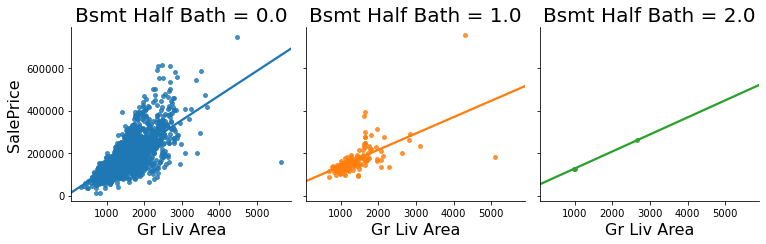

0    1186
1    1054
2     179
3      10
4       1
Name: Fireplaces, dtype: int64


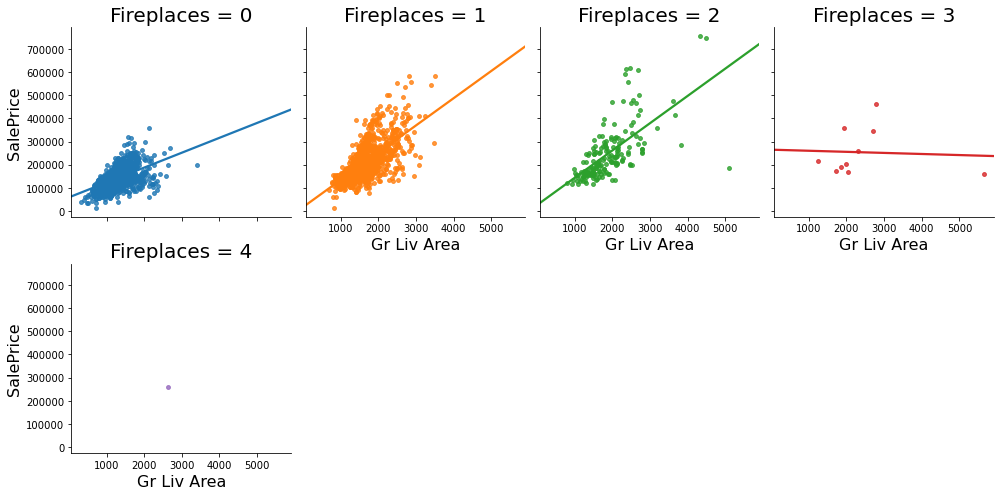

2    1273
1    1097
3      46
0      11
4       3
Name: Full Bath, dtype: int64


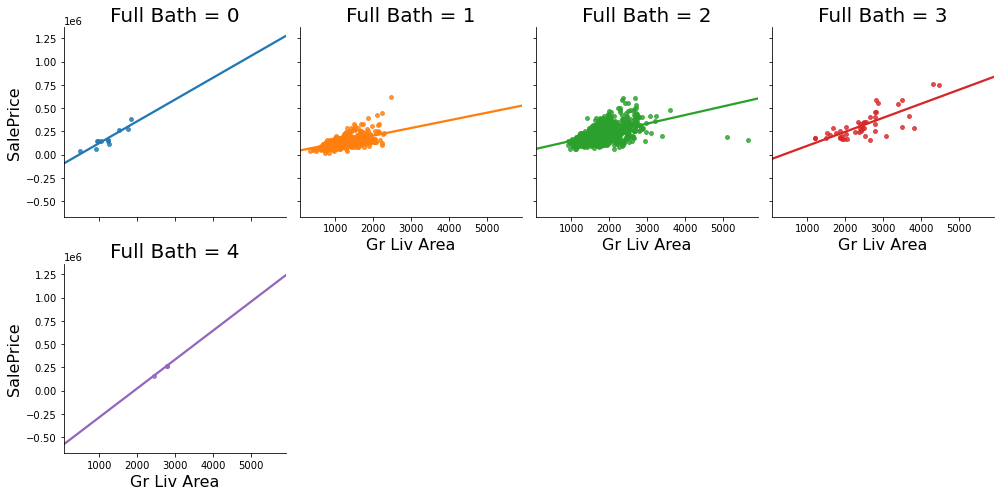

2    1340
1     635
3     306
0     136
4      12
Name: Garage Cars, dtype: int64


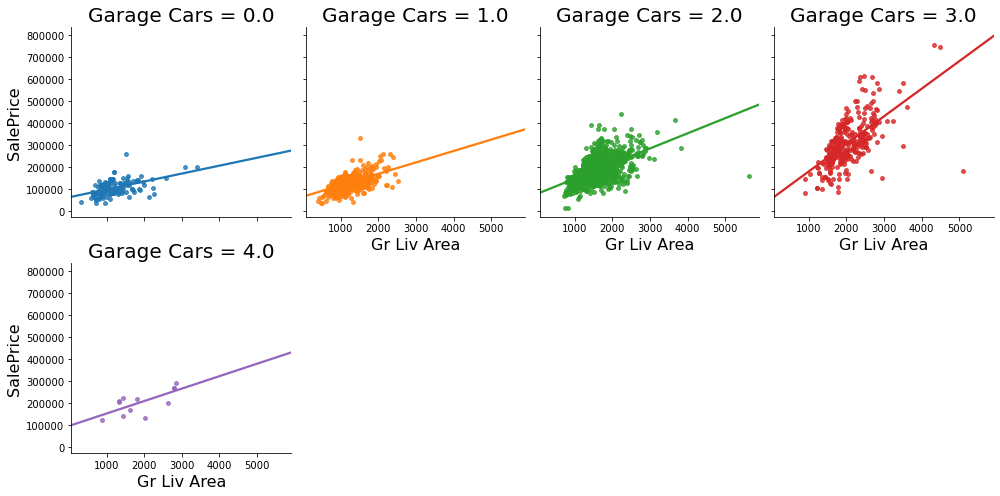

0    1554
1     854
2      22
Name: Half Bath, dtype: int64


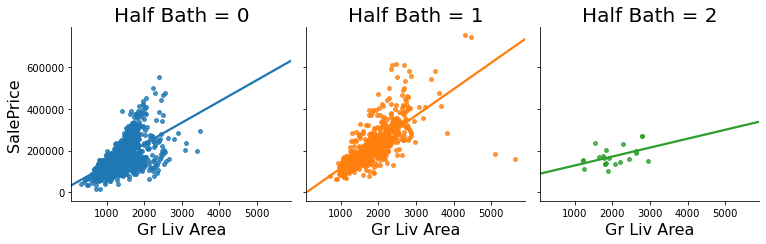

1    2323
2     104
0       2
3       1
Name: Kitchen AbvGr, dtype: int64


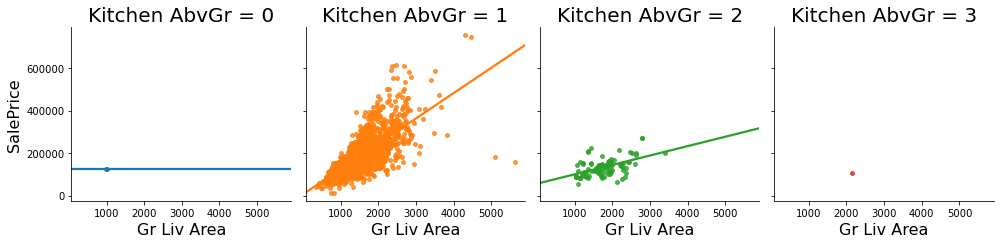

20     912
60     470
50     231
120    159
30     119
70     107
160    103
80      94
90      86
190     55
85      41
75      19
45      15
180     14
40       4
150      1
Name: MS SubClass, dtype: int64


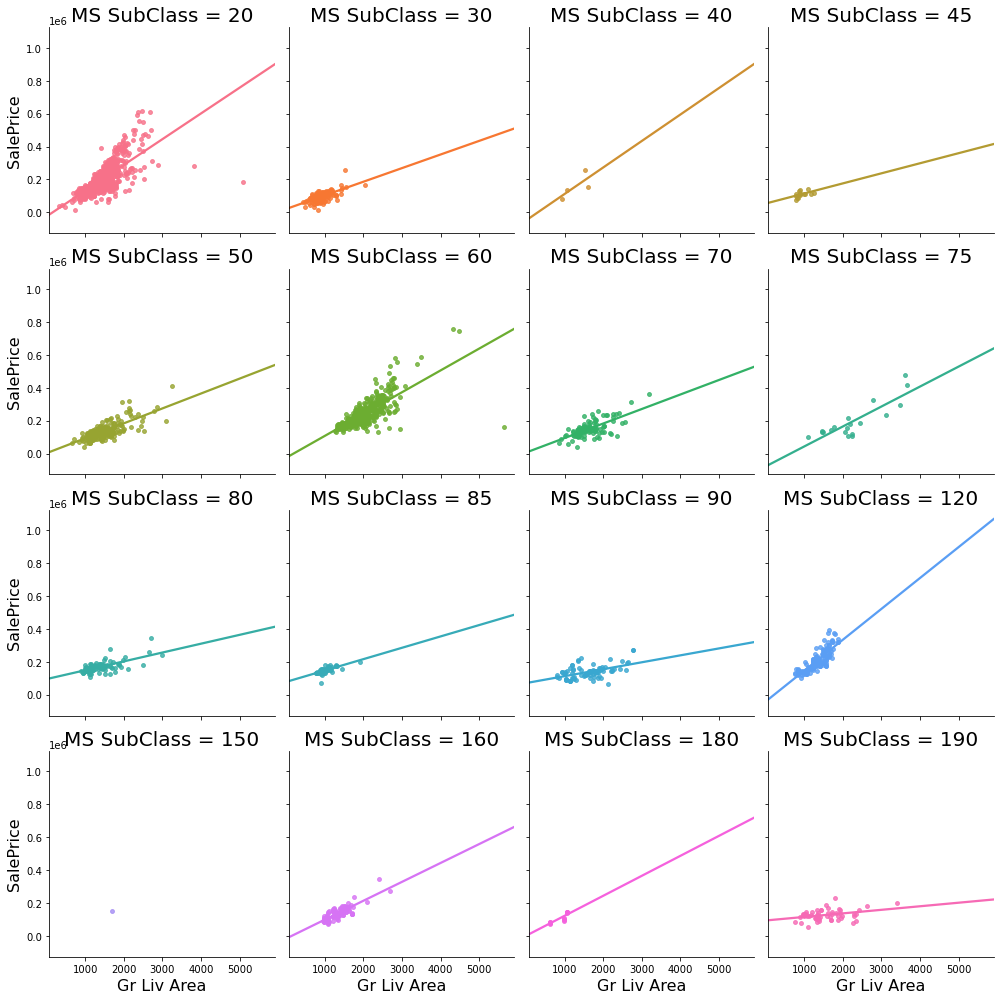

6     422
7     374
5     335
4     227
3     187
8     186
10    143
9     135
11    112
2     109
1     108
12     92
Name: Mo Sold, dtype: int64


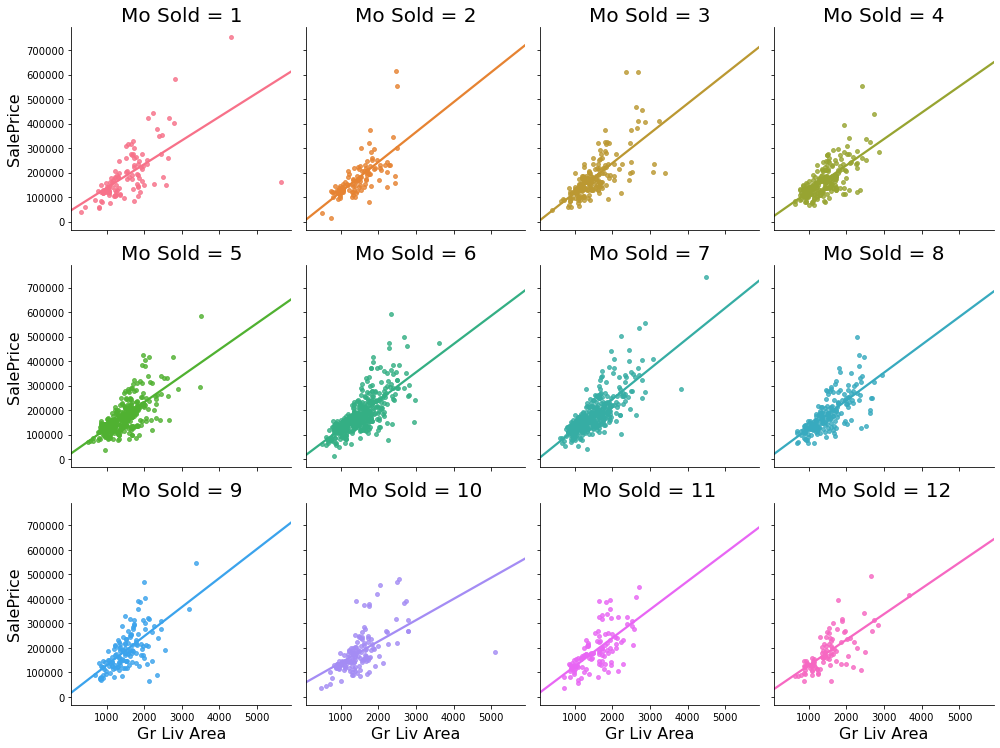

5    1367
6     448
7     322
8     125
4      78
3      41
9      33
2      10
1       6
Name: Overall Cond, dtype: int64


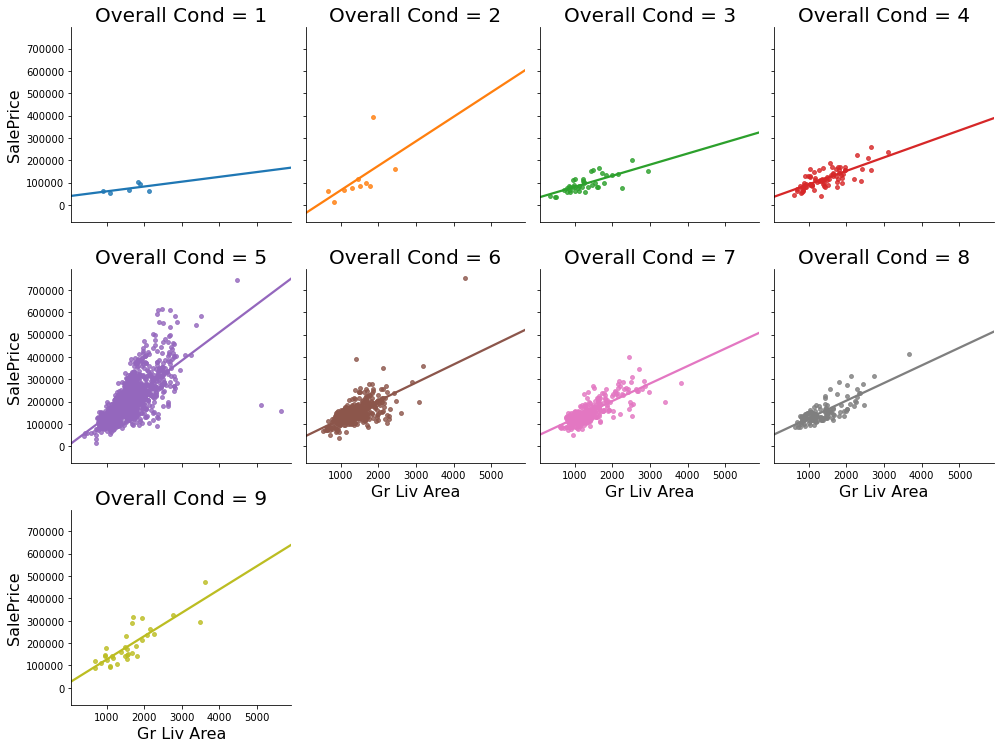

5     690
6     608
7     503
8     277
4     181
9      96
3      35
10     24
2      12
1       4
Name: Overall Qual, dtype: int64


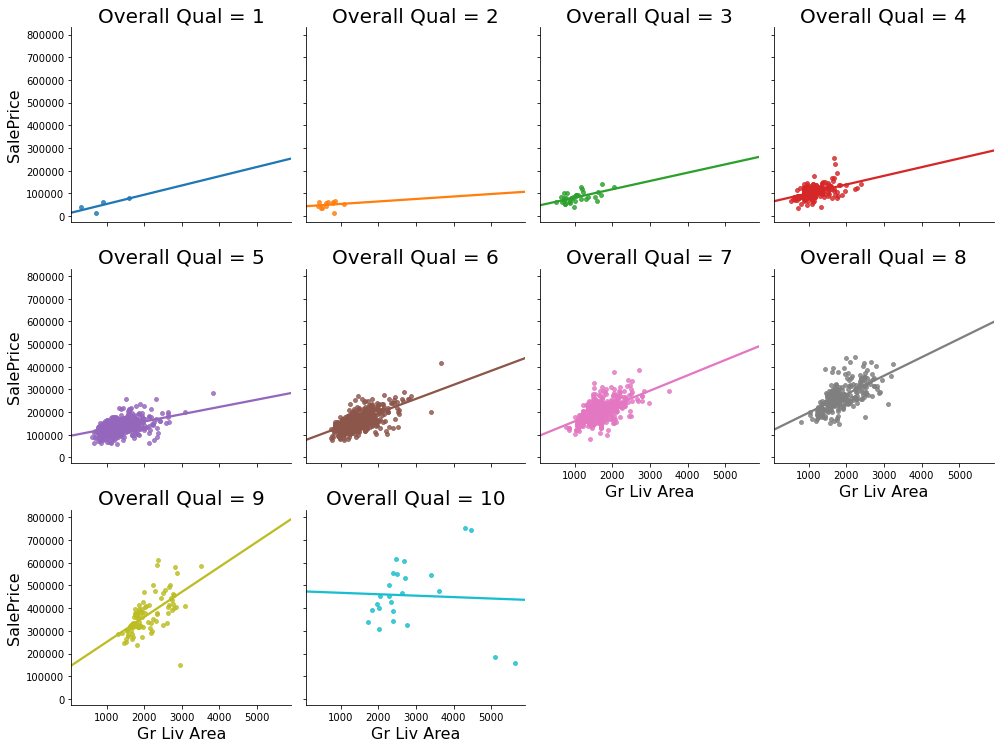

6     700
7     537
5     501
8     281
4     170
9     122
10     60
11     22
3      22
12     11
15      1
13      1
14      1
2       1
Name: TotRms AbvGrd, dtype: int64


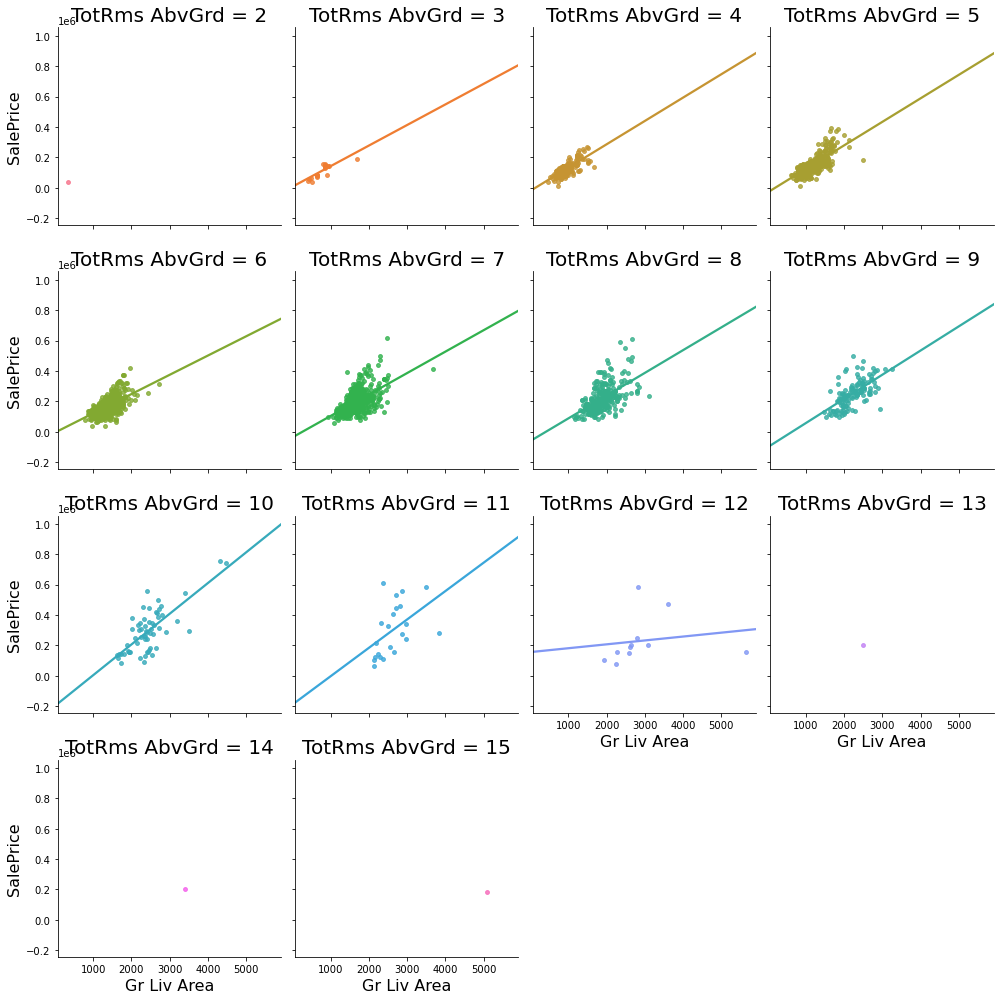

2007    584
2008    530
2009    518
2006    514
2010    284
Name: Yr Sold, dtype: int64


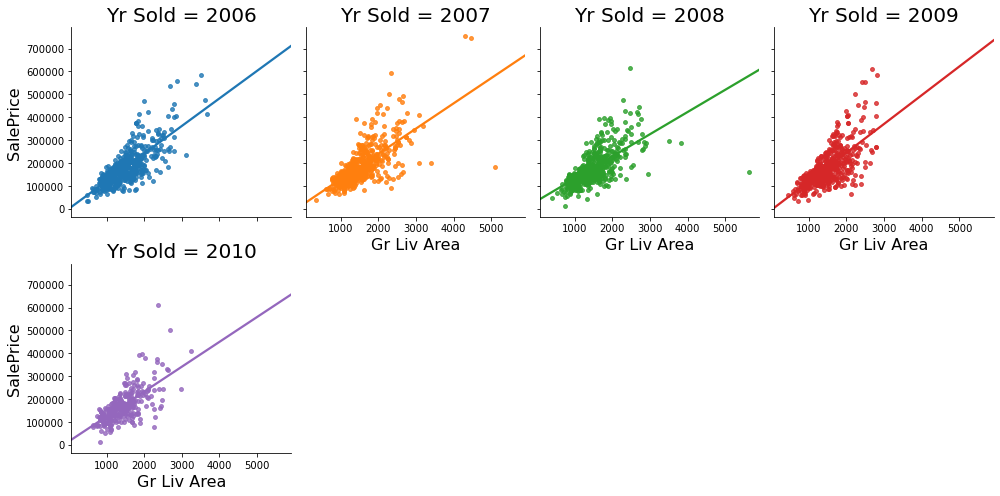

In [58]:
to_remove = ['Garage Yr Blt','Year Built','Year Remod/Add']
ds = [x for x in descrete if x not in to_remove]

for col in ds:
    
    df = data_df.copy()
    
    print(df[col].value_counts())

    plot = sns.lmplot(
        x="Gr Liv Area", y="SalePrice", col=col, hue=col,
        data=df[df[col].notna()], robust=False, col_wrap=4, ci=None, truncate=None, scatter_kws={"s": 15}, height=3.5, aspect=1,
    )
    # Adjust font sizes.
    for ax in plot.axes:
        ax.set_title(ax.get_title(), fontsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=16)
        ax.set_ylabel(ax.get_ylabel(), fontsize=16)

    plt.tight_layout()
    plt.show()   

---
    We see better from the above plots that each unique value of the descrete feautures, except from ('Year Built', 'Year Remod/Add', 'Garage Year Blt'), has a different slop when fiting the data of Gr Liv Area' as a function of the 'Saleprice'. I will check below if encoding these features into dummies will improve a model or not. 
---

---
### **6. Experimentation continuous + descrete features**
---

---
#### **6.1 Add descrete features together with continuous**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      14,897.79     14,936.17      0.91     0.83

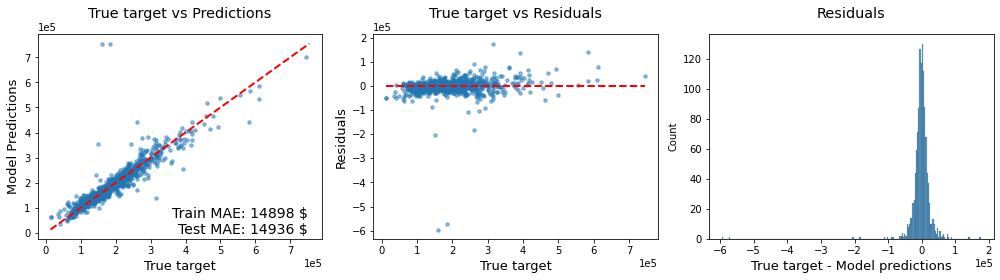

In [59]:
X = data_df[continuous + descrete]
y = data_df['SalePrice'] 

# Define preprocessing
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),   
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),      
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('scaler', StandardScaler())
])

# Define the model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor = WithoutOutliersRegressor(
                        outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                        regressor = Ridge()),
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)    
    )
                     
)

# Fit and get metrics from predictions
desc1 = fit_pipe(X, y, model)

---

    By just adding the descrete variables and performing some cleaning the test MAE was improved by ~8000$ wrt the last test with the continuous variables (22948$)
---

---
#### **6.2 Assemble Data Sold from month and year sold vars**
---

In [60]:
import datetime as dt


class AddDateSold(BaseEstimator, TransformerMixin):
    def __init__(self, drop_month_year_columns=False):
        self.columns = []
        self.drop_month_year_columns = drop_month_year_columns

            
    def preprocess_f(self, X_df):
        
        # Work on a copy
        X_df = X_df.copy()

        # Join month and year as string into a new column
        X_df['Date Sold'] = X_df[['Mo Sold', 'Yr Sold']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')

        # Convert it to datatime object
        X_df['Date Sold'] = pd.to_datetime(X_df['Date Sold'])

        # Convert the datatime to ordinal for linear regression
        X_df['Date Sold'] = X_df['Date Sold'].map(dt.datetime.toordinal)
        
        
        if self.drop_month_year_columns==True:
            X_df = X_df.drop(columns=['Mo Sold', 'Yr Sold'], axis=1)
        
        return X_df

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        self.columns = X_reindexed.columns

        return X_reindexed
    
    def get_features_name(self):
        return self.columns

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      14,897.80     14,936.16      0.91     0.83

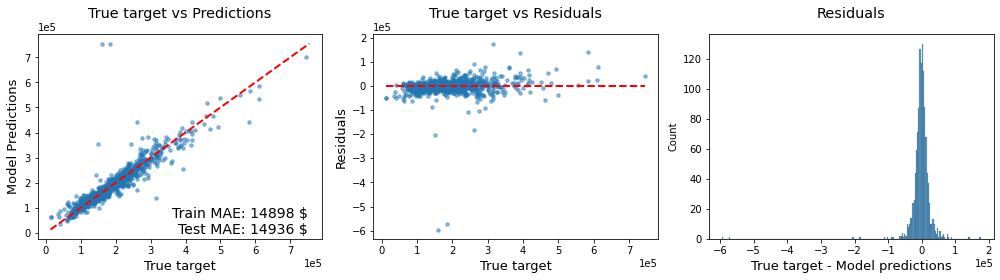

In [61]:
X = data_df[continuous + descrete]
y = data_df['SalePrice'] 

# Define the preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),        
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),    
    ('add_date_sold', AddDateSold(drop_month_year_columns=False)),
    ('scaler', StandardScaler()),
])

# Define the model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor = WithoutOutliersRegressor(
                        outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                        regressor = Ridge()),
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)    
    )
                     
)

# Fit and get metrics from predictions
desc2 = fit_pipe(X, y, model)

---
    The date does not chance at lot the test MAE wrt the previous test.
---

---
#### **6.3 Keep Data Sold and drop month and year sold vars**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      14,895.11     14,947.05      0.91     0.83

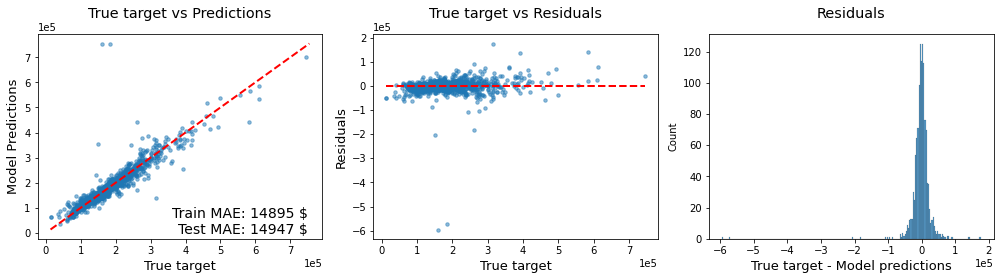

In [62]:
X = data_df[continuous + descrete]
y = data_df['SalePrice'] 

# Define the preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),   
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),         
    ('add_date_sold', AddDateSold(drop_month_year_columns=True)),
    ('scaler', StandardScaler()),
])

# Define the model
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor = WithoutOutliersRegressor(
                        outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                        regressor = Ridge()),
        transformer = QuantileTransformer(output_distribution='normal', random_state=0)    
    )
                     
)
# Fit and get metrics from predictions
desc3 = fit_pipe(X, y, model)

---
    By keeping the date and removing the month and year features the test MAE was increased by ~10$. So these two features should be kept. 
---

---
#### **6.4 Convert descrete values into dummies except: 'Garage Yr Blt', 'Year Built', 'Year Remod/Add', 'Date Sold'**
---

In [63]:
class DummiesPreprocessorForDescrete(BaseEstimator, TransformerMixin):
    def __init__(self, only_dummy_for_SubClass=False):
        self.to_convert_ = ['Bedroom AbvGr', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplaces','Full Bath','Garage Cars',
                            'Half Bath', 'Kitchen AbvGr', 'MS SubClass', 'TotRms AbvGrd']  
        self.subclass_to_convert = ['MS SubClass']
        self.only_dummy_for_SubClass = only_dummy_for_SubClass
        self.columns = []
            
    def preprocess_f(self, X_df):
        
        # Work on a copy
        X_df = X_df.copy()

        # Explicitely convert to string values
        convert_f = lambda x: str(int(x)) if not np.isnan(x) else np.nan
        
        if self.only_dummy_for_SubClass == False:   
            # Convert first the values to str
            X_df[self.to_convert_] = X_df[self.to_convert_].applymap(convert_f)
            # One-hot encoding
            X_df = pd.get_dummies(X_df, columns=self.to_convert_, dtype=np.int64) 
        else:
            # Convert first the values to str
            X_df[self.subclass_to_convert] = X_df[self.subclass_to_convert].applymap(convert_f)
            # One-hot encoding
            X_df = pd.get_dummies(X_df, columns=self.subclass_to_convert, dtype=np.int64)            
        
        return X_df

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        self.columns = X_reindexed.columns

        return X_reindexed
    
    def get_features_name(self):
        return self.columns    

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      14,399.58     14,874.52      0.92     0.84

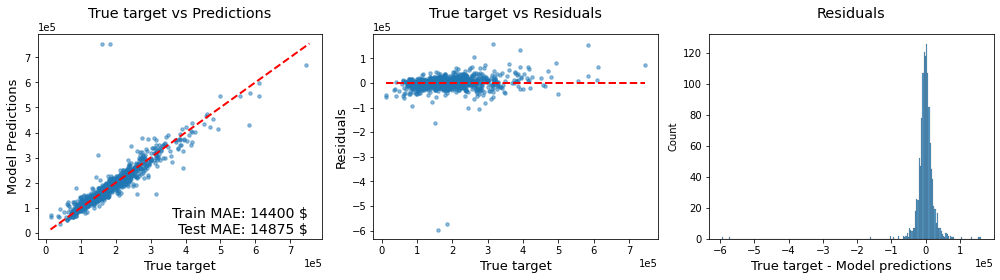

In [64]:
X = data_df[continuous + descrete]
y = data_df['SalePrice'] 

# Define the preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    ('descrete_to_dummies', DummiesPreprocessorForDescrete()),
    ('scaler', StandardScaler())
])

# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get prediction metrics
desc4 = fit_pipe(X, y, model)

---
    A further reduction of ~60$ in the test MAE was achieved by converting most of the discrete features to dummies. However, we will see later, when adding the nominal and ordinal features, that this conversion does not help.
---

---
#### **6.5 Convert only MS SubClass to dummies**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      14,607.62     14,939.28      0.92     0.83

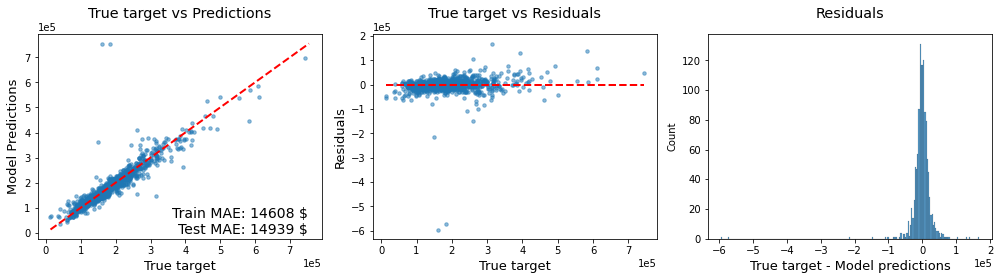

In [65]:
X = data_df[continuous + descrete]
y = data_df['SalePrice'] 

# Define the preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    ('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=True)),
    ('scaler', StandardScaler()),
])

# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get prediction metrics
desc5 = fit_pipe(X, y, model)

---
    Converting only the MS SubClass to dummies there is a subtle difference wrt the test performed at 6.2
---

---
#### **6.6 Create indicator variables**
---

In [66]:
class IndicatorVarPreprocessor(BaseEstimator, TransformerMixin):
    
    '''
    Built some indicator variables
    '''
    
    def __init__(self):
        self.columns = []
            
    def preprocess_f(self, X_df):
        
        # Work on a copy
        X_df = X_df.copy()
        
        # adapted from https://github.com/webartifex/ames-housing/blob/main/02_descriptive_visualizations.ipynb
        X_df['Years_since_built'] = X_df['Yr Sold'] - X_df['Year Built']
        X_df['Years_since_remodeled'] = X_df['Yr Sold'] - X_df['Year Remod/Add']  
        
        X_df['Recently_built'] = X_df['Years_since_built'].apply(lambda x: 1 if x <= 10 else 0)
        X_df['Recently_remodeled'] = X_df['Years_since_remodeled'].apply(lambda x: 1 if x <= 10 else 0)    
        
       # cols_to_drop = ['Years_since_built', 'Years_since_remodeled']
       # for col in cols_to_drop:
       #     if col in X_df.columns:    
       #         X_df = X_df.drop(col, axis=1)
                
        return X_df

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        # Save columns
        self.columns = X_reindexed.columns

        return X_reindexed
    
    def get_features_name(self):
        return self.columns    

---
#### **6.6.1 Check indicator vars**
---

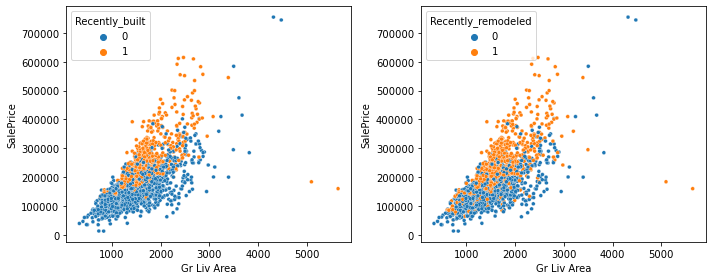

In [67]:
df_test = data_df[descrete + ['Gr Liv Area', 'SalePrice']].copy()
indvars = IndicatorVarPreprocessor()
df_test_processed = indvars.fit_transform(df_test)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.scatterplot(x='Gr Liv Area', y='SalePrice', hue='Recently_built', s=15, data=df_test_processed, ax=ax[0]);
sns.scatterplot(x='Gr Liv Area', y='SalePrice', hue='Recently_remodeled', s=15, data=df_test_processed, ax=ax[1]);

plt.tight_layout()
plt.show()

---
#### **6.6.2 Check model**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      14,316.92     14,931.07      0.92     0.84

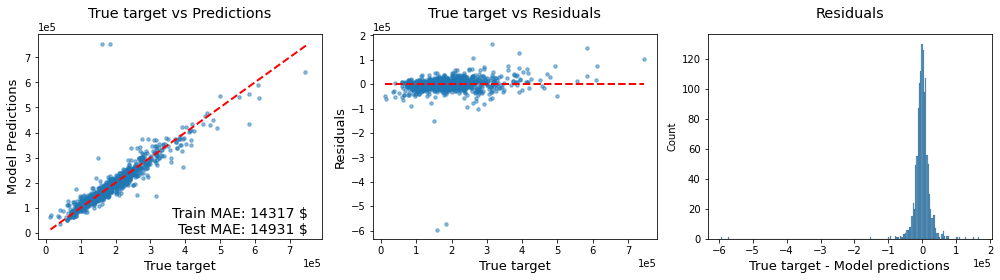

In [68]:
X = data_df[continuous + descrete]
y = data_df['SalePrice'] 

# Define preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    ('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=False)),
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    ('scaler', StandardScaler())
])


# Define model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get metrics from predictions
desc6 = fit_pipe(X, y, model)

---
    Keeping the dummies for most of the discrete variables and adding the indicator variables 'Recently built' and 'Recently remodeled' it seems that there is an increase of the test MAE by ~60$. 
---

---
## **Summary for the Descrete Features**
---

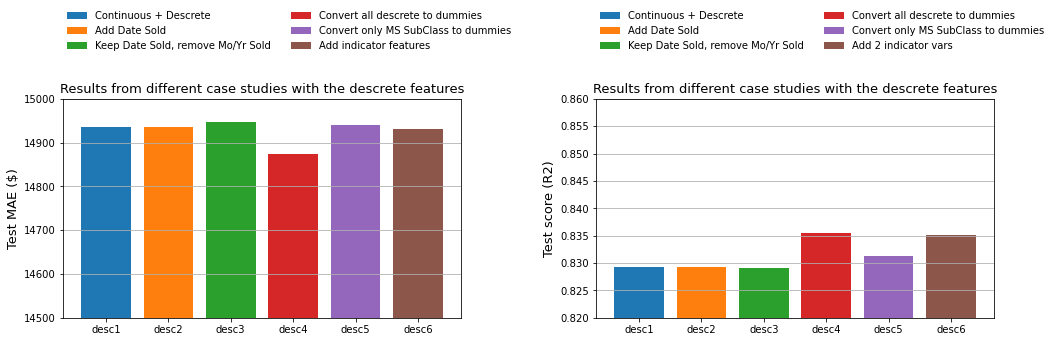

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].bar('desc1', np.int(np.round(desc1['test_mae ($)'].to_list()[0])), label='Continuous + Descrete')
ax[0].bar('desc2', np.int(np.round(desc2['test_mae ($)'].to_list()[0])), label='Add Date Sold')
ax[0].bar('desc3', np.int(np.round(desc3['test_mae ($)'].to_list()[0])), label='Keep Date Sold, remove Mo/Yr Sold')
ax[0].bar('desc4', np.int(np.round(desc4['test_mae ($)'].to_list()[0])), label='Convert all descrete to dummies')
ax[0].bar('desc5', np.int(np.round(desc5['test_mae ($)'].to_list()[0])), label='Convert only MS SubClass to dummies')
ax[0].bar('desc6', np.int(np.round(desc6['test_mae ($)'].to_list()[0])), label='Add indicator features')
ax[0].set_title('Results from different case studies with the descrete features', fontsize=13)
ax[0].set_ylabel('Test MAE ($)', fontsize=13)
ax[0].legend(loc='lower left', bbox_to_anchor= (0.0, 1.2), ncol=2, borderaxespad=0, frameon=False)
ax[0].set_ylim(14500,15000)
ax[0].grid(axis='y')

ax[1].bar('desc1', desc1['test_R2'].to_list()[0], label='Continuous + Descrete')
ax[1].bar('desc2', desc2['test_R2'].to_list()[0], label='Add Date Sold')
ax[1].bar('desc3', desc3['test_R2'].to_list()[0], label='Keep Date Sold, remove Mo/Yr Sold')
ax[1].bar('desc4', desc4['test_R2'].to_list()[0], label='Convert all descrete to dummies')
ax[1].bar('desc5', desc5['test_R2'].to_list()[0], label='Convert only MS SubClass to dummies')
ax[1].bar('desc6', desc6['test_R2'].to_list()[0], label='Add 2 indicator vars')
ax[1].set_title('Results from different case studies with the descrete features', fontsize=13)
ax[1].set_ylabel('Test score (R2)', fontsize=13)
ax[1].legend(loc='lower left', bbox_to_anchor= (0.0, 1.2), ncol=2, borderaxespad=0, frameon=False)
ax[1].set_ylim(0.82,0.86)
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

---
    From all the tests perfomed at this step the differemces in the test MAE is <100$. It seems here that the only thing that could improve the test MAE is converting most of the discrete variables to dummies. But we will see later when adding the nominal and ordinal features this will not be any more the case. 
---

---
# <font color="blue">**D. Nominal Features**</font>
---

### **1. Check missing values**
---

In [70]:
calc_nulls(data_df[nominal])

Missing values  Percentage (%)    Type
Misc Feature            2340           96.30  object
Alley                   2267           93.29  object
Garage Type              136            5.60  object
Mas Vnr Type              20            0.82  object
Electrical                 1            0.04  object

In [71]:
data_df.loc[data_df['Misc Feature'].isnull(), 'Misc Val'].to_frame().describe().T

count  mean  std  min  25%  50%  75%  max
Misc Val 2,340.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00

In [72]:
data_df.loc[data_df['Garage Type'].isnull(), 'Garage Area'].to_frame().describe().T

count  mean  std  min  25%  50%  75%  max
Garage Area 136.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00

In [73]:
data_df.loc[data_df['Mas Vnr Type'].isnull(), 'Mas Vnr Area'].to_frame().describe().T

count  mean  std  min  25%  50%  75%  max
Mas Vnr Area   0.00   nan  nan  nan  nan  nan  nan  nan

In [74]:
data_df.loc[data_df['Electrical'].isnull(), 'Year Built'].to_frame()

Year Built
694        2006

In [75]:
data_df.loc[data_df['Year Built']>=2006, 'Electrical'].value_counts()

SBrkr    258
Name: Electrical, dtype: int64

---
    From the above, we can replace the missing entries of:
        - Misc Feature, Garage Type, Mas Vnr Type with NA
        - Electrical with the 'SBrkr' type since all the dwellings since 2006 use this type of electricity. 
---

---
### **2. Check unique values**
---

In [76]:
# Create a dictionary with the unique values per feature as described in the documentation

dict_nominal_docum = {'MS Zoning':     ['A', 'C', 'FV' ,'I', 'RH','RL', 'RP', 'RM'],
                      'Street':        ['Grvl', 'Pave'],
                      'Alley':         ['Grvl', 'Pave','NA'],
                      'Land Contour':  ['Lvl','Bnk', 'HLS','Low'],
                      'Lot Config':    ['Inside','Corner','CulDSac','FR2', 'FR3'],
                      'Neighborhood':  ['Blmngtn','Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards','Gilbert',
                                        'Greens','GrnHill','IDOTRR','Landmrk','MeadowV','Mitchel','Names','NoRidge','NPkVill',
                                        'NridgHt','NWAmes','OldTown','SWISU','Sawyer','SawyerW','Somerst','StoneBr','Timber','Veenker'],
                      'Condition 1':   ['Artery', 'Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],
                      'Condition 2':   ['Artery', 'Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],
                      'Bldg Type':     ['1Fam','2FmCon','Duplx','TwnhsE','TwnhsI'],
                      'House Style':   ['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl'],
                      'Roof Style':    ['Flat','Gable','Gambrel','Hip','Mansard','Shed'],
                      'Roof Matl':     ['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl'],
                      'Exterior 1st':  ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other',
                                       'Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],
                      'Exterior 2nd':  ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other',
                                        'Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],
                      'Mas Vnr Type':  ['BrkCmn','BrkFace','CBlock','None','Stone'],
                      'Foundation':    ['BrkTil','CBlock','PConc','Slab','Stone','Wood'],
                      'Heating':       ['Floor','GasA','GasW','Grav','OthW','Wall'],
                      'Central Air':   ['N','Y'],
                      'Electrical':    ['SBrkr','FuseA','FuseF','FuseP', 'Mix'],
                      'Garage Type':   ['2Types','Attchd','Basment','BuiltIn','CarPort','Detchd','NA'],
                      'Misc Feature':  ['Elev','Gar2','Othr','Shed','TenC','NA'],
                      'Sale Type':     ['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth'],
                      'Sale Condition':['Normal','Abnorml','AdjLand','Alloca','Family','Partial']}

In [77]:
# Function to read unique values from a dataframe and append it to a dictionary
def make_dict_from_df(df, col_list):
    
    df_dict = {}
    
    for col in col_list:
        df_dict[col] = sorted(df[col].dropna().unique(), key=str.lower)

        
    return  df_dict   

In [78]:
# Make the dictionary from the unique values of the dataframe
dict_nominal_df = make_dict_from_df(data_df, nominal)

In [79]:
# Function to compare two dictionaries. The one defined according to the documentation and one from the unique values of each feature in the dataframe
def dict_compare(dict1, dict2):
    
    for key, values in dict1.items():
        key_name = key
        ls_val = sorted(values, key=str.lower)

        up_dict = {key_name:ls_val}
        dict1.update(up_dict)

        
    
    diffkeys = [k for k in dict1 if dict1[k] != dict2[k]]
    
    for k in diffkeys:
        print('docum[', k, ']:', dict1[k])
        print('dataf[', k, ']:', dict2[k],'\n')

In [80]:
print('-------------------------------------------')
print('Comparing unique values of nominal features:')
print('-------------------------------------------')
dict_compare(dict_nominal_docum, dict_nominal_df)

-------------------------------------------
Comparing unique values of nominal features:
-------------------------------------------
docum[ MS Zoning ]: ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RM', 'RP']
dataf[ MS Zoning ]: ['A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM'] 

docum[ Alley ]: ['Grvl', 'NA', 'Pave']
dataf[ Alley ]: ['Grvl', 'Pave'] 

docum[ Neighborhood ]: ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR', 'Landmrk', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'SWISU', 'Timber', 'Veenker']
dataf[ Neighborhood ]: ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR', 'Landmrk', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'SWISU', 'Timber', 'Veenker'] 

d

---
    For the nominal features we have inconsistencies wrt the documentation in the following:
        * [MS Zoning]: 'A (agr)', 'C (all)', 'I (all)' instead of 'A', 'C', 'I'
        * [Neighborhood]: 'Names' instead of 'NAmes'
        * [Bldg Type]: '2fmCon', 'Duplex', 'Twnhs' instead of '2FmCon', 'Duplx', 'TwnhsI'
        * [Exterior 2nd]: 'Brk Cmn','CmentBd', 'Wd Shng' instead of 'BrkComm', 'CemntBd', 'WdShing'
    
    For the rest of the nominal features the differences are mostly 'NA' values or a few missing from the dataset. For e.g.
        * [MS Zoning]: there is no Residential Low Density Park (RP)
        * [Condition 2]: there is no residential within 200' of East-West Railroad (RRNe)
        * [Roof Matl]: there is no 'Roll' in the roof material
---

### **3. Custom preprocessor for replacing nulls and correcting inconsistencies.**
---

In [81]:
class CleaningPreprocessorNomVars(BaseEstimator, TransformerMixin):
    def __init__(self, clean_MSSubClass=False):
        self.nom_vars_na_ = ['Misc Feature', 'Alley', 'Garage Type'] 
        self.nom_vars_none_ = ['Mas Vnr Type']
        self.nom_vars_other_ = ['Electrical']
        self.clean_MSSubClass = clean_MSSubClass

    def preprocess_f(self, X_df):
        # Work on a copy
        X_df = X_df.copy()

        
        
        if (self.clean_MSSubClass==False): # With the first call of this function Clean only above     
         
            ##########################    
            # Missing values  
            ##########################                
            for c in self.nom_vars_na_:
                if c in X_df.columns:
                    X_df[c] = X_df[c].fillna('NA')

            for c in self.nom_vars_none_:
                if c in X_df.columns:
                    X_df[c] = X_df[c].fillna('None') 

            for c in self.nom_vars_other_:
                if c in X_df.columns:
                    X_df[c] = X_df[c].fillna('SBrkr')        

            #############################################################    
            # Inconsistencies 
            #############################################################   
            X_df['MS Zoning'] = X_df['MS Zoning'].replace(to_replace='A (agr)', value='A')
            X_df['MS Zoning'] = X_df['MS Zoning'].replace(to_replace='C (all)', value='C')
            X_df['MS Zoning'] = X_df['MS Zoning'].replace(to_replace='I (all)', value='I')

            X_df['Neighborhood'] = X_df['Neighborhood'].replace(to_replace='NAmes', value='Names')

            X_df['Bldg Type'] = X_df['Bldg Type'].replace(to_replace='2fmCon', value='2FmCon')
            X_df['Bldg Type'] = X_df['Bldg Type'].replace(to_replace='Duplex', value='Duplx')
            X_df['Bldg Type'] = X_df['Bldg Type'].replace(to_replace='Twnhs', value='TwnhsI')

            X_df['Exterior 2nd'] = X_df['Exterior 2nd'].replace(to_replace='Brk Cmn', value='BrkComm')
            X_df['Exterior 2nd'] = X_df['Exterior 2nd'].replace(to_replace='CmentBd', value='CemntBd')
            X_df['Exterior 2nd'] = X_df['Exterior 2nd'].replace(to_replace='Wd Shng', value='WdShing')

            X_df['Sale Type'] = X_df['Sale Type'].replace(to_replace='WD ', value='WD')      
        
        
        
        #############################################################    
        # Cleanning MS SubClass 
        #############################################################   
        else:
            ###################    
            # Year Built <=1945
            ###################            
            # 1Story correction: 
            mask = X_df.loc[(X_df['House Style_1Story']==1) & (X_df['Year Built']<=1945) &
                            (X_df['MS SubClass']==20)].index  
            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 30


            # 1.5Fin correction
            mask = X_df.loc[(X_df['House Style_1.5Fin']==1) & (X_df['Year Built']<=1945) &
                            ((X_df['MS SubClass']==30) | (X_df['MS SubClass']==45) | (X_df['MS SubClass']==70))].index
            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 50

            # 1.5Unf correction
            mask = X_df.loc[(X_df['House Style_1.5Unf']==1) & (X_df['Year Built']<=1945) &
                            ((X_df['MS SubClass']==30) | (X_df['MS SubClass']==50))].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 45

            # 2Story correction
            mask = X_df.loc[(X_df['House Style_2Story']==1) & (X_df['Year Built']<=1945) &
                            ((X_df['MS SubClass']==50) | (X_df['MS SubClass']==60) | (X_df['MS SubClass']==75))].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 70

            # 2.5Fin correction
            mask = X_df.loc[(X_df['House Style_2.5Fin']==1) & (X_df['Year Built']<=1945) &
                            (X_df['MS SubClass']==70)].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 75

            # 2.5Unf correction
            mask = X_df.loc[(X_df['House Style_2.5Unf']==1) & (X_df['Year Built']<=1945) &
                            (X_df['MS SubClass']==60) & (X_df['Bldg Type_2FmCon']==1)].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 190

            mask = X_df.loc[(X_df['House Style_2.5Unf']==1) & (X_df['Year Built']<=1945) &
                            (X_df['MS SubClass']==70) & (X_df['Bldg Type_1Fam']==1)].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 75     

            ##################    
            # Year Built >1945
            ##################
             # 1Story correction: 
            mask = X_df.loc[(X_df['House Style_1Story']==1) & (X_df['Year Built']>=1946) & (X_df['Bldg Type_1Fam']==1) &
                            ((X_df['MS SubClass']==30) | (X_df['MS SubClass']==190))].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 20

            # 2Story correction: 
            mask = X_df.loc[(X_df['House Style_2Story']==1) & (X_df['Year Built']>=1946) & (X_df['Bldg Type_1Fam']==1) &
                            ((X_df['MS SubClass']==20) | (X_df['MS SubClass']==70))].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 60

            # SFoyer correction: 
            mask = X_df.loc[(X_df['House Style_SFoyer']==1) & (X_df['Year Built']>=1946) & (X_df['Bldg Type_TwnhsE']==1) &
                               (X_df['MS SubClass']==120)].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 180

            # Slvl
            mask = X_df.loc[(X_df['House Style_SLvl']==1) & (X_df['Year Built']>=1946) & (X_df['Bldg Type_1Fam']==1) &
                               ((X_df['MS SubClass']==20) | (X_df['MS SubClass']==60))].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 80

            mask = X_df.loc[(X_df['House Style_SLvl']==1) & (X_df['Year Built']>=1946) & (X_df['Bldg Type_TwnhsE']==1) &
                               (X_df['MS SubClass']==160)].index

            if (len(mask.to_list())!=0):
                X_df.loc[mask,'MS SubClass'] = 180                    

        return X_df
      
    

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns_ = X_preprocessed.columns

        return self  

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns_, fill_value=0)

        return X_reindexed

---
### **4. Distribution of features and as a function of the SalePrice**
---

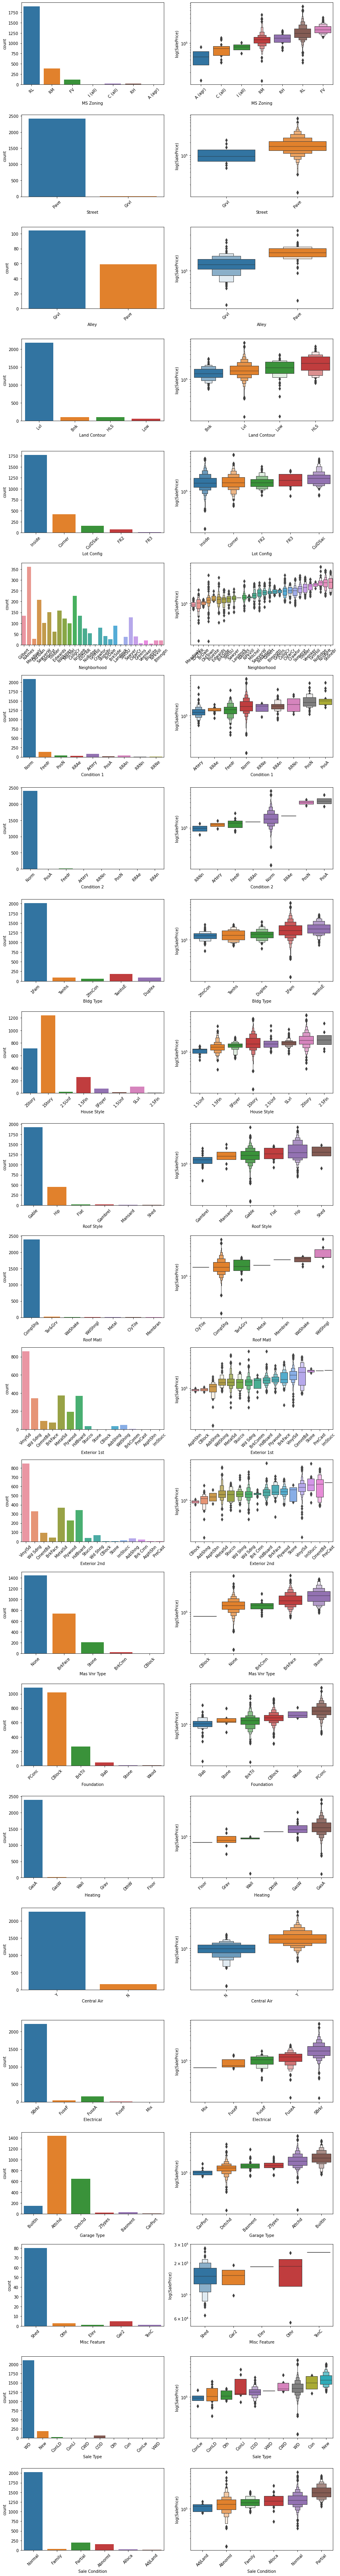

In [82]:
fig, ax = plt.subplots(nrows=len(nominal), ncols=2, figsize=(12, 90))


for row in range(0,len(nominal)):
       
    sns.countplot(x=nominal[row],data=data_df, ax=ax[row,0])
    ax[row,0].tick_params("x", labelrotation=45)
 
    order_list = data_df.groupby(nominal[row])['SalePrice'].median().sort_values(ascending=True).index
    sns.boxenplot(x=nominal[row], y='SalePrice', order=order_list, data=data_df, ax=ax[row,1])
    ax[row,1].set_yscale('log')
    ax[row,1].set_ylabel('log(SalePrice)')
    ax[row,1].tick_params("x", labelrotation=45)


plt.tight_layout()
plt.show()

---
    Most of the dwellings :

        * are 1, 1.5, 2 story 
        * are single-family Detached dwellings (Bldg Type)
        * are located in the Low Density Residential zone
        * have pave streer access to properties
        * have no alley
        * are built in a flat level
        * have an inside configuration
        * have normal Condition 1 and 2
        * have gable roof with standard (Composite) Shingle as material
        * GasA as heating
        * Central Air
        * Sbrkr electrical system
        * attached or detached garaga type
        * no other feature (Misc Feature)
        * were sold with Warranty Deed - Conventional in normal condition


    There is an exponential increase of SalePrice with :
        * MS Subclass
        * MS Zoning (Floating Village Residential being more expensive, agriculture land being the cheapest)
        * Land Contour (Houses in HillSide are more expensive on average)
        * Neighborhood
        * Condition 1(those that close to greenbelts or parks are more expensive than those that are close to Railroad)
        * Roof Style
        * Exterior Material 
        * Garage Type

    Information from columns:
        * Condition 1 and 2
        * Exterior 1st and 2nd

    can be merged after creating dummies to reduce the size of dummie variables since most of the entries seem to have the same information. 
---


#### **4.1 Check how many entries have 'Condition 1' = 'Condition 2' and 'Exterior 1st' = 'Exterior 2nd'**
---

In [83]:
print(data_df[['Condition 1', 'Condition 2']][data_df['Condition 1'] == data_df['Condition 2']].count())
print(data_df[['Exterior 1st', 'Exterior 2nd']][data_df['Exterior 1st'] == data_df['Exterior 2nd']].count())

Condition 1    2097
Condition 2    2097
dtype: int64
Exterior 1st    2078
Exterior 2nd    2078
dtype: int64


---
### **5. Experimentation**
---

#### **Create a preprocessor for dummies**
---

In [84]:
class DummiesPreprocessorNominal(BaseEstimator, TransformerMixin):
    def __init__(self, mergeConditions=False, mergeExterior=False, nomcolumns_=[], match_cols=True):
        self.columns = []
        self.nomcolumns_ = nomcolumns_
        self.conditions_ = ['Condition 1', 'Condition 2']
        self.exterior_ = ['Exterior 1st','Exterior 2nd']
        self.mergeConditions = mergeConditions
        self.mergeExterior = mergeExterior
        self.match_cols = match_cols
        
    def match_columns(self, X_df):
        miss_train = list(set(X_df.columns) - set(self.columns))
        miss_test = list(set(self.columns) - set(X_df.columns))
                
        if len(miss_test) > 0:
            for col in miss_test:
                X_df[col] = 0  # insert a column for the missing dummy

        if len(miss_train) > 0:
            for col in miss_train:
                del X_df[col]  # delete the column of the extra dummy
                
            
        return X_df        
        
    def merge_columns(self, X_df, col1, col2, prfx):
        
            # Copy columns to 2 new dataframes
            df1 = X_df[col1].copy()
            df2 = X_df[col2].copy()

            # Convert them to dummies with the same Prefix
            df1 = pd.get_dummies(df1, prefix=prfx, dtype=np.int64)
            df2 = pd.get_dummies(df2, prefix=prfx, dtype=np.int64)

            # Get column names except PIDs to check if a column is missing from one of the two dataframes
            df1_cols = df1.columns.to_list()
            df2_cols = df2.columns.to_list()

            # Convert list of columns to set() and check which is missing from the 2nd dataframe
            set1 = set(df1_cols)
            set2 = set(df2_cols)
            missing_from_df1 = list(sorted(set2 - set1))
            missing_from_df2 = list(sorted(set1 - set2))
            
            #print('df1-set1:', set1)
            #print('df2-set2:', set2)
            #print('missing_from_df1', missing_from_df1)
            #print('missing_from_df2', missing_from_df2)

            # if missing add the column and fill in with zeros
            if (len(missing_from_df1)>0):
                for col in missing_from_df1:
                    df1[col] = 0
                    
            if (len(missing_from_df2)>0):
                for col in missing_from_df2:
                    df2[col] = 0

            # Create a new dataframe with OR condition from independed ones
            df_OR = df1 | df2 # this will create dtypes utf8
            
            # Change type of columns
            #df_OR = df_OR.astype('int64')            

            # Merge dataframes
            df_merged = pd.merge(X_df, df_OR, left_index=True, right_index=True)
            
            #print(calc_nulls(df_merged))

            # Drop original columns from the dataframe
            df_merged = df_merged.drop([col1,col2], axis=1)
            
            X_df = df_merged

            return X_df         
        
        
            
    def preprocess_f(self, X_df):
        
        # Work on a copy
        X_df = X_df.copy()

       
        if ((self.mergeConditions==True) & (self.mergeExterior==False)):
            
            # Merge Condition columns
            X_df = self.merge_columns(X_df, 'Condition 1', 'Condition 2', 'Condition') 
            
            # One-hot encoding for the rest of the columns
            X_df = pd.get_dummies(X_df, columns=self.nomcolumns_ + self.exterior_, dtype=np.int64)            
            
        elif ((self.mergeExterior==True) & (self.mergeConditions==False)):
            
            # Merge Exterior columns 
            X_df = self.merge_columns(X_df, 'Exterior 1st','Exterior 2nd', 'Exterior')    
                                  
            # One-hot encoding for the rest of the columns
            X_df = pd.get_dummies(X_df, columns=self.nomcolumns_ + self.conditions_ , dtype=np.int64)  
            
        elif ((self.mergeExterior==True) & (self.mergeConditions==True)):
            
            # Merge Condition and Exstertior columns creating two new dataframes
            X_df1 = self.merge_columns(X_df, 'Condition 1', 'Condition 2', 'Condition') 
            X_df2 = self.merge_columns(X_df1, 'Exterior 1st','Exterior 2nd', 'Exterior')
                        
            # One-hot encoding for the rest of the columns
            X_df = pd.get_dummies(X_df2, columns=self.nomcolumns_, dtype=np.int64)
            
        else:
            cols = self.nomcolumns_ + self.conditions_ + self.exterior_
            X_df = pd.get_dummies(X_df, columns=cols, dtype=np.int64) 
        
        return X_df

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
       # assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        self.columns = X_reindexed.columns

        return X_reindexed
    
    def get_features_name(self):
        return self.columns   

---
#### **Test the dummy preprocessor**
---

In [85]:
df_nominal_test = data_df[continuous + descrete + nominal].copy()
df_nominal_test.shape

(2430, 59)

In [86]:
# List that holds the nominal features for dummies
cols_nom_for_dummies = ['MS Zoning', 'Street', 'Alley','Land Contour','Lot Config','Neighborhood', 'Bldg Type','House Style', 'Roof Style',
                        'Roof Matl','Mas Vnr Type','Foundation','Heating','Central Air','Electrical','Garage Type','Misc Feature','Sale Type','Sale Condition']

In [87]:
pipe = Pipeline([
    ('cleaning_preprocessor', CleaningPreprocessorNomVars()), 
    ('dummies',DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)) 
])

df_nominal_test_converted = pipe.fit_transform(df_nominal_test)
print('Shape = ', df_nominal_test_converted.shape)
df_nominal_test_converted.head()   

Shape =  (2430, 189)


Lot Frontage  Lot Area  Mas Vnr Area  BsmtFin SF 1  BsmtFin SF 2  \
0           nan      8795          0.00        300.00          0.00   
1         75.00     10170        522.00          0.00          0.00   
2         21.00      2001         80.00          0.00          0.00   
3         70.00     10552          0.00      1,018.00          0.00   
4         60.00     10120          0.00          0.00          0.00   

   Bsmt Unf SF  Total Bsmt SF  1st Flr SF  2nd Flr SF  Low Qual Fin SF  ...  \
0       652.00         952.00         980        1276                0  ...   
1       216.00         216.00        1575           0                0  ...   
2       546.00         546.00         546         546                0  ...   
3       380.00       1,398.00        1700           0                0  ...   
4       925.00         925.00         964         925                0  ...   

   Sale Type_New  Sale Type_Oth  Sale Type_VWD  Sale Type_WD  \
0              0              0              0             1   
1              0              0              0             1   
2              0              0              0             1   
3              0              0              0             1   
4              0              0              0             1   

   Sale Condition_Abnorml  Sale Condition_AdjLand  Sale Condition_Alloca  \
0                       0                       0                      0   
1                       0                       0                      0   
2                       0                       0                      0   
3                       0                       0                      0   
4                       0                       0                      0   

   Sale Condition_Family  Sale Condition_Normal  Sale Condition_Partial  
0                      0                      1                       0  
1                      0                      1                       0  
2                      0                      1                       0  
3                      0                      1                       0  
4                      0                      1                       0  

[5 rows x 189 columns]

---
#### **5.1 Test a Ridge model with all nominal + descrete + continuous**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      11,200.17     14,300.17      0.96     0.84

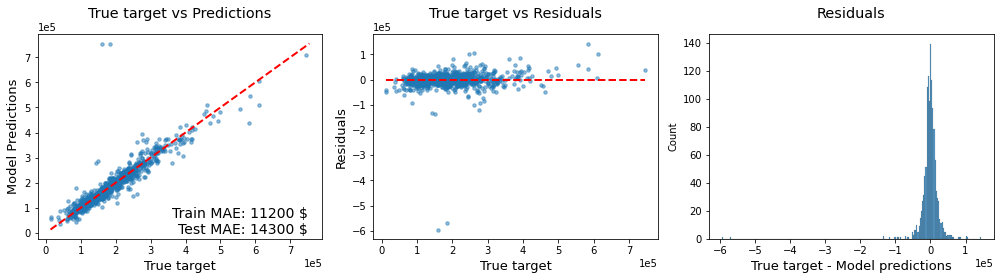

In [88]:
X = data_df[continuous + descrete + nominal]
y = data_df['SalePrice'] 

# Define preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=False, mergeExterior=False, nomcolumns_=cols_nom_for_dummies)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), # change to continuous now gave better results
    #('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    #('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=True)), 
    #('add_date_sold', AddDateSold(drop_month_year_columns=False)),
    ('scaler', StandardScaler())
])


# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get prediction metrics
nom1 = fit_pipe(X, y, model)

---
    Adding also the nominal features and by testing again the following steps in the pipeline:
        1) add_binary
        2) add_indicator_vars
        3) descrete_to_dummies
        4) add_date_sold
        
    the best test MAE was achieved by keeping only the indicator variables.
---

---
#### **5.2 Correcting inconsistencies in the MS SubClass**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      11,165.45     14,271.02      0.96     0.84

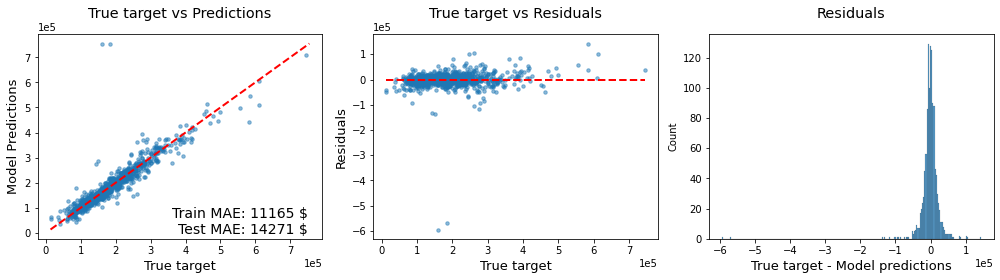

In [89]:
X = data_df[continuous + descrete + nominal]
y = data_df['SalePrice'] 

# Define preprocessor with different order of steps now
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=False, mergeExterior=False, nomcolumns_=cols_nom_for_dummies)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
   # ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    #('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=False)), 
   #('add_date_sold', AddDateSold(drop_month_year_columns=False)),
    ('scaler', StandardScaler())
])

# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get prediction metrics
nom2 = fit_pipe(X, y, model)

---
    By correcting inconsistencies in the MS SubClass there is an improvement of 30$ in the test MAE. 
---

---
#### **5.3 Test the model with only the Condition columns merged**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      11,588.08     14,095.69      0.95     0.84

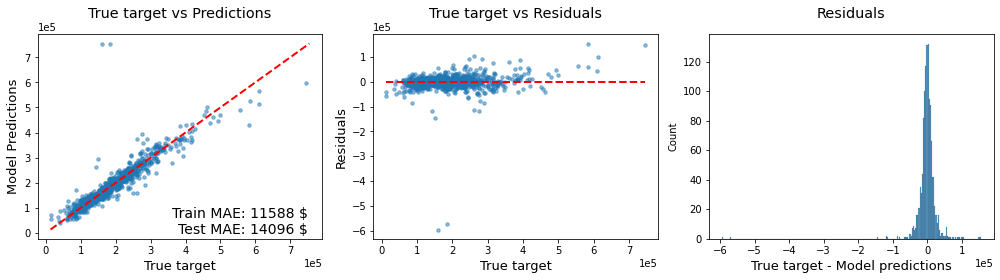

In [90]:
X = data_df[continuous + descrete + nominal]
y = data_df['SalePrice'] 

# Define preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=False, nomcolumns_=cols_nom_for_dummies)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
   # ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    #('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=False)), 
   #('add_date_sold', AddDateSold(drop_month_year_columns=False)),
])

# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get prediction metrics
nom3 = fit_pipe(X, y, model)

---
    A further reduction in the test MAE of ~170$ was achieved by merging only the Conditions columns.
---

---
#### **5.4 Test the model with Exterior columns merged**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      11,638.70     13,995.62      0.96     0.84

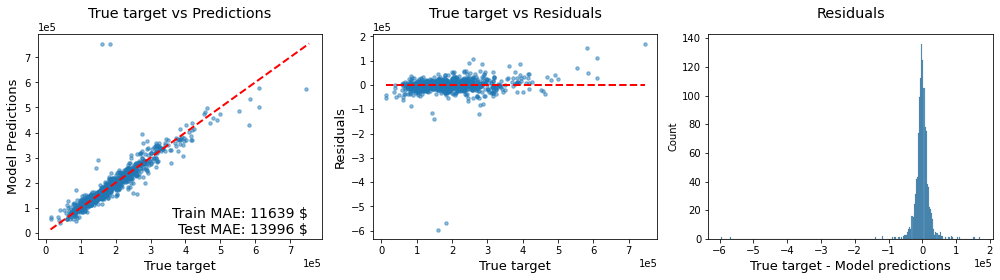

In [91]:
X = data_df[continuous + descrete + nominal].drop(['Pool Area', 'Misc Val'], axis=1)
y = data_df['SalePrice'] 

# Define preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=False, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
   # ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    #('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=False)), 
   #('add_date_sold', AddDateSold(drop_month_year_columns=False)),
])

# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get prediction metrics
nom4 = fit_pipe(X, y, model)

---
    A reduction in the test MAE of ~100$ was achieved by merging only the Exterior columns.
---

---
#### **5.5 Test the model with both Conditions and Exterior columns merged**
---

Outliers detected: 4 (0.3%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      11,674.44     13,958.90      0.96     0.84

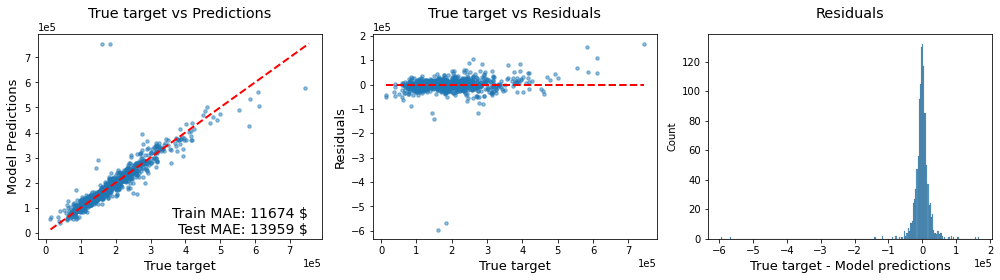

In [92]:
X = data_df[continuous + descrete + nominal].drop(['Pool Area', 'Misc Val'], axis=1)
y = data_df['SalePrice'] 

# Define preprocessor
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_descrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
   # ('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    #('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=False)), 
   #('add_date_sold', AddDateSold(drop_month_year_columns=False)),
])

# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0)
)

# Fit and get prediction metrics
nom5 = fit_pipe(X, y, model)

---
    Merging both Condition 1 and 2 and Exterior 1st and 2nd there is a reduction of 300$ in the test MAE.
---

---
## **Summary for the Nominal features**
---

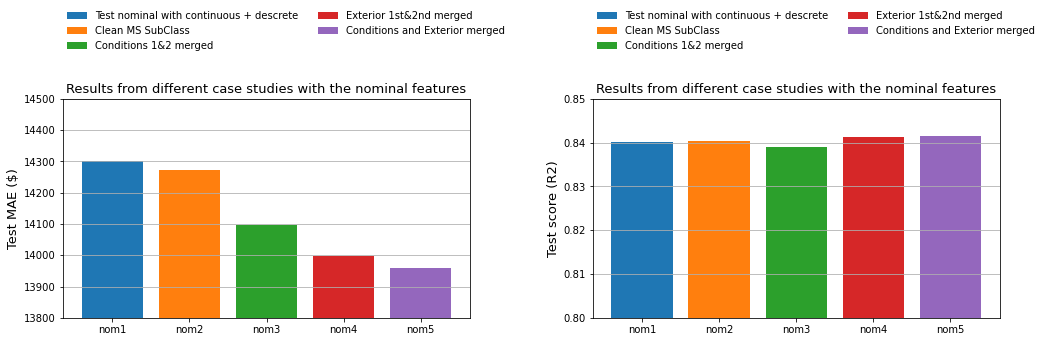

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        
ax[0].bar('nom1', np.int(np.round(nom1['test_mae ($)'].to_list()[0])), label='Test nominal with continuous + descrete')
ax[0].bar('nom2', np.int(np.round(nom2['test_mae ($)'].to_list()[0])), label='Clean MS SubClass')
ax[0].bar('nom3', np.int(np.round(nom3['test_mae ($)'].to_list()[0])), label='Conditions 1&2 merged')
ax[0].bar('nom4', np.int(np.round(nom4['test_mae ($)'].to_list()[0])), label='Exterior 1st&2nd merged')
ax[0].bar('nom5', np.int(np.round(nom5['test_mae ($)'].to_list()[0])), label='Conditions and Exterior merged')
ax[0].set_title('Results from different case studies with the nominal features', fontsize=13)
ax[0].set_ylabel('Test MAE ($)', fontsize=13)
ax[0].legend(loc='lower left', bbox_to_anchor= (0.0, 1.2), ncol=2, borderaxespad=0, frameon=False)
ax[0].set_ylim(13800,14500)
ax[0].grid(axis='y')

ax[1].bar('nom1', nom1['test_R2'].to_list()[0], label='Test nominal with continuous + descrete')
ax[1].bar('nom2', nom2['test_R2'].to_list()[0], label='Clean MS SubClass')
ax[1].bar('nom3', nom3['test_R2'].to_list()[0], label='Conditions 1&2 merged')
ax[1].bar('nom4', nom4['test_R2'].to_list()[0], label='Exterior 1st&2nd merged')
ax[1].bar('nom5', nom5['test_R2'].to_list()[0], label='Conditions and Exterior merged')
ax[1].set_title('Results from different case studies with the nominal features', fontsize=13)
ax[1].set_ylabel('Test score (R2)', fontsize=13)
ax[1].legend(loc='lower left', bbox_to_anchor= (0.0, 1.2), ncol=2, borderaxespad=0, frameon=False)
ax[1].set_ylim(0.8,0.85)
ax[1].grid(axis='y')

plt.tight_layout()
plt.show()

---
    From the tests performed for the nominal variable it seems that merging both the Conditions and Exterior features and corrected the inconsistencies in the MS Subclass the test MAE improves by ~340$.
---

---
---
# <font color="blue">**E. Ordinal Features**</font>
---
---

### **Check missing values**
---

In [94]:
calc_nulls(data_df[ordinal])

Missing values  Percentage (%)    Type
Pool QC                   2418           99.51  object
Fence                     1941           79.88  object
Fireplace Qu              1186           48.81  object
Garage Cond                138            5.68  object
Garage Finish              138            5.68  object
Garage Qual                138            5.68  object
Bsmt Exposure               74            3.05  object
BsmtFin Type 2              72            2.96  object
Bsmt Cond                   71            2.92  object
Bsmt Qual                   71            2.92  object
BsmtFin Type 1              71            2.92  object

--- 
#### **1. Pool QC, Fence, Fireplace Qu nulls**
---

In [95]:
print('__'*25, '\n');print('1. POOL QC');print('__'*25, '\n')
pool_all = data_df['Pool QC'].value_counts(dropna=False).to_frame()
pool_nulls = data_df.loc[data_df['Pool QC'].isnull(), 'Pool Area'].describe().to_frame()
display(pool_all.T, pool_nulls.T); print('\n')

# Fence
print('__'*25, '\n');print('2. FENCE');print('__'*25, '\n')
fence_all = data_df['Fence'].value_counts(dropna=False).to_frame()
display(fence_all.T); print('\n')

# Fireplace
print('__'*25, '\n');print('3. Fireplaces Qu');print('__'*25, '\n')
fireplace_all = data_df['Fireplace Qu'].value_counts(dropna=False).to_frame()
fireplace_nulls = data_df.loc[data_df['Fireplace Qu'].isnull(), 'Fireplaces'].describe().to_frame()
display(fireplace_all.T, fireplace_nulls.T)

__________________________________________________ 

1. POOL QC
__________________________________________________ 



NaN  Ex  Gd  TA  Fa
Pool QC  2418   4   3   3   2

count  mean  std  min  25%  50%  75%  max
Pool Area 2,418.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00



__________________________________________________ 

2. FENCE
__________________________________________________ 



NaN  MnPrv  GdPrv  GdWo  MnWw
Fence  1941    288     97    94    10



__________________________________________________ 

3. Fireplaces Qu
__________________________________________________ 



NaN   Gd   TA  Fa  Po  Ex
Fireplace Qu  1186  620  477  67  42  38

count  mean  std  min  25%  50%  75%  max
Fireplaces 1,186.00  0.00 0.00 0.00 0.00 0.00 0.00 0.00

---
    For the above 3 features we can replace the null values with 'NA' since:
       1) for the Pool Qc nulls the corresponding Pool Area is 0
       2) for the Fence it looks like there is no fence
       3) for the Fireplaces Qu nulls the corresponding Fireplaces are 0
---

--- 
#### **2. Garage nulls**
---

In [96]:
pd.options.display.float_format = "{:,.0f}".format

# Define a list with all the Garage columns
cols_grg = ['Garage Cond','Garage Qual','Garage Finish', 'Garage Area']

# Create a mask if any of the above are zero
mask = data_df[cols_grg].isnull().any(axis=1)
print('Nulls in any of :',cols_grg)
print(mask.value_counts())

# Create new masks based on the previous mask by checking the Garage Area
mask_area_zero = data_df[cols_grg][mask].loc[data_df['Garage Area'][mask]==0].index # when GarageArea = 0
mask_area_nzer = data_df[cols_grg][mask].loc[data_df['Garage Area'][mask]!=0].index # when GarageArea != 0


print('\nIf [Garage Area==0] :\n')
display(data_df.loc[mask_area_zero,cols_grg])

print('\nIf [Garage Area!=0] :\n')
display(data_df.loc[mask_area_nzer, cols_grg])

Nulls in any of : ['Garage Cond', 'Garage Qual', 'Garage Finish', 'Garage Area']
False    2292
True      138
dtype: int64

If [Garage Area==0] :



Garage Cond Garage Qual Garage Finish  Garage Area
16           NaN         NaN           NaN            0
48           NaN         NaN           NaN            0
62           NaN         NaN           NaN            0
73           NaN         NaN           NaN            0
76           NaN         NaN           NaN            0
...          ...         ...           ...          ...
2292         NaN         NaN           NaN            0
2308         NaN         NaN           NaN            0
2314         NaN         NaN           NaN            0
2354         NaN         NaN           NaN            0
2425         NaN         NaN           NaN            0

[136 rows x 4 columns]


If [Garage Area!=0] :



Garage Cond Garage Qual Garage Finish  Garage Area
1114         NaN         NaN           NaN          360
1565         NaN         NaN           NaN          nan

---
    - When the Garage Area is equal to 0 we can replace the missing values of the Garage features with 'NA'. This will replace the 136 nulls. 
    - For the other 2 entries we can fill in the missing values with the most frequent value
---

--- 
#### **3. Basement nulls**
---

In [97]:
# Create a list with the Basement columns
cols_bsmt = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 
             'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF']

# Create a mask if any of the above are zero
mask = data_df[cols_bsmt].isnull().any(axis=1)

print('Nulls in any of :',cols_bsmt)
print(mask.value_counts())

# Create new masks based on the previous mask by checking the Total Bsmt SF
mask_zero_tbsmt = data_df[cols_bsmt][mask].loc[data_df['Total Bsmt SF'][mask]==0].index # when Total Bsmt SF = 0
mask_nonzero_tbsmt = data_df[cols_bsmt][mask].loc[data_df['Total Bsmt SF'][mask]!=0].index # when Total Bsmt SF != 0

print('\nIf [Total Bsmt SF==0] :\n')
display(data_df.loc[mask_zero_tbsmt,cols_bsmt])

print('\nIf [Total Bsmt SF!=0] :\n')
display(data_df.loc[mask_nonzero_tbsmt, cols_bsmt])

Nulls in any of : ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
False    2355
True       75
dtype: int64

If [Total Bsmt SF==0] :



Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1 BsmtFin Type 2  \
35         NaN       NaN           NaN            NaN            NaN   
48         NaN       NaN           NaN            NaN            NaN   
75         NaN       NaN           NaN            NaN            NaN   
117        NaN       NaN           NaN            NaN            NaN   
152        NaN       NaN           NaN            NaN            NaN   
...        ...       ...           ...            ...            ...   
2292       NaN       NaN           NaN            NaN            NaN   
2347       NaN       NaN           NaN            NaN            NaN   
2375       NaN       NaN           NaN            NaN            NaN   
2380       NaN       NaN           NaN            NaN            NaN   
2396       NaN       NaN           NaN            NaN            NaN   

      BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  
35               0             0            0              0  
48               0             0            0              0  
75               0             0            0              0  
117              0             0            0              0  
152              0             0            0              0  
...            ...           ...          ...            ...  
2292             0             0            0              0  
2347             0             0            0              0  
2375             0             0            0              0  
2380             0             0            0              0  
2396             0             0            0              0  

[70 rows x 9 columns]


If [Total Bsmt SF!=0] :



Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1 BsmtFin Type 2  \
104        NaN       NaN           NaN            NaN            NaN   
602         Gd        TA            No            GLQ            NaN   
875         Gd        TA           NaN            Unf            Unf   
1681        Gd        TA           NaN            Unf            Unf   
1726        Gd        TA           NaN            Unf            Unf   

      BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  
104            nan           nan          nan            nan  
602          1,124           479        1,603          3,206  
875              0             0        1,595          1,595  
1681             0             0          725            725  
1726             0             0          936            936

---
    - When the Total Bsmt SF is either null or zero we can replace the nulls with 'NA':
    - When the Total Bsmt SF is not zero, since in all cases there is an area that is not finished, 
        1) the BsmtFin Type 2 null can be replaced with 'Unf' and 
        2) the Bsmt Exposure can be replaced with 'No'

---

--- 
### **Define the cleaning preprocessor**
---

In [98]:
class CleaningPreprocessorOrdVars(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ord_vars_na_ = ['Pool QC', 'Fence', 'Fireplace Qu'] 
        self.garage_vars_ = ['Garage Cond', 'Garage Qual', 'Garage Finish']
        self.basement_vars_ = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']


    def preprocess_f(self, X_df, train_idx_max):
        # Work on a copy
        X_df = X_df.copy()

        # For NA
        for col in self.ord_vars_na_:
            X_df[col] = X_df[col].fillna('NA')
            
        # For Garage Vars    
        mask = X_df[self.garage_vars_].isnull().all(axis=1)    
        mask_zero_area = X_df[self.garage_vars_][mask].loc[X_df['Garage Area'][mask]==0].index
        mask_nonzero_area = X_df[self.garage_vars_][mask].loc[X_df['Garage Area'][mask]!=0].index

        X_df.loc[mask_zero_area, self.garage_vars_] = 'NA'

        for i in range(0, len(self.garage_vars_)):
            X_df.loc[mask_nonzero_area, self.garage_vars_[i]] = train_idx_max[i]
        
        # For Basement nulls
        mask = X_df[self.basement_vars_].isnull().any(axis=1)   
        mask_zero_bsmt = X_df[self.basement_vars_][mask].loc[X_df['Total Bsmt SF'][mask]==0].index
        mask_nonzero_bsmt = X_df[self.basement_vars_][mask].loc[X_df['Total Bsmt SF'][mask]!=0].index    

        #if (len(mask_zero_bsmt.to_list())!=0): 
        X_df.loc[mask_zero_bsmt, self.basement_vars_] = 'NA'
        X_df['Bsmt Exposure'] = X_df['Bsmt Exposure'].fillna('NA')

        #if (len(mask_nonzero_bsmt.to_list())!=0): 
        X_df.loc[mask_nonzero_bsmt, 'BsmtFin Type 2'] = 'Unf'   
        X_df.loc[mask_nonzero_bsmt, 'Bsmt Exposure'] = 'No'   
   

        return X_df
      
    

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Save train idxman 
        self.train_idxmax_ = X_df[self.garage_vars_].value_counts().idxmax()
        
        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_idxmax_) 

        # Save columns names/order for inference time
        self.columns_ = X_preprocessed.columns

        return self  

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df, self.train_idxmax_)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns_, fill_value=0)

        return X_reindexed

--- 
### **Check distributions**
---

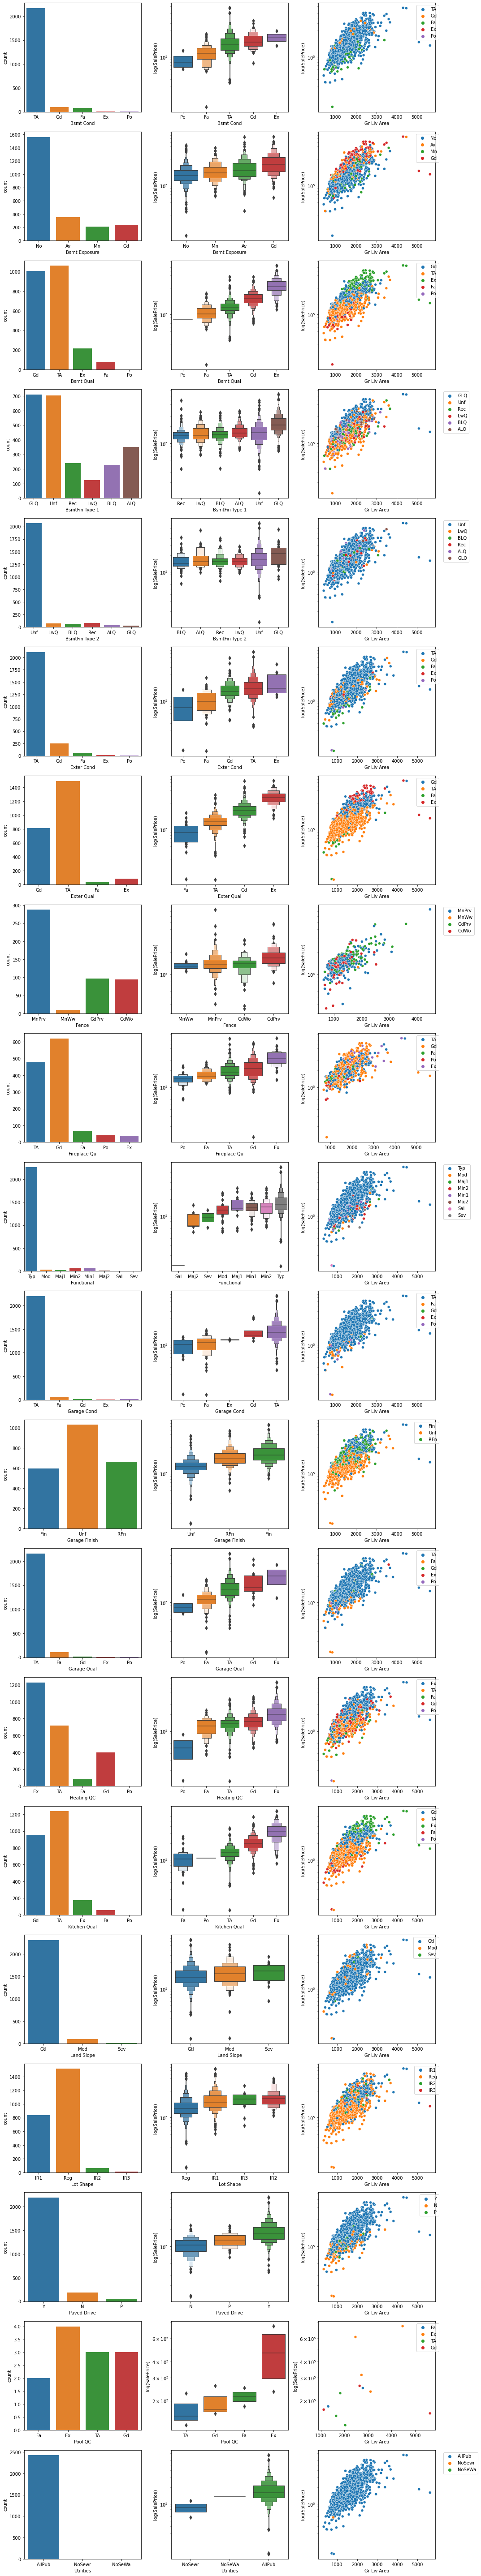

In [99]:
fig, ax = plt.subplots(nrows=len(ordinal), ncols=3, figsize=(15, 80))


for row in range(0,len(ordinal)):
       
    sns.countplot(x=ordinal[row],data=data_df, ax=ax[row,0])
 
    order_list = data_df.groupby(ordinal[row])['SalePrice'].median().sort_values(ascending=True).index
    sns.boxenplot(x=ordinal[row], y='SalePrice', order=order_list, data=data_df, ax=ax[row,1])
    ax[row,1].set_yscale('log')
    ax[row,1].set_ylabel('log(SalePrice)')
    
    sns.scatterplot(x='Gr Liv Area', y='SalePrice', data=data_df, hue=ordinal[row], ax=ax[row,2])
    ax[row,2].set_yscale('log')
    ax[row,2].set_ylabel('log(SalePrice)')
    ax[row,2].legend(bbox_to_anchor=(1.05, 1))


plt.tight_layout()
plt.show()

---
    Most of the dwelllings:
        * have basements in a typical condition, with no exposure in a good or typical quality with good living quarters or unfinished Type 1 and unfinished type 2
        * have a typical external quality
        * no fence
        * a typical home functionality
        * excellent or typical quality of heating and kitchen
        * have a gentle slope on the land
        * have a regular or IR1 type of lot shape
        * have paved drive
        * no Pool
        * all public utilities

    There is an exponential increase of the SalePrice with:
        * the condition, exposure, quality of the basement
        * external condition and quality
        * fireplace quality for about half the dwellings that they possess a fireplace
        * the interior finish of the garage
        * the quality of heating 
        * the quality of kitchen
        * the overall quality

---

---
### **Check unique values**
---

In [100]:
# Dictionaries that hold the unique values per feature as described in the documentation

dict_ordinal_docum = {'Bsmt Qual':      ['Ex','Gd','TA','Fa','Po','NA'],
                      'Bsmt Cond':      ['Ex','Gd','TA','Fa','Po','NA'],
                      'Bsmt Exposure':  ['Gd', 'Av','Mn','No','NA'],
                      'BsmtFin Type 1': ['GLQ', 'ALQ', 'BLQ','Rec','LwQ','Unf','NA'],
                      'BsmtFin Type 2': ['GLQ', 'ALQ', 'BLQ','Rec','LwQ','Unf','NA'],
                      'Exter Cond':     ['Ex','Gd','TA','Fa','Po'],
                      'Exter Qual':     ['Ex','Gd','TA','Fa','Po'],
                      'Fence':          ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
                      'Fireplace Qu':   ['Ex','Gd','TA','Fa','Po','NA'],
                      'Functional':     ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev','Sal'],
                      'Garage Cond':    ['Ex','Gd','TA','Fa','Po','NA'],
                      'Garage Finish':  ['Fin', 'RFn', 'Unf', 'NA'],
                      'Garage Qual':    ['Ex','Gd','TA','Fa','Po','NA'],
                      'Heating QC':     ['Ex','Gd','TA','Fa','Po'],
                      'Kitchen Qual':   ['Ex','Gd','TA','Fa','Po'],
                      'Land Slope':     ['Gtl', 'Mod', 'Sev'],
                      'Lot Shape':      ['Reg', 'IR1', 'IR2', 'IR3'],
                      'Paved Drive':    ['Y', 'P', 'N'],
                      'Pool QC':        ['Ex','Gd','TA','Fa','NA'],
                      'Utilities':      ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']}


In [101]:
# Function to read unique values from a dataframe and append it to a dictionary
def make_dict_from_df(df, col_list):
    
    df_dict = {}
    
    for col in col_list:
        df_dict[col] = sorted(df[col].dropna().unique(), key=str.lower)
        
    return  df_dict   

In [102]:
# Make the dictionary from the unique values of the dataframe
dict_ordinal_df = make_dict_from_df(data_df, ordinal)

In [103]:
# Function to compare two dictionaries. The one defined according to the documentation and one from the unique values of each feature in the dataframe
def dict_compare(dict1, dict2):
    
    for key, values in dict1.items():
        key_name = key
        ls_val = sorted(values, key=str.lower)

        up_dict = {key_name:ls_val}
        dict1.update(up_dict)

    diffkeys = [k for k in dict1 if dict1[k] != dict2[k]]
    
    for k in diffkeys:
        print('docum[', k, ']:', dict1[k])
        print('dataf[', k, ']:', dict2[k], '\n')

In [104]:
dict_compare(dict_ordinal_docum, dict_ordinal_df)

docum[ Bsmt Qual ]: ['Ex', 'Fa', 'Gd', 'NA', 'Po', 'TA']
dataf[ Bsmt Qual ]: ['Ex', 'Fa', 'Gd', 'Po', 'TA'] 

docum[ Bsmt Cond ]: ['Ex', 'Fa', 'Gd', 'NA', 'Po', 'TA']
dataf[ Bsmt Cond ]: ['Ex', 'Fa', 'Gd', 'Po', 'TA'] 

docum[ Bsmt Exposure ]: ['Av', 'Gd', 'Mn', 'NA', 'No']
dataf[ Bsmt Exposure ]: ['Av', 'Gd', 'Mn', 'No'] 

docum[ BsmtFin Type 1 ]: ['ALQ', 'BLQ', 'GLQ', 'LwQ', 'NA', 'Rec', 'Unf']
dataf[ BsmtFin Type 1 ]: ['ALQ', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf'] 

docum[ BsmtFin Type 2 ]: ['ALQ', 'BLQ', 'GLQ', 'LwQ', 'NA', 'Rec', 'Unf']
dataf[ BsmtFin Type 2 ]: ['ALQ', 'BLQ', 'GLQ', 'LwQ', 'Rec', 'Unf'] 

docum[ Exter Qual ]: ['Ex', 'Fa', 'Gd', 'Po', 'TA']
dataf[ Exter Qual ]: ['Ex', 'Fa', 'Gd', 'TA'] 

docum[ Fence ]: ['GdPrv', 'GdWo', 'MnPrv', 'MnWw', 'NA']
dataf[ Fence ]: ['GdPrv', 'GdWo', 'MnPrv', 'MnWw'] 

docum[ Fireplace Qu ]: ['Ex', 'Fa', 'Gd', 'NA', 'Po', 'TA']
dataf[ Fireplace Qu ]: ['Ex', 'Fa', 'Gd', 'Po', 'TA'] 

docum[ Garage Cond ]: ['Ex', 'Fa', 'Gd', 'NA', 'Po', 'TA']
d

---
    For the ordinal features we do not have incosistencies that need correction. The differences with respect to the documentation are either 'NA' values that do not exist in the dataframe or missing values. For the Utilities, there is no residential with only electricity in the dataset 'ELO'
---    


---
## **Experimentation**
---

### **Ordinal encoding**
---

In [105]:
class OrdinalPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, all_dummies=False ):
        self.columns = []
        self.mapping1 = {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.cols_for_mapping1 = ['Bsmt Qual', 'Bsmt Cond', 'Exter Qual', 'Exter Cond', 'Fireplace Qu', 'Garage Cond', 
                                  'Garage Qual', 'Pool QC','Heating QC', 'Kitchen Qual', ]
        self.mapping2 = {'NA':0, 'No':1, 'Mn':2, 'Av': 3, 'Gd': 4}
        self.cols_for_mapping2 = ['Bsmt Exposure']
        self.mapping3 = {'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
        self.cols_for_mapping3 = ['BsmtFin Type 1', 'BsmtFin Type 2']
        self.mapping4 = {'NA':0, 'Unf':1, 'RFn': 2, 'Fin': 3}
        self.cols_for_mapping4 = ['Garage Finish']
        self.mapping5 = {'IR3':1, 'IR2':2, 'IR1': 3, 'Reg': 4}
        self.cols_for_mapping5 = ['Lot Shape']
        self.mapping6 = {'Sev':1, 'Mod':2, 'Gtl': 3}
        self.cols_for_mapping6 = ['Land Slope']        
        self.cols_for_dummies = ['Fence', 'Utilities', 'Functional', 'Paved Drive']
        self.all_dummies = all_dummies
        

    def preprocess_f(self, X_df):
        # Work on a copy
        X_df = X_df.copy()

        if self.all_dummies==False:
            
            # For mapping 1
            for col in self.cols_for_mapping1:
                if col in X_df.columns:
                    X_df[col] = X_df[col].map(self.mapping1)
                    
            # For mapping 2
            for col in self.cols_for_mapping2:
                if col in X_df.columns:
                    X_df[col] = X_df[col].map(self.mapping2)    

            # For mapping 3
            for col in self.cols_for_mapping3:
                if col in X_df.columns:
                    X_df[col] = X_df[col].map(self.mapping3)  
                    
            # For mapping 4
            for col in self.cols_for_mapping4:
                if col in X_df.columns:
                    X_df[col] = X_df[col].map(self.mapping4) 
                    
            # For mapping 5
            for col in self.cols_for_mapping5:
                if col in X_df.columns:
                    X_df[col] = X_df[col].map(self.mapping5)  
                    
            # For mapping 6
            for col in self.cols_for_mapping6:
                if col in X_df.columns:
                    X_df[col] = X_df[col].map(self.mapping6)                     
                    
            # For dummies
            X_df = pd.get_dummies(X_df, columns=self.cols_for_dummies, dtype=np.int64)
                
        else:
            all_ordinal_columns = self.cols_for_mapping1 + self.cols_for_mapping2 + self.cols_for_mapping3 + self.cols_for_mapping4 + self.cols_for_dummies
            X_df = pd.get_dummies(X_df, columns=all_ordinal_columns, dtype=np.int64)
            

        return X_df
      
    

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame
        
        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df) 

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self  

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        # Save columns names/order for inference time
        self.columns = X_reindexed.columns        

        return X_reindexed
    
    def get_features_name(self): 
        return self.columns    

Outliers detected: 3 (0.2%)


test_size  baseline_mae ($)  train_mae ($)  test_mae ($)  train_R2  test_R2
0         50         56,673.57      11,126.69     13,851.42      0.96     0.85

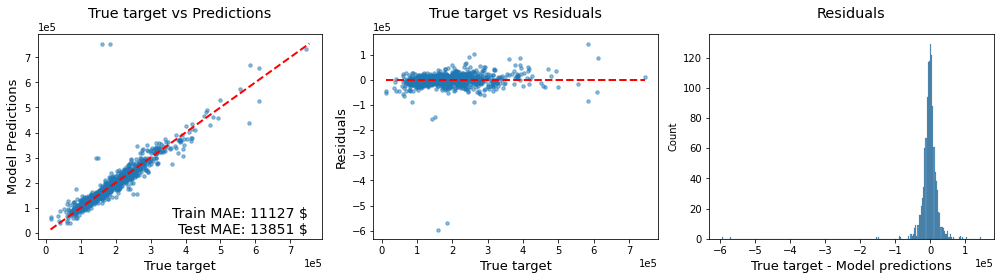

In [106]:
X = data_df.drop(['PID', 'Order', 'SalePrice'], axis=1)
y = data_df['SalePrice'] 

cols_for_poly = ['Lot Frontage', 'BsmtFin SF 1', '1st Flr SF', '2nd Flr SF','Gr Liv Area', 'Garage Area', 'Open Porch SF']

# Define Preprocessing steps
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
    ('ordinal_preprocessor', OrdinalPreprocessor()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)), 
    #('add_binary' , AddBinaryFeatures(has_MasVnrArea=True, has_Garage=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    #('descrete_to_dummies', DummiesPreprocessorForDescrete(only_dummy_for_SubClass=True)), 
   #('add_date_sold', AddDateSold(drop_month_year_columns=False)),
    ('scaler', StandardScaler())
])


# Define the model
model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)

# Fit the model and get metrics from predictions
pd.options.display.float_format = '{:,.2f}'.format
ord1 = fit_pipe(X, y, model)

---
## **Summary from PART 1**
---

---

    Having now all the features together and other than doing all the necessary steps like replacing nulls, correcting inconcistencies, encoding the ordinal variables and converting the nominal to dummies, the following preprocessing steps seem to improve the results of the ridge model and will be kept as part of the preprocessing procedure in Part 2:
        1) merge Condition 1 & 2 and Exterior 1st & 2nd before encoding to dummies
        2) add 2nd degree features for 'Lot Frontage', 'BsmtFin SF 1', '1st Flr SF', '2nd Flr SF','Gr Liv Area', 'Garage Area', 'Open Porch SF'
        3) add log transformations for all continuous features
        4) add 2 indicator variables
        
    Also the MS SubClass to dummies was giving a bit better test MAE at 13684$ in the above test, but it turned out with the grid search that the results were better without this conversion.   
   
---

<h1><center><font color="blue"><b>PART 2</b></font></center></h1>

---
# <font color="blue">**F. Define functions to extract results from models**</font>
---

### **Function to fit the models and perform a Grid Search except the linear model**
---

In [107]:
def fit_model(X, y, pipe, alpha_min=-2, alpha_max=4, alpha_num=20, runs=10, X_test=[], linear_model=False):

    # Dictionary to store the results
    gs_results = []

    # Split train/test sets into different sizes
    for test_size in np.arange(0.2,0.6, 0.1):

        # For each train/set size run different random splitting
        for run_idx in range(runs):

            # Split sets        
            X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=test_size, random_state=run_idx)

            # Vector with predictions from the baseline
            pred_baseline = np.full_like(y_tr, fill_value=np.median(y_tr), dtype=np.float)

            
            if linear_model==True:
                
                pipe.fit(X_tr, y_tr)
                    
                # Save model and its performance on train/test sets
                gs_results.append({
                    'model': model,
                    'test_size': test_size,
                    'run_idx': run_idx,
                    'baseline_mae': MAE(y_tr, pred_baseline),
                    'train_rmse': MSE(y_tr, pipe.predict(X_tr), squared=False),
                    'train_mae': MAE(y_tr, pipe.predict(X_tr)),
                    'val_rmse': MSE(y_val, pipe.predict(X_val), squared=False),
                    'val_mae': MAE(y_val, pipe.predict(X_val)),
                    'r2_train': pipe.score(X_tr, y_tr),
                    'r2_val': pipe.score(X_val, y_val),
                    'y_val':y_val,
                    'y_val_predict': pipe.predict(X_val),
                    'y_test_predict':pipe.predict(X_test)
                })   
            
            else:                   
                
                
                # Grid search fe
                for alpha in np.logspace(alpha_min, alpha_max, num=alpha_num):
                    
                    # Set alpha
                    pipe.set_params(regressor__withoutoutliersregressor__regressor__alpha=alpha)              
        
                    #Fit model
                    pipe.fit(X_tr, y_tr)

                    # Save model and its performance on train/test sets
                    gs_results.append({
                        'model': model,
                        'alpha': alpha,
                        'test_size': test_size,
                        'run_idx': run_idx,
                        'baseline_mae': MAE(y_tr, pred_baseline),
                        'train_rmse': MSE(y_tr, pipe.predict(X_tr), squared=False),
                        'train_mae': MAE(y_tr, pipe.predict(X_tr)),
                        'val_rmse': MSE(y_val, pipe.predict(X_val), squared=False),
                        'val_mae': MAE(y_val, pipe.predict(X_val)),
                        'r2_train': pipe.score(X_tr, y_tr),
                        'r2_val': pipe.score(X_val, y_val),
                        'y_val':y_val,
                        'y_val_predict': pipe.predict(X_val),
                        'y_test_predict':pipe.predict(X_test)                   

                    })    
                                    

    gs_results = pd.DataFrame(gs_results)    
    return gs_results

---
### **Function to extract best results from grid search or just sumup for the linear model**
---

In [108]:
pd.options.display.float_format = '{:,.2f}'.format

# Group results by alpha value
def get_best_results(df, plot_validation=False, linear_model=False):
    
    results=[]
    
    for test_size in np.arange(0.2,0.6, 0.1):
        
        if linear_model==True:
            
            lr_group = df.loc[df['test_size']==test_size]    
            
            results.append({
                'test_size': int(test_size*100),
                'mae_baseline_mean': lr_group.baseline_mae.mean(),
                'mae_train_mean': lr_group.train_mae.mean(),
                'mae_train_std': lr_group.train_mae.std(),
                'mae_val_mean': lr_group.val_mae.mean(),
                'mae_val_std': lr_group.val_mae.std(),
                'r2_train_mean': lr_group.r2_train.mean(),
                'r2_train_std': lr_group.r2_train.std(),
                'r2_val_mean': lr_group.r2_val.mean(),
                'r2_val_std': lr_group.r2_val.std(),
            })
            
        else:

            gb_alpha = df.loc[df['test_size']==test_size].groupby('alpha')

            # Compute train/test mean scores with std
            mean_tr = gb_alpha.train_rmse.mean()
            std_tr = gb_alpha.train_rmse.std()

            mean_vl = gb_alpha.val_rmse.mean()
            std_vl = gb_alpha.val_rmse.std()

            alphas = mean_tr.index.values

            mean_r2_tr = gb_alpha.r2_train.mean()
            std_r2_tr = gb_alpha.r2_train.std()

            mean_r2_vl = gb_alpha.r2_val.mean()
            std_r2_vl = gb_alpha.r2_val.std()        

            # Get entry with the best mean validation RMSE
            best_alpha = mean_vl.idxmin(axis=1)
            best_alpha_r2 = mean_r2_vl.idxmax(axis=1)
            best_result = gb_alpha.get_group(best_alpha)


            results.append({
                'test_size': int(test_size*100),
                'best_alpha': best_alpha,
                'mae_baseline_mean': best_result.baseline_mae.mean(),
                'mae_train_mean': best_result.train_mae.mean(),
                'mae_train_std': best_result.train_mae.std(),
                'mae_val_mean': best_result.val_mae.mean(),
                'mae_val_std': best_result.val_mae.std(),
                'r2_train_mean': best_result.r2_train.mean(),
                'r2_train_std': best_result.r2_train.std(),
                'r2_val_mean': best_result.r2_val.mean(),
                'r2_val_std': best_result.r2_val.std(),
            })


            if (plot_validation==True):

                print('Validation size:',int(test_size*100))
                print('best alpha:', best_alpha)          

                fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

                # Plot mean scores
                ax[0].semilogx(alphas, mean_tr, label='train')
                ax[0].semilogx(alphas, mean_vl, label='validation')

                # Quantify variance with ±std curves
                ax[0].fill_between(alphas, mean_tr-std_tr, mean_tr+std_tr, alpha=0.2)
                ax[0].fill_between(alphas, mean_vl-std_vl, mean_vl+std_vl, alpha=0.2)

                # Add marker for best score
                ax[0].scatter(best_alpha, mean_vl.min(), marker='x', c='red', zorder=10)
                ax[0].set_title('Validation curves with {} runs'.format(len(df.groupby('run_idx'))))
                ax[0].set_xlabel('$alpha$')
                ax[0].set_ylabel('RMSE')
                ax[0].legend()


                ax[1].semilogx(alphas, mean_r2_tr, label='train')
                ax[1].semilogx(alphas, mean_r2_vl, label='validation')
                ax[1].fill_between(alphas, mean_r2_tr-std_r2_tr, mean_r2_tr+std_r2_tr, alpha=0.2)
                ax[1].fill_between(alphas, mean_r2_vl-std_r2_vl, mean_r2_vl+std_r2_vl, alpha=0.2)            
                ax[1].set_title('Validation curves with {} runs'.format(len(df.groupby('run_idx'))))
                ax[1].scatter(best_alpha_r2, mean_r2_vl.max(), marker='x', c='red', zorder=10)            
                ax[1].set_xlabel('$alpha$')
                ax[1].set_ylabel('R^2')
                ax[1].legend()


                plt.tight_layout()
                plt.show()        
 
    results = pd.DataFrame(results)  

    return results

---
### **Function to plot the predicted as a function of true values**
---

In [109]:
def plot_predicted_true_target(df, linear_model=False, plot=True, get_y_best_results=False):
    
    df_vals = []
    
    for test_size in np.arange(0.2,0.6, 0.1):
        
        if linear_model==False:

            # For each test size group by alpha values
            gb_alpha = df.loc[df['test_size']==test_size].groupby('alpha')

            # Get mean of the test mse
            mean_te = gb_alpha.val_rmse.mean()
            mean_test_mae = gb_alpha.val_mae.mean()
            mean_r2_score_tr = gb_alpha.r2_train.mean()
            mean_r2_score_te = gb_alpha.r2_val.mean()

            # Get entry with the best mean test MSE
            best_alpha = mean_te.idxmin(axis=1)
            best_result = gb_alpha.get_group(best_alpha)

            # Loc the dataframe for the best alpha and the specific test size
            df_loc = df.loc[(df['alpha']==best_alpha) & (df['test_size']==test_size)]

            # the columns y_test and y_predict have a list per entry which corresponds to a different run_idx
            df_yval_true = pd.DataFrame(df_loc['y_val'].tolist())        
            df_yval_predict = pd.DataFrame(df_loc['y_val_predict'].tolist())
            df_ytest_predict = pd.DataFrame(df_loc['y_test_predict'].tolist())

            df_yval_true = df_yval_true.T
            df_yval_true['mean'] = df_yval_true.mean(axis=1)

            df_yval_predict = df_yval_predict.T
            df_yval_predict['mean'] = df_yval_predict.mean(axis=1)
            
            df_ytest_predict = df_ytest_predict.T
            df_ytest_predict['mean'] = df_ytest_predict.mean(axis=1)            


            df_vals.append({
                'test_size':test_size,
                'test_mae_mean':best_result.val_mae.mean(),
                'test_mae_std':best_result.val_mae.std(),
                'r2_score_mean':best_result.r2_val.mean(),
                'r2_score_std':best_result.r2_val.std(),
                'yval_true_mean':df_yval_true['mean'].to_list(),
                'yval_predict_mean':df_yval_predict['mean'].to_list(),
                'ytest_predict':df_ytest_predict['mean'].to_list()
            })
            
        else:      
            
            df_loc = df.loc[df['test_size']==test_size]
            
            # the columns y_test and y_predict have a list per entry which corresponds to a different run_idx
            df_yval_true = pd.DataFrame(df_loc['y_val'].tolist())        
            df_yval_predict = pd.DataFrame(df_loc['y_val_predict'].tolist())
            df_ytest_predict = pd.DataFrame(df_loc['y_test_predict'].tolist())

            df_yval_true = df_yval_true.T
            df_yval_true['mean'] = df_yval_true.mean(axis=1)

            df_yval_predict = df_yval_predict.T
            df_yval_predict['mean'] = df_yval_predict.mean(axis=1)
            
            df_ytest_predict = df_ytest_predict.T
            df_ytest_predict['mean'] = df_ytest_predict.mean(axis=1)            


            df_vals.append({
                'test_size':test_size,
                'test_mae_mean':df_loc.val_mae.mean(),
                'test_mae_std':df_loc.val_mae.std(),
                'r2_score_mean':df_loc.r2_val.mean(),
                'r2_score_std':df_loc.r2_val.std(),
                'yval_true_mean':df_yval_true['mean'].to_list(),
                'yval_predict_mean':df_yval_predict['mean'].to_list(),
                'ytest_predict':df_ytest_predict['mean'].to_list()
            })         
            
                
    # Results to dataframe                 
    df_vals = pd.DataFrame(df_vals)

    if plot==True:

        fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))
        plt.rcParams["axes.edgecolor"] = "black"
        plt.rcParams["axes.linewidth"] = 1

        col=0
        for test_size in np.arange(0.2,0.6, 0.1):



            df_loc = df_vals.loc[df_vals['test_size']==test_size]

            y_val_true = np.array(df_loc['yval_true_mean'].to_list())
            y_val_predict = np.array(df_loc['yval_predict_mean'].to_list())
            y_diff = np.subtract(y_val_true, y_val_predict)

            ############## Predicted as a function of true values #################
            ax[0,col].scatter(y_val_true,y_val_predict, s=12)
            ax[0,col].text(0.95, 0.01, r"$R^2$=%.2f$\pm$ %.2f,""\n"r"MAE=%.0f$\$$ $\pm$ %0.f" % (df_loc.r2_score_mean, df_loc.r2_score_std, df_loc.test_mae_mean, df_loc.test_mae_std),
                        verticalalignment='bottom', horizontalalignment='right',
                        transform=ax[0,col].transAxes,
                        fontsize=14)  
            ax[0,col].plot([df_yval_true['mean'].min(), df_yval_true['mean'].max()], [df_yval_predict['mean'].min(), df_yval_predict['mean'].max()], "--r")
            ax[0,col].set_ylabel("Predicted values", fontsize=13)
            ax[0,col].set_xlabel("True values", fontsize=13)
            ax[0,col].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
            ax[0,col].set_title(r'Validation size=%0.f'%(int(test_size*100)), fontsize='x-large')

            ############### Residuals as a function of target value #######################
            ax[1,col].scatter(y_val_true, y_diff[0], s=12)
            ax[1,col].plot([df_yval_true['mean'].min(), df_yval_true['mean'].max()], [0,0], "--r")
            ax[1,col].set_ylabel("Residuals", fontsize=13)
            ax[1,col].set_xlabel("True values", fontsize=13)
            ax[1,col].ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
            ax[1,col].set_title(r'Validation size=%0.f'%(int(test_size*100)), fontsize='x-large')      
            
            ############### Histogram for residuals  #######################
            sns.histplot(y_diff[0], ax=ax[2,col])
            ax[2,col].set_xlabel("residuals", fontsize=13)
            ax[2,col].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
            ax[2,col].set_title(r'Validation size=%0.f'%(int(test_size*100)), fontsize='x-large')              

            col = col+1            


        plt.tight_layout()
        plt.show()   
    
    if get_y_best_results==True:    
        return df_vals
         

---
### **Function to plot coefficients after fitting a model** 
---

In [110]:
def plot_coefs(feature_names=[], coefs=[], s1=20, s2=9, X_tr_std=[], title='', plot=False):
    # taken from: https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html
    
    # Coefs for each features
    coefs = pd.DataFrame( coefs*X_tr_std, columns=['Coefficient importance'], index=feature_names)
    
    if plot==True:
        coefs.plot(kind='bar', figsize=(s1, s2))
        plt.title(title)
        plt.axvline(x=0, color=".5")
        plt.subplots_adjust(left=0.3)   
        
    return coefs

---
### **Function to plot MAE for different train-test splits** 
---

In [111]:
def plot_mae_different_splittings(df, ylim1=10000, ylim2=16000):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

    ax[0].plot(100-df['test_size'], df['mae_train_mean'], 'o')
    ax[0].errorbar(100-df['test_size'], df['mae_train_mean'], yerr=df['mae_train_std'], fmt=' ', ecolor='black')
    ax[0].set_xlabel('training size', fontsize=14)
    ax[0].set_ylabel('MAE ($)', fontsize=14)
    ax[0].set_title('Training set', fontsize=15)
    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].set_xticks(np.arange(50, 90, 10))
    ax[0].set_ylim(ylim1,ylim2)

    ax[1].plot(df['test_size'], df['mae_val_mean'], 'o')
    ax[1].errorbar(df['test_size'], df['mae_val_mean'], yerr=df['mae_val_std'], fmt=' ', ecolor='black')
    ax[1].set_xlabel('validation size', fontsize=14)
    ax[1].set_ylabel('MAE ($)', fontsize=14)
    ax[1].set_title('Validation set', fontsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].set_xticks(np.arange(20, 60, 10))
    ax[1].set_ylim(ylim1,ylim2)

    plt.tight_layout()
    plt.show()


---
# <font color="blue">**G. Complex model with all variables**</font>
---

---
### **Re-define preprocessing steps & Load training-validation and test data**
---

In [112]:
# Load data for training and validation
X = data_df.drop(['Order', 'PID', 'SalePrice'], axis=1)
y = data_df['SalePrice'].values

# Load unseen data
test_df = pd.read_csv('house-prices-test.csv')
X_test = test_df.drop(['Order', 'PID'], axis=1)


# Columns for poly features
cols_for_poly = ['Lot Frontage', 'BsmtFin SF 1', '1st Flr SF', '2nd Flr SF','Gr Liv Area', 'Garage Area', 'Open Porch SF']

# Define Preprocessing steps
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
    ('ordinal_preprocessor', OrdinalPreprocessor()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    ('scaler', StandardScaler())
])

# Check final number of features for the complex model
X_pre = preprocessor.fit_transform(X)
print('Final number of features for the complex model:', X_pre.shape[1])

Final number of features for the complex model: 254


---
### **1. LinearRegression model**
---

---
#### **1.1 Define and run model**
---

In [113]:
## OLS model
from sklearn.linear_model import LinearRegression

## Define model with TransformedTargetRegressor fitting without outliers
linear_model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3, verbose=False),
                            regressor = LinearRegression()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)

In [114]:
# Fit model
linear_complex = fit_model(X, y, linear_model, runs=10, X_test=X_test, linear_model=True)

---
#### **1.2 Sum-up and plot results from different splittings**
---

test_size  mae_baseline_mean  mae_train_mean  mae_train_std  mae_val_mean  \
0         20          55,812.42       11,315.97         198.30     15,035.53   
1         30          55,968.09       11,356.77         365.19     15,433.22   
2         40          55,810.39       11,387.77         306.92     16,102.91   
3         50          56,116.35       11,069.67         243.76     16,681.85   

   mae_val_std  r2_train_mean  r2_train_std  r2_val_mean  r2_val_std  
0     1,276.87           0.95          0.01         0.77        0.15  
1     1,305.45           0.94          0.03         0.73        0.17  
2     1,431.06           0.92          0.03         0.70        0.13  
3       993.49           0.93          0.03         0.71        0.11

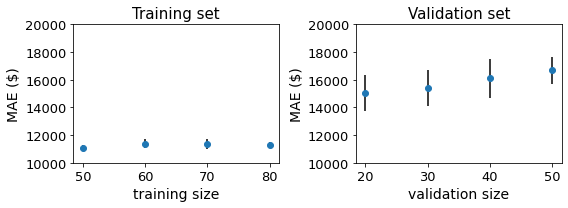

In [115]:
# Sum-up results 
linear_complex_results = get_best_results(linear_complex, linear_model=True)

# Display results
display(linear_complex_results)

# Plot best results
plot_mae_different_splittings(linear_complex_results, ylim1=10000, ylim2=20000)

---
    With the Linear Regression, we see that both the training and the validation MAE are quite lower than the baseline MAE. Even if the input matrix is not fully ranked (~218), the accuracy of the training MAE reaches ~0.9 and the errors in the MAE are of the same order of magnitude. For the validation set the accuracy reaches ~0.6-0.8 and the errors in the MAE are ~1 order of magnitude higher than the erros in the training set. We also see in the validation set that as the size of the set increases, the MAE also increases.
    
    
---

---
#### **1.3 Plot predicted values as a functions of the target values from validation sets**
---

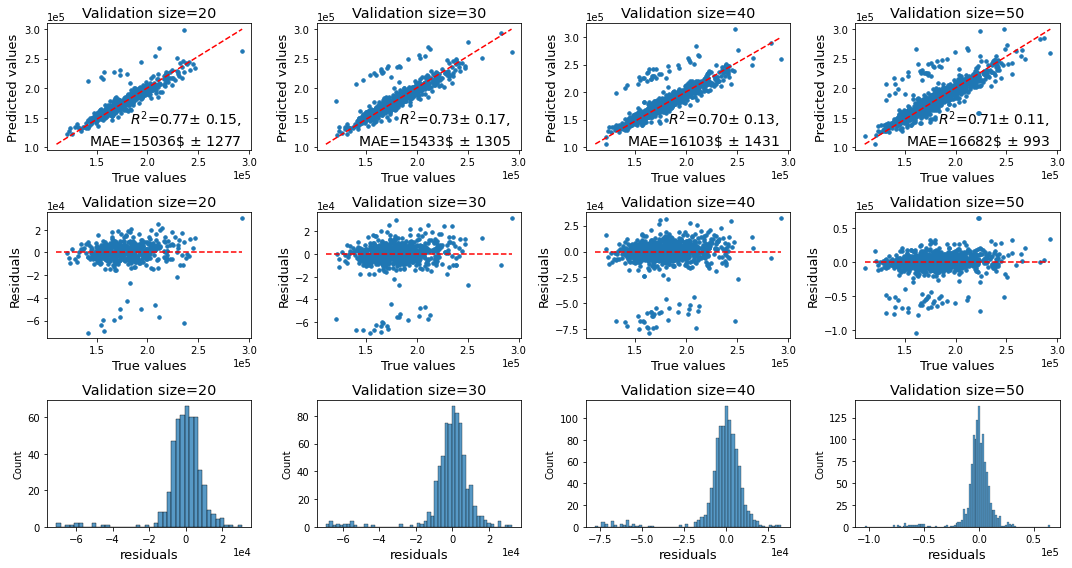

In [116]:
plot_predicted_true_target(linear_complex, linear_model=True)

---
    From the plots on the first row, we see that the accuracy of the model is not so bad as most of the predicted values are linearly correlated with the true values. We also see from the  plots in the 2nd row that most of the residuals as a function of the true values lie within the red dotted line which means that are well distributed around zero. This is also confirmed by the plots in the 3rd row as most of the residuals are Gaussian distributed with a mean of zero except those few points that are outside of the main distribution. 
---

---
### **2. Ridge model with Grid Search**
---

---
#### **2.1 Define and run model**
---

In [117]:
# Define model with TransformedTargetRegressor fitting without outliers
ridge_model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3, verbose=False),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)

In [118]:
# Run ridge model
ridge_complex = fit_model(X, y, ridge_model, alpha_min=-2, alpha_max=4, alpha_num=100, X_test=X_test, runs=10)

---
#### **2.2 Plot validation curves**
---

Validation size: 20
best alpha: 100.0


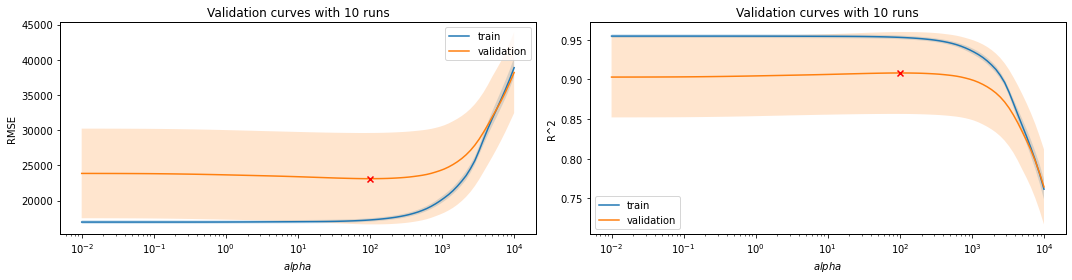

Validation size: 30
best alpha: 75.64633275546291


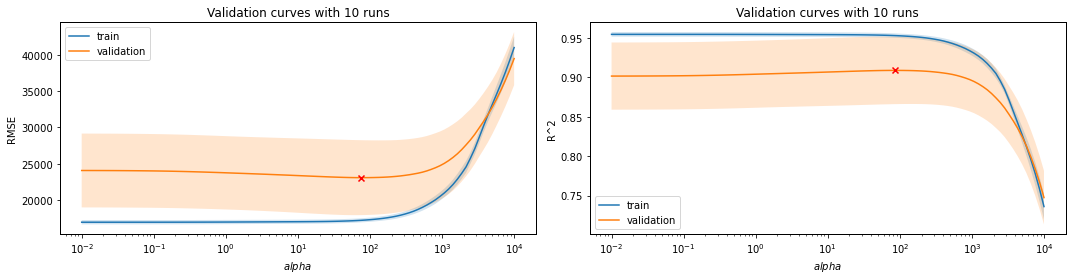

Validation size: 40
best alpha: 100.0


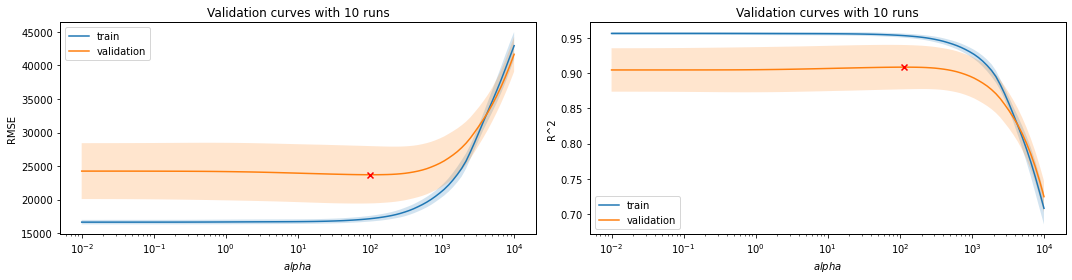

Validation size: 50
best alpha: 49.770235643321136


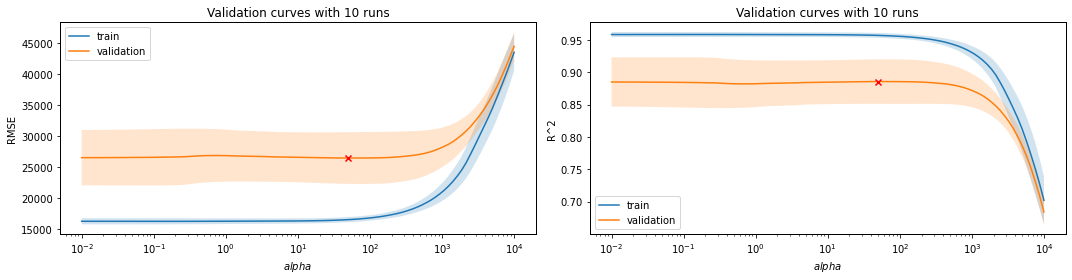

In [119]:
# Plot validation curves
ridge_complex_results = get_best_results(ridge_complex, plot_validation=True)

---
    From the validation curves of the ridge model, we see that there is not a real clear minimum for the best alpha parameter but it seems that the model starts to overfit below the best alpha values as the validation curves have a slight increase towards lower alpha values. The accuracy on the validation set is lower than on the training set across all different splittings. 
---

---
#### **2.3 Display best results and plot MAE for training and validation sets**
---

test_size  best_alpha  mae_baseline_mean  mae_train_mean  mae_train_std  \
0         20      100.00          55,812.42       11,456.36         137.35   
1         30       75.65          55,968.09       11,400.12         164.11   
2         40      100.00          55,810.39       11,389.84         172.12   
3         50       49.77          56,116.35       11,027.64         248.93   

   mae_val_mean  mae_val_std  r2_train_mean  r2_train_std  r2_val_mean  \
0     13,263.47       943.71           0.95          0.00         0.91   
1     13,271.79       715.91           0.95          0.00         0.91   
2     13,589.36       681.06           0.95          0.00         0.91   
3     14,115.61       488.90           0.96          0.00         0.89   

   r2_val_std  
0        0.05  
1        0.04  
2        0.03  
3        0.03

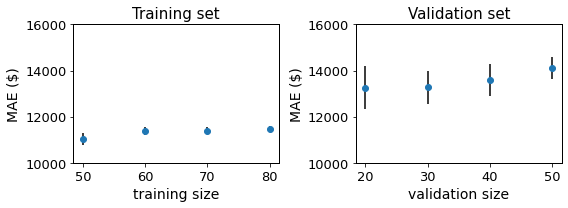

In [120]:
display(ridge_complex_results)

# Plot best results for training and validation
plot_mae_different_splittings(ridge_complex_results)

---
    With the ridge model, the accurace on the training set is 0.95 and on the validation set has reached 0.9 which is much better than the linear model. The MAE on the validation set has also decreased by ~1000$ across the different train-validation splits. 
---

---
#### **2.4 Plot predicted values as a functions of the target values from validation sets**
---

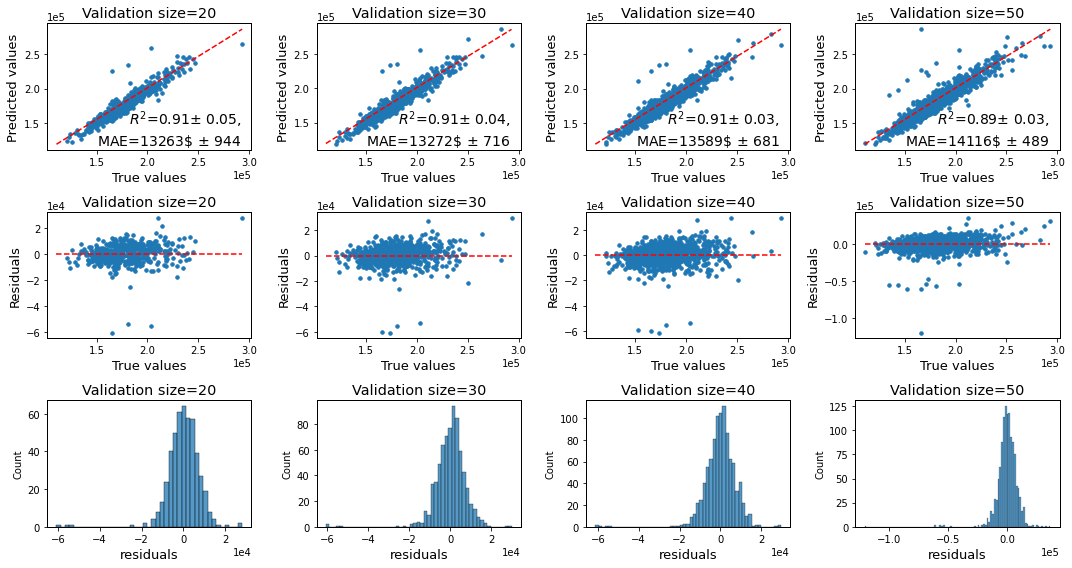

In [121]:
# Plot predicted vs true target
plot_predicted_true_target(ridge_complex)

---
    For the residuals, the data points that lie outside of the main Gaussian distribution are very few compared with the Linear model. The residuals are very well normally distributed around zero.  
---

---
### **Summary results for the complex model**
---

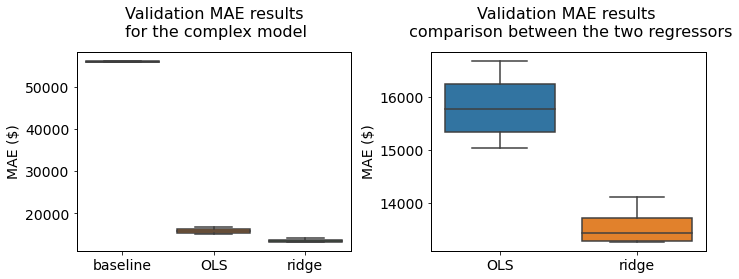

In [122]:
# Get results in a new dataframe
complex_all_results = pd.DataFrame()
complex_all_results['baseline'] = linear_complex_results['mae_baseline_mean']
complex_all_results['OLS'] = linear_complex_results['mae_val_mean']
complex_all_results['ridge'] = ridge_complex_results['mae_val_mean']

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(data = complex_all_results, ax=ax[0])
ax[0].set_ylabel('MAE ($)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Validation MAE results\n for the complex model', fontsize=16,  x=0.5, y=1.05)

sns.boxplot(data = complex_all_results[['OLS','ridge']], ax=ax[1])
ax[1].set_ylabel('MAE ($)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('Validation MAE results \n comparison between the two regressors', fontsize=16,  x=0.5, y=1.05)

plt.tight_layout()
plt.show()

---
    For the complex model, both linear and ridge regressor performed way better than the baseline with the ridge model reaching a better accuracy. 
---

---
### **Save predicted values for unseen data**
---

In [123]:
# Calculate weighted mean
def weighted_mean(mu, sigma):
    return ((mu/(sigma**2))/(1/(sigma**2)))

# Get df with best results
df_y_test = plot_predicted_true_target(ridge_complex, linear_model=False, plot=False, get_y_best_results=True)

# Create a new dataframe to store results
df_predictions_complex = pd.DataFrame()


# Get data from df_y_test into columns now
df_predictions_complex['test_size_20'] = df_y_test.loc[[0]]['ytest_predict'].to_list()[0]
df_predictions_complex['test_size_30'] = df_y_test.loc[[1]]['ytest_predict'].to_list()[0]
df_predictions_complex['test_size_40'] = df_y_test.loc[[2]]['ytest_predict'].to_list()[0]
df_predictions_complex['test_size_50'] = df_y_test.loc[[3]]['ytest_predict'].to_list()[0]

# Get mean across columns

######### Weighted mean -> is the same as the mean
#df_predictions_complex['SalePrice_mean'] = df_predictions_complex[['test_size_20', 'test_size_30', 'test_size_40', 'test_size_50']].mean(axis=1) 
#df_predictions_complex['SalePrice_std'] = df_predictions_complex[['test_size_20', 'test_size_30', 'test_size_40', 'test_size_50']].std(axis=1) 
#df_predictions_complex['SalePrice'] = weighted_mean(df_predictions_complex['SalePrice_mean'], df_predictions_complex['SalePrice_std'])

# Calculate the predictions Saleprice for the test set taking the mean over the different splittings
df_predictions_complex['SalePrice'] = df_predictions_complex.mean(axis=1) 

# Insert PID
df_predictions_complex['PID'] = test_df['PID'] 

# Drop unnecessary  columns
df_predictions_complex = df_predictions_complex.drop(['test_size_20', 'test_size_30', 'test_size_40', 'test_size_50'], axis=1)

# Swap columns
df_predictions_complex = df_predictions_complex.reindex(columns=['PID','SalePrice'])
df_predictions_complex.to_csv('predictions-complex-model.csv',sep=',', index=False)

---
# <font color="blue">**H. Intermediate Model 10-20 features**</font>
---

---
    To select features for the intermediate model I decided to use the SelectKBest with the score function 'f_regression' and 20 feautures. I tried to do a test with GridSearchCV to choose between this score function and the 'mutual_info_regression' as well as the number of feautures but it was failing. 
---

---
### **Define preprocessing steps and models with f_regression and mutual_info_regression**
---

In [124]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression,f_regression

## pipeline with f_regression
#preprocessor_f_test = Pipeline([
#    ('cleaning_continuous', CleaningPreprocessorContVars()),  
#    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
#    ('cleaning_nominal', CleaningPreprocessorNomVars()),
#    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
#    ('ordinal_preprocessor', OrdinalPreprocessor()),
#    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
#    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
#    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
#    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
#    ('add_indicator_vars', IndicatorVarPreprocessor()),
#    ('selector', SelectKBest(score_func=f_regression)),
#    ('scaler', StandardScaler()),
#])

## pipeline with mutual_info_regression
#preprocessor_mi_test = Pipeline([
#    ('cleaning_continuous', CleaningPreprocessorContVars()),  
#    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
#    ('cleaning_nominal', CleaningPreprocessorNomVars()),
#    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
#    ('ordinal_preprocessor', OrdinalPreprocessor()),
#    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
#    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
#    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
#    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
#    ('add_indicator_vars', IndicatorVarPreprocessor()),
#    ('selector', SelectKBest(score_func=mutual_info_regression)),
#    ('scaler', StandardScaler())
#])

## Define model with f_regression
#linear_model_ftest = TransformedTargetRegressor(
#            regressor = make_pipeline(preprocessor_f_test, LinearRegression()),
#            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
#)

## Define model with mutual_info_regression
#linear_model_mitest = TransformedTargetRegressor(
#            regressor = make_pipeline(preprocessor_mi_test, LinearRegression()),
#            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
#)

---
### **Define function to run GridSearchCV**
---

In [125]:
#from sklearn.model_selection import GridSearchCV

## Function to run GridSearchCV to get an idea of coefs
#def run_GridSearchCV(model):
    
#    num_of_feautures = [i for i in range(10,30)]
#    param_grid = {'regressor__pipeline__selector__k':num_of_feautures}

#    search = GridSearchCV(model, param_grid, 
#                          cv=None, 
#                          scoring='neg_mean_absolute_error')


#    for test_size in np.arange(0.2,0.6, 0.1):

#        X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=test_size, random_state=0)

#        _ = search.fit(X_tr, y_tr)

#        print('Test size:', int(test_size*100))
#        print('Best score:', abs(search.best_score_))
#        print('Best K:', search.best_params_, '\n')

---
### **Run GridSearchCV for with f_regression**
---

In [126]:
# Run f_test
#run_GridSearchCV(linear_model_ftest) ### RuntimeWarning: invalid value encountered in true_divide F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom

---
### **Run GridSearchCV for with mutual_info_regression**
---

In [127]:
# Run f_test
# run_GridSearchCV(linear_model_mitest)

---
### **Select features with SelectKBest and score functions f_regression**
---

In [128]:
X = data_df.drop(['Order', 'PID', 'SalePrice'], axis=1)
y = data_df['SalePrice'].values 
    
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
    ('ordinal_preprocessor', OrdinalPreprocessor()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
])

selected_columns = []
for test_size in np.arange(0.2,0.6, 0.1):
    
    # For each train/set size run different random splitting
    for run_idx in range(10):
        
        # Split sets
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=run_idx)    

        # preprocess X_tr
        X_tr_prep = preprocessor.fit_transform(X_tr, y_tr)

        # define selector
        selector = SelectKBest(score_func=f_regression, k=20)

        # fit selector
        selector.fit(X_tr_prep, y_tr)

        # Get columns
        cols = selector.get_support(indices=True)
        X_tr_prep_selected = X_tr_prep.iloc[:,cols]

        #print('test_size:{:,.2f}'.format(test_size), 'run_idx:', run_idx, '\nfeatures selected:', X_tr_prep_selected.columns.to_list()[0:5])
        
        selected_columns = selected_columns + X_tr_prep_selected.columns.to_list()
    #print('\n')

features_selected = list(set(selected_columns))

In [129]:
print('Num of total feautures:', len(features_selected),'\n')

print('List of features:\n', features_selected)

Num of total feautures: 24 

List of features:
 ['Bsmt Qual', 'Full Bath', 'Overall Qual', 'Total Bsmt SF', 'Garage Finish', '1st Flr SF^2', 'Years_since_remodeled', 'Garage Area^2', 'Fireplace Qu', 'Mas Vnr Area', 'Gr Liv Area_log', 'Garage Cars', 'Year Built', 'Recently_built', 'BsmtFin SF 1^2', 'Gr Liv Area^2', 'Exter Qual', 'Gr Liv Area', '1st Flr SF_log', 'Garage Area', '1st Flr SF', 'Years_since_built', 'Year Remod/Add', 'Kitchen Qual']


---
### **Create a custom transformer to take into account on the fit only the selected features**
---

In [130]:
class SelectFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns ):
        self.columns = columns
        

    def preprocess_f(self, X_df):
        # Work on a copy
        X_df = X_df.copy()

        return X_df[self.columns]
      
    

    def fit(self, X_df, y=None):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame
        
        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df) 

        # Save columns names/order for inference time
        self.columns = X_preprocessed.columns

        return self  

    def transform(self, X_df):
        # Check that we get a DataFrame
        assert type(X_df) == pd.DataFrame

        # Preprocess data
        X_preprocessed = self.preprocess_f(X_df)

        # Make sure to have the same features
        X_reindexed = X_preprocessed.reindex(columns=self.columns, fill_value=0)
        
        # Save columns names/order for inference time
        self.columns = X_reindexed.columns        

        return X_reindexed

---
### **Get indices for outliers after selecting features**
---

In [131]:
X = data_df.drop(['Order', 'PID', 'SalePrice'], axis=1)
y = data_df['SalePrice'].values 

preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
    ('ordinal_preprocessor', OrdinalPreprocessor()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    #('selector', SelectKBest(score_func=f_regression, k=20)), # Selector added
    ('select_features', SelectFeatures(features_selected)), # select known features with custom transformer
    #('scaler', StandardScaler())
])

X_selected = preprocessor.fit_transform(X)
print('Final columns of input matrix after selecting features:', X_selected.shape[1], '\n')

# Features to check for outliers
cols_for_outliers = ['Gr Liv Area','Garage Area'] # those are scaled anyway 
cols_for_outliers_indices = [X_selected.columns.get_loc(col) for col in cols_for_outliers] # Get indices of columns since the detector works with numpy arrays

print('Index\tFeature')
for col in X_selected.columns.to_list():
    print(X_selected.columns.get_loc(col),'\t', col)
    
print('\nIndices for outliers [Gr Liv Area, Garage Area]:', cols_for_outliers_indices)

Final columns of input matrix after selecting features: 24 

Index	Feature
0 	 Bsmt Qual
1 	 Full Bath
2 	 Overall Qual
3 	 Total Bsmt SF
4 	 Garage Finish
5 	 1st Flr SF^2
6 	 Years_since_remodeled
7 	 Garage Area^2
8 	 Fireplace Qu
9 	 Mas Vnr Area
10 	 Gr Liv Area_log
11 	 Garage Cars
12 	 Year Built
13 	 Recently_built
14 	 BsmtFin SF 1^2
15 	 Gr Liv Area^2
16 	 Exter Qual
17 	 Gr Liv Area
18 	 1st Flr SF_log
19 	 Garage Area
20 	 1st Flr SF
21 	 Years_since_built
22 	 Year Remod/Add
23 	 Kitchen Qual

Indices for outliers [Gr Liv Area, Garage Area]: [17, 19]


---
### **1. Linear model**
---

---
#### **1.1 Define model and run**
---

In [132]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression,f_regression

# Redefine preprocessor with the scaler
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
    ('ordinal_preprocessor', OrdinalPreprocessor()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    #('selector', SelectKBest(score_func=f_regression, k=20)), # Selector added
    ('select_features', SelectFeatures(features_selected)), # select known features with custom transformer
    ('scaler', StandardScaler())
])

In [133]:
# Define model
linear_model_intermediate = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3, verbose=False),
                            regressor = make_pipeline(
                                LinearRegression())
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)



In [134]:
# Run model
linear_intermediate = fit_model(X, y, linear_model_intermediate, X_test=X_test, runs=10, linear_model=True)

---
#### **1.2 Sum-up and plot best results**
---

test_size  mae_baseline_mean  mae_train_mean  mae_train_std  mae_val_mean  \
0         20          55,812.42       17,227.03         259.86     17,508.39   
1         30          55,968.09       17,380.39         308.43     17,218.76   
2         40          55,810.39       17,396.27         478.59     17,351.32   
3         50          56,116.35       17,346.85         551.55     17,403.50   

   mae_val_std  r2_train_mean  r2_train_std  r2_val_mean  r2_val_std  
0     1,079.79           0.85          0.01         0.86        0.05  
1       812.27           0.85          0.02         0.86        0.04  
2       803.03           0.84          0.02         0.87        0.03  
3       563.75           0.86          0.03         0.85        0.04

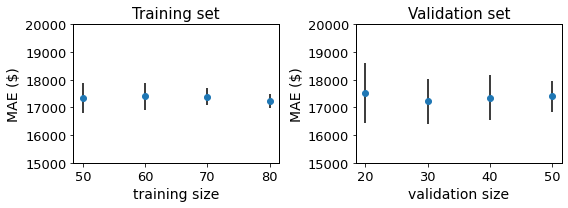

In [135]:
# Get best results
linear_intermediate_results = get_best_results(linear_intermediate, linear_model=True)

# Display results
display(linear_intermediate_results)

# Plot best results
plot_mae_different_splittings(linear_intermediate_results, ylim1=15000, ylim2=20000)

---
    For the intermediate model, the accuracy of the Linear regression between the training and the validation sets is about the same at ~0.85. The MAE is also more or less the same between the two sets but the errors on the validation set are much higher. 
---

---
#### **1.3 Plot predicted values and residuals as a functions of the target values from validation sets**
---

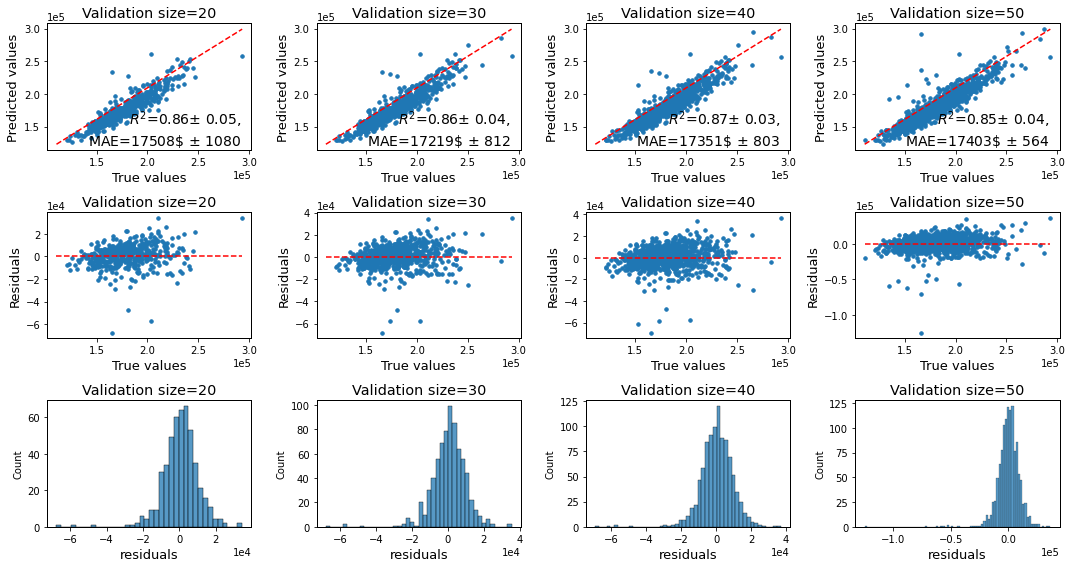

In [136]:
plot_predicted_true_target(linear_intermediate, linear_model=True)

---
    The residuals are normally distributed around zero with few data points outside of the main distribution. 
---

---
### **2. Ridge model with grid search**
---

---
#### **2.1 Run model**
---

In [137]:
# Define model
ridge_model_intermediate = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier(cols_for_outliers_indices, threshold=3, verbose=False),
                            regressor = Ridge()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)

# Fit model
ridge_intermediate = fit_model(X, y, ridge_model_intermediate, alpha_min=0, alpha_max=5, alpha_num=100, X_test=X_test, runs=10)

---
#### **2.2 Plot validation curves**
---

Validation size: 20
best alpha: 104.76157527896652


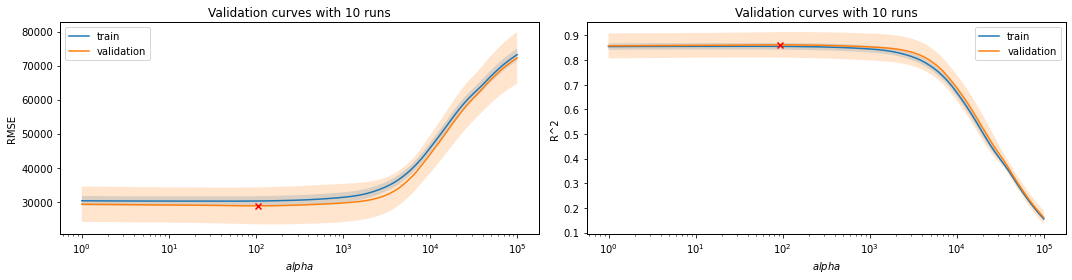

Validation size: 30
best alpha: 65.79332246575679


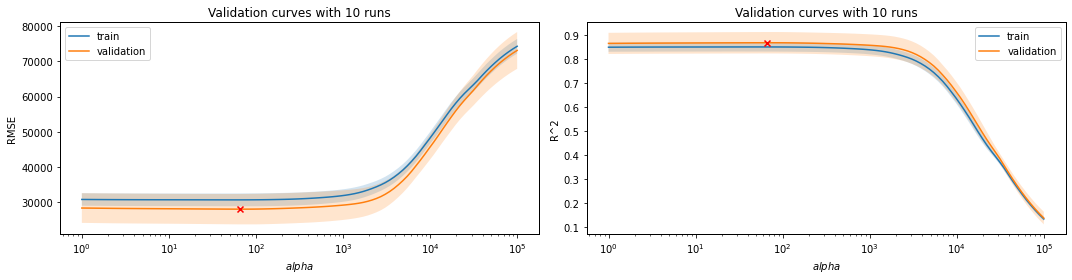

Validation size: 40
best alpha: 65.79332246575679


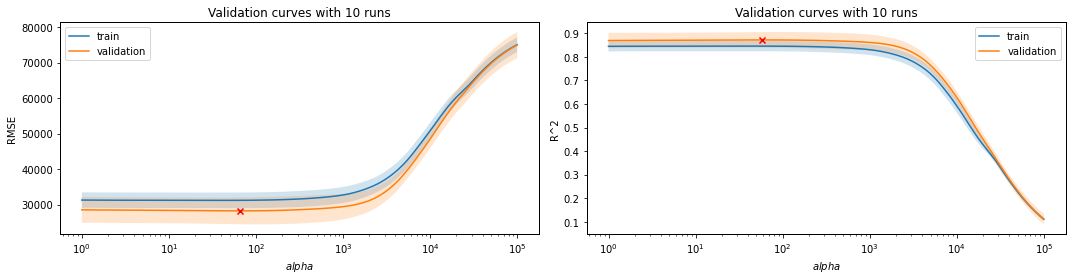

Validation size: 50
best alpha: 46.4158883361278


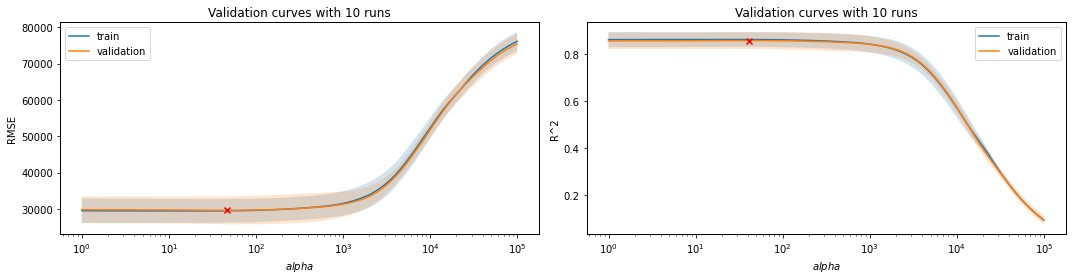

In [138]:
ridge_intermediate_results = get_best_results(ridge_intermediate, plot_validation=True)

---
    From the validation curves, we see that there is not a clear minimum for the alpha values and the model is overfitting. The validation curves on the left plots follow below the train RMSE values and the two curves are about the same for the 50-50 splitting. 
---

---
#### **2.3 Sum-up and plot best results**
---

test_size  best_alpha  mae_baseline_mean  mae_train_mean  mae_train_std  \
0         20      104.76          55,812.42       17,284.78         260.86   
1         30       65.79          55,968.09       17,393.59         324.53   
2         40       65.79          55,810.39       17,446.84         502.40   
3         50       46.42          56,116.35       17,360.69         535.37   

   mae_val_mean  mae_val_std  r2_train_mean  r2_train_std  r2_val_mean  \
0     17,395.67     1,113.91           0.86          0.01         0.86   
1     17,113.40       812.85           0.85          0.02         0.87   
2     17,274.40       786.54           0.85          0.02         0.87   
3     17,368.70       559.78           0.86          0.03         0.86   

   r2_val_std  
0        0.05  
1        0.04  
2        0.03  
3        0.04

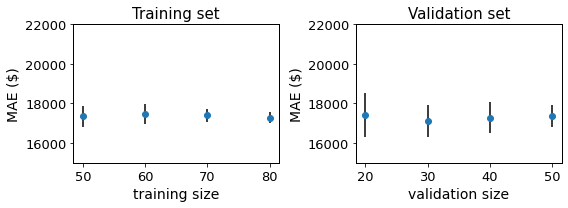

In [139]:
display(ridge_intermediate_results)

# Plot best results
plot_mae_different_splittings(ridge_intermediate_results, ylim1=15000, ylim2=22000)

---
    Also for the ridge model, the accuracy of the training and the validation set is about the same. The MAE between the two sets is also about the same with larger errors for the validation set. 
---

---
#### **2.4 Plot predicted values and residuals as a functions of the target values from validation sets**
---

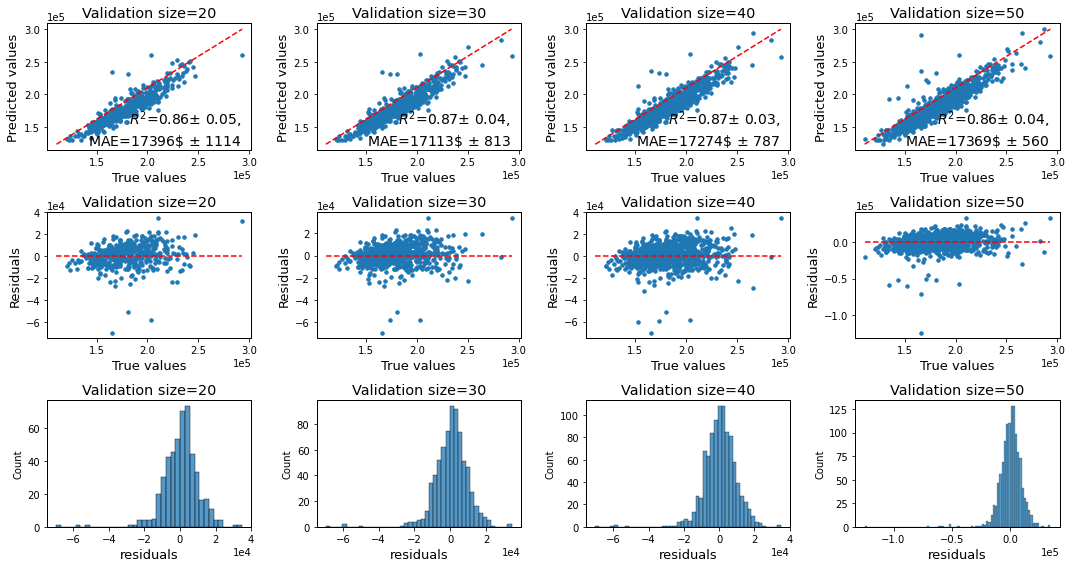

In [140]:
plot_predicted_true_target(ridge_intermediate)

---
    The residuals for the ridge model are also normally distributed around zero. 
---

---
### **Summary results for each intermediate model accross different test sets splitting**
---

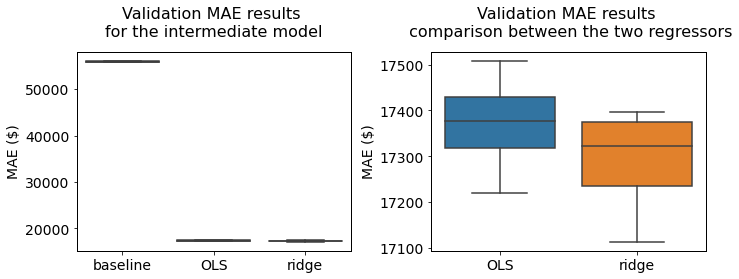

In [141]:
# Get results in a new dataframe
intermediate_all_results = pd.DataFrame()
intermediate_all_results['baseline'] = linear_intermediate_results['mae_baseline_mean']
intermediate_all_results['OLS'] = linear_intermediate_results['mae_val_mean']
intermediate_all_results['ridge'] = ridge_intermediate_results['mae_val_mean']
#intermediate_all_results['lasso'] = lasso_intermediate_results['mae_val_mean']

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(data = intermediate_all_results, ax=ax[0])
ax[0].set_ylabel('MAE ($)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Validation MAE results \nfor the intermediate model', fontsize=16,  x=0.5, y=1.05)

sns.boxplot(data = intermediate_all_results[['OLS','ridge']], ax=ax[1])
ax[1].set_ylabel('MAE ($)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('Validation MAE results \n comparison between the two regressors', fontsize=16,  x=0.5, y=1.05)

plt.tight_layout()
plt.show()

---
    Both linear and ridge regressors perform way better than the baseline. Between the two of them, which as we saw above have reached the same accuracy on the training and validation sets, it seems that the results of the MAE for the linear model are better distributed across the different test splits. 
---

---
### **Save predicted values for unseen data**
---

In [142]:
# Get df with best results from the linear model
df_y_test_intermediate = plot_predicted_true_target(linear_intermediate, linear_model=True, plot=False, get_y_best_results=True)

#display(df_y_test)

# Create a new dataframe to store results
df_predictions_intermediate = pd.DataFrame()

# Get data from df_y_test into columns now
df_predictions_intermediate['test_size_20'] = df_y_test_intermediate.loc[[0]]['ytest_predict'].to_list()[0]
df_predictions_intermediate['test_size_30'] = df_y_test_intermediate.loc[[1]]['ytest_predict'].to_list()[0]
df_predictions_intermediate['test_size_40'] = df_y_test_intermediate.loc[[2]]['ytest_predict'].to_list()[0]
df_predictions_intermediate['test_size_50'] = df_y_test_intermediate.loc[[3]]['ytest_predict'].to_list()[0]

# Get mean across columns
df_predictions_intermediate['SalePrice'] = df_predictions_intermediate.mean(axis=1) 

# Insert PID
df_predictions_intermediate['PID'] = test_df['PID'] 

# Drop unnecessary  columns
df_predictions_intermediate = df_predictions_intermediate.drop(['test_size_20', 'test_size_30', 'test_size_40', 'test_size_50'], axis=1)

# Swap columns
df_predictions_intermediate = df_predictions_intermediate.reindex(columns=['PID','SalePrice'])
df_predictions_intermediate.to_csv('predictions-intermediate-model.csv',sep=',', index=False)

---
---
# <font color="blue">**I. Simple Model with 2 features**</font>
---
---

---
### **Check features that will be selected by f_regression**
---

In [143]:
X = data_df.drop(['Order', 'PID', 'SalePrice'], axis=1)
y = data_df['SalePrice'].values 
    
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
    ('ordinal_preprocessor', OrdinalPreprocessor()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor())
])

selected_columns = []
for test_size in np.arange(0.2,0.6, 0.1):
    
    # For each train/set size run different random splitting
    for run_idx in range(10):
        
        # Split sets
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=run_idx)    

        # preprocess X_tr
        X_tr_prep = preprocessor.fit_transform(X_tr, y_tr)

        # define selector
        #selector = SelectKBest(score_func=mutual_info_regression, k=2) # more slow
        selector = SelectKBest(score_func=f_regression, k=2)

        # fit selector
        selector.fit(X_tr_prep, y_tr)

        # Get columns
        cols = selector.get_support(indices=True)
        X_tr_prep_selected = X_tr_prep.iloc[:,cols]

        #print('test_size:', test_size, 'run_idx:', run_idx, 'features selected:', X_tr_prep_selected.columns)
        selected_columns = selected_columns + X_tr_prep_selected.columns.to_list()
     #print('\n'))

In [163]:
print('Features selected:')
features_selected = list(set(selected_columns))
features_selected

Features selected:


['Exter Qual', 'Overall Qual', 'Gr Liv Area']

In [164]:
# Remove external quality
features_selected.remove('Exter Qual')
features_selected

['Overall Qual', 'Gr Liv Area']

---
### **1. Linear Regression**
---

---
#### **1.1 Define and run model**
---

In [165]:
# Re-define preprocessor with scaler
preprocessor = Pipeline([
    ('cleaning_continuous', CleaningPreprocessorContVars()),  
    ('cleaning_discrete', CleaningPreprocessorDescrVars()), 
    ('cleaning_nominal', CleaningPreprocessorNomVars()),
    ('cleaning_ordinal', CleaningPreprocessorOrdVars()),
    ('ordinal_preprocessor', OrdinalPreprocessor()),
    ('nominal_to_dummies', DummiesPreprocessorNominal(mergeConditions=True, mergeExterior=True, nomcolumns_=cols_nom_for_dummies)),
    ('cleaning_MSSubClass', CleaningPreprocessorNomVars(clean_MSSubClass=True)),
    ('add_poly_features' , AddPolyFeatures(cols_for_poly, only_degree=True)),  
    ('add_transformations', AddTransformations(cols_all=continuous, all_logs=True, extra_columns=True)),      
    ('add_indicator_vars', IndicatorVarPreprocessor()),
    #('selector', SelectKBest(score_func=f_regression, k=2)),
    ('select_features', SelectFeatures(features_selected)), # select features with custom transformer
    ('scaler', StandardScaler())
])


In [166]:
## Define model with TransformedTargetRegressor fitting without outliers
linear_model_simple = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier([0,1], threshold=3, verbose=False), 
                            regressor = LinearRegression()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)


In [167]:
linear_simple = fit_model(X, y, linear_model_simple, X_test=X_test, runs=10, linear_model=True)

---
#### **1.1 Sum-up and plot results**
---

test_size  mae_baseline_mean  mae_train_mean  mae_train_std  mae_val_mean  \
0         20          55,812.42       25,318.96         440.56     24,831.74   
1         30          55,968.09       25,491.62         553.27     24,697.62   
2         40          55,810.39       25,489.22         820.54     24,961.14   
3         50          56,116.35       25,405.36         852.43     25,161.70   

   mae_val_std  r2_train_mean  r2_train_std  r2_val_mean  r2_val_std  
0     1,728.88           0.75          0.01         0.77        0.06  
1     1,283.22           0.75          0.02         0.78        0.05  
2     1,228.18           0.74          0.03         0.78        0.04  
3       834.14           0.75          0.04         0.77        0.04

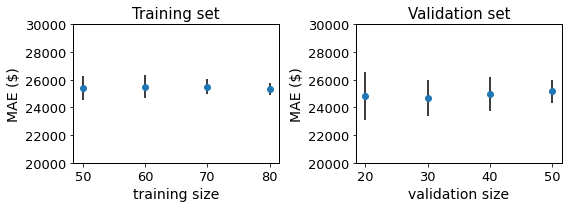

In [168]:
# Get best results
linear_simple_results = get_best_results(linear_simple, linear_model=True)

# Display results
display(linear_simple_results)

# Plot best results
plot_mae_different_splittings(linear_simple_results, ylim1=20000, ylim2=30000)

---
    For the simple model, the linear regression accuracy has reached ~0.75 for the training set and ~0.77 for the validation set. The validation mean MAE is a bit less than the training mean MAE but the errors are larger for the validation set. 
---

---
#### **1.2 Plot predicted values and residuals as a functions of the target values from validation sets**
---

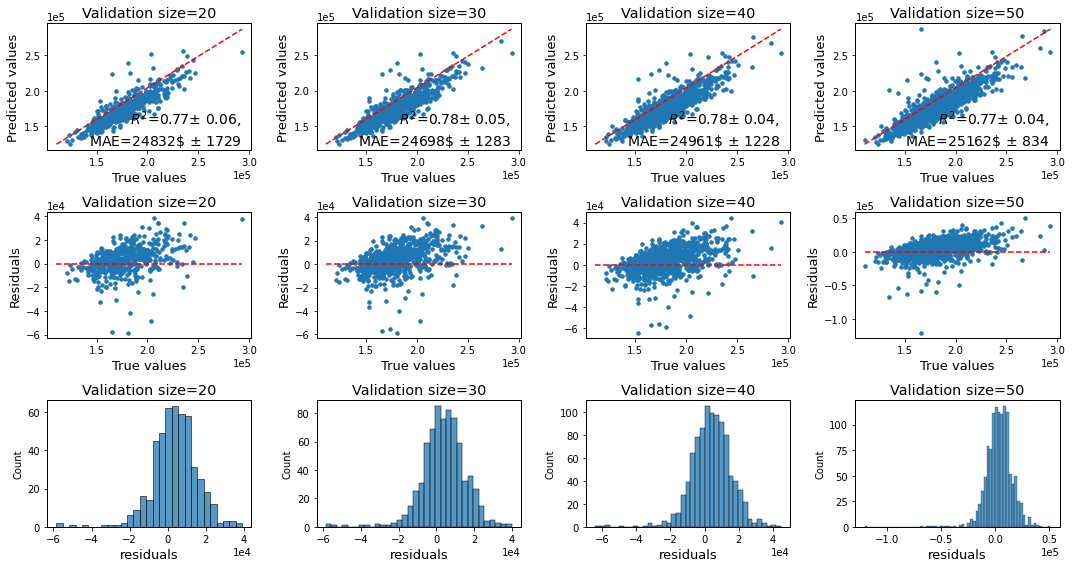

In [169]:
plot_predicted_true_target(linear_simple, linear_model=True)

---
    From the plots above, we see that:
    - the predictions of the linear model follow below the red dotted line (1st row plots)
    - the residuals are a bit tilted wrt the true values (2nd row plots)
    - the residuals are normally distributed but not well around zero (3rd row plots)
---

---
### **2. Hubber Regressor**
---

---
#### **2.1 Define and run model**
---

In [170]:
from sklearn.linear_model import HuberRegressor

huber_model = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, HuberRegressor()),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)

huber_model_no_outliers = TransformedTargetRegressor(
            regressor = make_pipeline(preprocessor, WithoutOutliersRegressor(
                            outlier_detector = ZScoresOutlierClassifier([0,1], threshold=3, verbose=False),
                            regressor = HuberRegressor()
            )),
            transformer = QuantileTransformer(output_distribution='normal', random_state=0, n_quantiles=100)
)


In [171]:
#huber_model.set_params(regressor__huberregressor__epsilon=1.35) # default one, not much improvement with other trials

# Fit huber with outliers
huber_simple = fit_model(X, y, huber_model, X_test=X_test, runs=10, linear_model=True)

In [172]:
# Fit huber without outliers
huber_simple_no_outliers = fit_model(X, y, huber_model_no_outliers, X_test=X_test, runs=10, linear_model=True)

---
#### **2.2 Sum-up and plot best results**
---

##### **With outliers**
---

test_size  mae_baseline_mean  mae_train_mean  mae_train_std  mae_val_mean  \
0         20          55,812.42       25,198.95         414.10     24,810.32   
1         30          55,968.09       25,345.26         519.97     24,533.94   
2         40          55,810.39       25,344.00         766.10     24,758.14   
3         50          56,116.35       25,234.67         790.24     24,934.11   

   mae_val_std  r2_train_mean  r2_train_std  r2_val_mean  r2_val_std  
0     1,804.82           0.75          0.01         0.77        0.06  
1     1,337.49           0.75          0.02         0.78        0.05  
2     1,269.73           0.74          0.03         0.78        0.04  
3       902.02           0.76          0.04         0.77        0.04

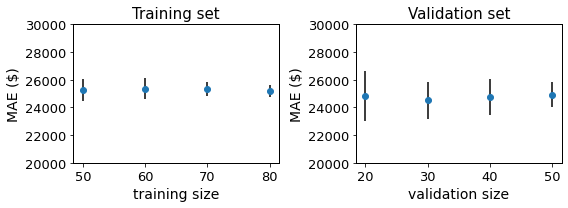

In [173]:
# Get best results
huber_simple_results = get_best_results(huber_simple, linear_model=True)

# Display results
display(huber_simple_results)

# Plot best results
plot_mae_different_splittings(huber_simple_results, ylim1=20000, ylim2=30000)

---
##### **Without outliers**
---

test_size  mae_baseline_mean  mae_train_mean  mae_train_std  mae_val_mean  \
0         20          55,812.42       25,191.48         417.07     24,787.56   
1         30          55,968.09       25,336.54         523.53     24,514.67   
2         40          55,810.39       25,328.77         767.07     24,740.19   
3         50          56,116.35       25,219.54         795.07     24,916.63   

   mae_val_std  r2_train_mean  r2_train_std  r2_val_mean  r2_val_std  
0     1,791.14           0.75          0.01         0.77        0.06  
1     1,333.69           0.75          0.02         0.78        0.05  
2     1,267.63           0.74          0.03         0.78        0.04  
3       894.55           0.76          0.04         0.77        0.04

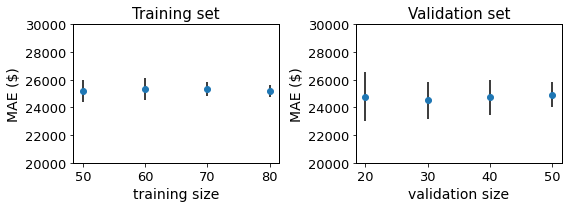

In [174]:
# Get best results
huber_simple_results_no_outliers = get_best_results(huber_simple_no_outliers, linear_model=True)

# Display results
display(huber_simple_results_no_outliers)

# Plot best results
plot_mae_different_splittings(huber_simple_results_no_outliers, ylim1=20000, ylim2=30000)

---
    The huber model without the outliers gave slightly better results as we see also from the following plot. The accurary of both is about the same also as with the linear regression model. 
---

---
##### **Compare the results with and without outliers**
---

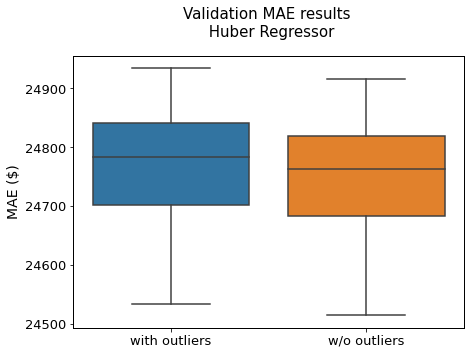

In [175]:
huber_all_results = pd.DataFrame()

huber_all_results['with outliers'] = huber_simple_results['mae_val_mean']
huber_all_results['w/o outliers'] = huber_simple_results_no_outliers['mae_val_mean']

plt.figure(figsize=(7,5))
sns.boxplot(data = huber_all_results)
plt.ylabel('MAE ($)', fontsize=14)
#plt.xlabel('models', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('Validation MAE results \n Huber Regressor', fontsize=15,  x=0.5, y=1.05)
plt.show()

---
#### **2.3 Plot predicted values and residuals as a functions of the target values from validation sets**
---

##### **With outliers**
---

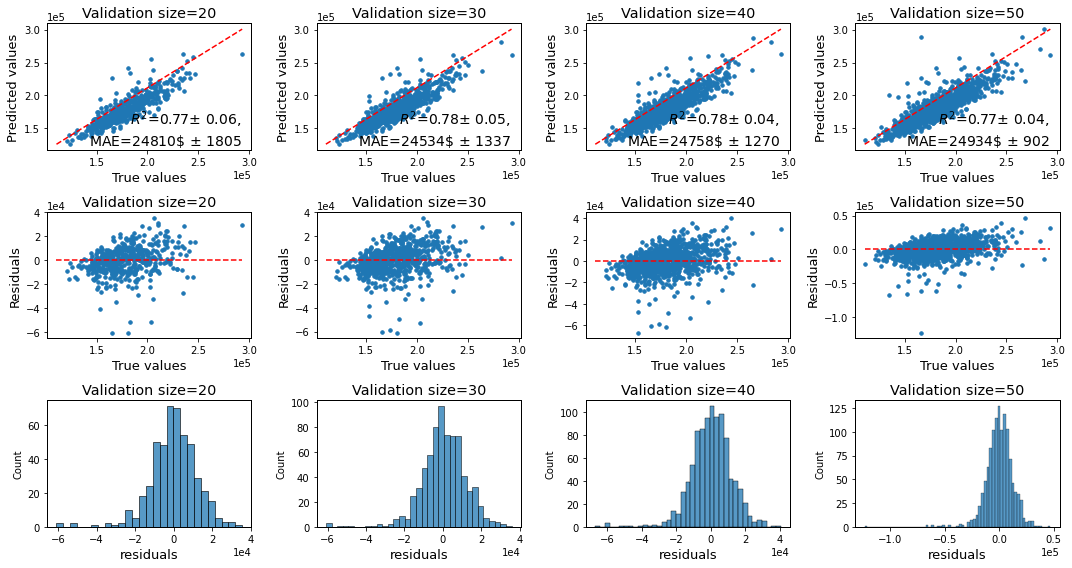

In [176]:
plot_predicted_true_target(huber_simple, linear_model=True)

---
#### **Without outliers**
---

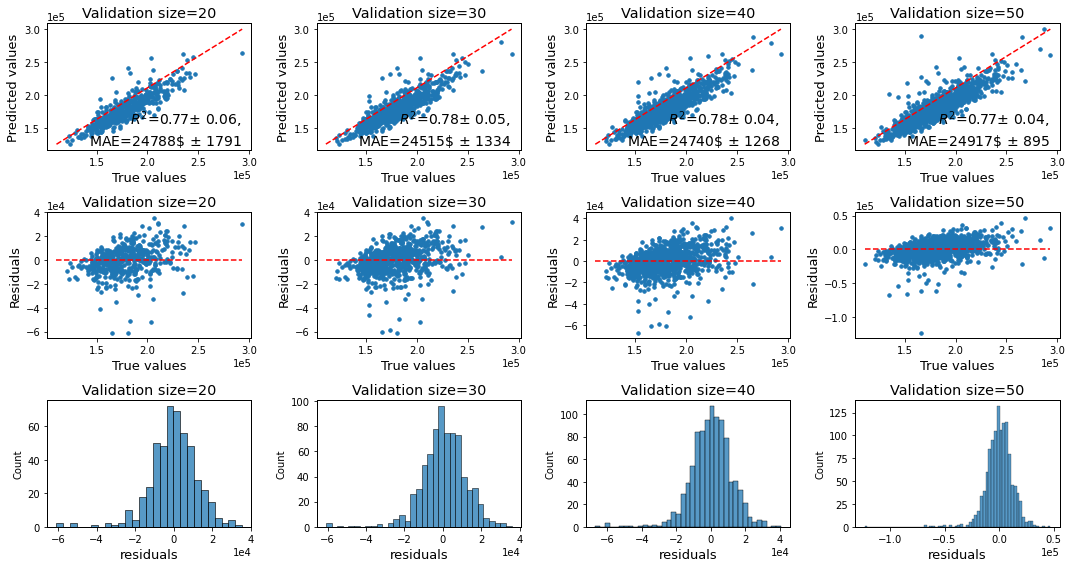

In [177]:
plot_predicted_true_target(huber_simple_no_outliers, linear_model=True)

---
    The residuals between the true and the predicted values are well centered around zero in contrast with the linear model.  
---    

---
### **Summary results for each simple model accross different test sets splitting**
---

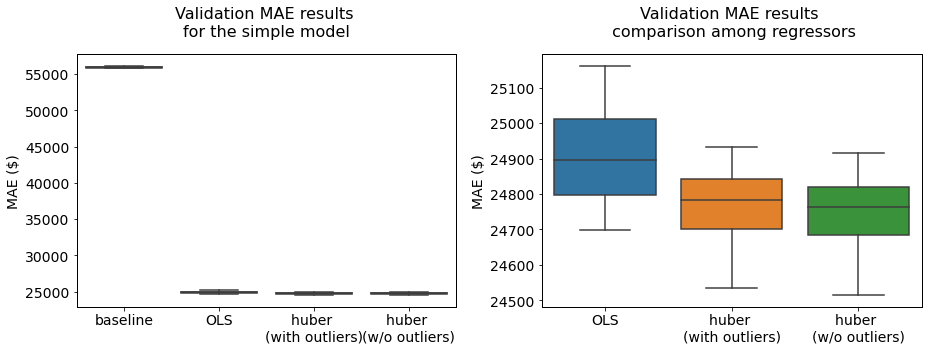

In [178]:
# Get results in a new dataframe
simple_all_results = pd.DataFrame()
simple_all_results['baseline'] = linear_simple_results['mae_baseline_mean']
simple_all_results['OLS'] = linear_simple_results['mae_val_mean']
simple_all_results['huber \n(with outliers)'] = huber_simple_results['mae_val_mean']
simple_all_results['huber \n(w/o outliers)'] = huber_simple_results_no_outliers['mae_val_mean']

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.boxplot(data = simple_all_results, ax=ax[0])
ax[0].set_ylabel('MAE ($)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Validation MAE results \nfor the simple model', fontsize=16,  x=0.5, y=1.05)

sns.boxplot(data = simple_all_results.iloc[:,1:], ax=ax[1])
ax[1].set_ylabel('MAE ($)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('Validation MAE results \n comparison among regressors', fontsize=16,  x=0.5, y=1.05)

plt.tight_layout()
plt.show()



---
    All the tested models perform way better than the baseline. The Huber model though have reached better MAE results for the validation sets.
---

---
### **Save predicted values for unseen data**
---

In [179]:
# Get df with best results
df_y_test_simple = plot_predicted_true_target(huber_simple_no_outliers, linear_model=True, plot=False, get_y_best_results=True)

# Create a new dataframe to store results
df_predictions_simple = pd.DataFrame()

# Get data from df_y_test into columns now
df_predictions_simple['test_size_20'] = df_y_test_simple.loc[[0]]['ytest_predict'].to_list()[0]
df_predictions_simple['test_size_30'] = df_y_test_simple.loc[[1]]['ytest_predict'].to_list()[0]
df_predictions_simple['test_size_40'] = df_y_test_simple.loc[[2]]['ytest_predict'].to_list()[0]
df_predictions_simple['test_size_50'] = df_y_test_simple.loc[[3]]['ytest_predict'].to_list()[0]

# Get mean across columns
df_predictions_simple['SalePrice'] = df_predictions_simple.mean(axis=1) 

# Insert PID
df_predictions_simple['PID'] = test_df['PID'] 

# Drop unnecessary  columns
df_predictions_simple = df_predictions_simple.drop(['test_size_20', 'test_size_30', 'test_size_40', 'test_size_50'], axis=1)

# Swap columns
df_predictions_simple = df_predictions_simple.reindex(columns=['PID','SalePrice'])
df_predictions_simple.to_csv('predictions-simple-model.csv',sep=',', index=False)


---
---
# <font color="blue">**J. Final Comparison**</font>


    The final comparison for the simple, intermediate and complex models are presented below in a boxplot and in a table. For each case the regression model with the best results was chosen.
---
---

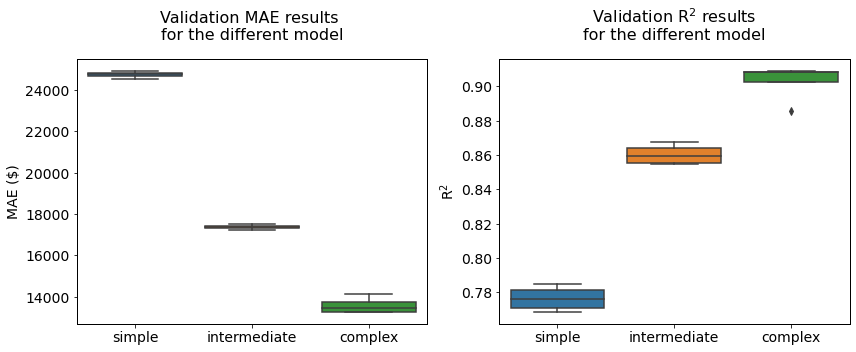

In [180]:
# Dataframe with MAE results for different models
df_final_mae = pd.DataFrame()
df_final_mae['simple'] = huber_simple_results_no_outliers['mae_val_mean']
df_final_mae['intermediate'] = linear_intermediate_results['mae_val_mean']
df_final_mae['complex'] = ridge_complex_results['mae_val_mean']

# Dataframe with R2 results for different models
df_final_r2 = pd.DataFrame()
df_final_r2['simple'] = huber_simple_results_no_outliers['r2_val_mean']
df_final_r2['intermediate'] = linear_intermediate_results['r2_val_mean']
df_final_r2['complex'] = ridge_complex_results['r2_val_mean']

# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.boxplot(data = df_final_mae, ax=ax[0])
ax[0].set_ylabel('MAE ($)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_title('Validation MAE results \nfor the different model', fontsize=16,  x=0.5, y=1.05)

sns.boxplot(data = df_final_r2, ax=ax[1])
ax[1].set_ylabel('R$^2$', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_title('Validation R$^2$ results \nfor the different model', fontsize=16,  x=0.5, y=1.05)

plt.tight_layout()
plt.show()


---
    As we see from the results on the validation set:
    
        - the complex model has an accuracy of ~0.9 with a MAE of ~13600$ on average
        
        - the intermediate has an accuracy of ~0.87 with a MAE of ~17370$ on average
        
        - the simple model has an accuracy of ~0.77 with a MAE of ~24700$ on average
    
---

In [181]:
# Present all results together

df_summary_stats = pd.DataFrame()
df_summary_stats['simple_mae_mean'] = huber_simple_results_no_outliers['mae_val_mean']
df_summary_stats['simple_mae_std'] = huber_simple_results_no_outliers['mae_val_std']
df_summary_stats['simple_r2_mean'] = huber_simple_results_no_outliers['r2_val_mean']
df_summary_stats['simple_r2_std'] = huber_simple_results_no_outliers['r2_val_std']


df_summary_stats['interm_mae_mean'] = linear_intermediate_results['mae_val_mean']
df_summary_stats['interm_mae_std'] = linear_intermediate_results['mae_val_std']
df_summary_stats['interm_r2_mean'] = linear_intermediate_results['r2_val_mean']
df_summary_stats['interm_r2_std'] = linear_intermediate_results['r2_val_std']

df_summary_stats['complex_mae_mean'] = ridge_complex_results['mae_val_mean']
df_summary_stats['complex_mae_std'] = ridge_complex_results['mae_val_std']
df_summary_stats['complex_r2_mean'] = ridge_complex_results['r2_val_mean']
df_summary_stats['complex_r2_std'] = ridge_complex_results['r2_val_std']

df_summary_stats = df_summary_stats.to_numpy()

row_levels = [['20', '30', '40', '50']]
row_labels = [[0,1,2,3]]
row_indices = pd.MultiIndex(row_levels, row_labels)

col_levels = [['Simple','Intermediate', 'Complex'], ['s_MAE_mean ($)', 's_MAE_std ($)','s_R$^2$_mean', 's_R$^2$_std',
                                                     'i_MAE_mean ($)', 'i_MAE_std ($)','i_R$^2$_mean', 'i_R$^2$_std',
                                                     'c_MAE_mean ($)', 'c_MAE_std ($)','c_R$^2$_mean', 'c_R$^2$_std']]
col_labels = [[0,0,0,0,1,1,1,1,2,2,2,2],[0,1,2,3,4,5,6,7,8,9,10,11]]
col_indices = pd.MultiIndex(col_levels, col_labels)


df_summary_stats = pd.DataFrame(df_summary_stats, index=row_indices, columns=col_indices)
df_summary_stats

Simple                                          Intermediate  \
   s_MAE_mean ($) s_MAE_std ($) s_R$^2$_mean s_R$^2$_std i_MAE_mean ($)   
20      24,787.56      1,791.14         0.77        0.06      17,508.39   
30      24,514.67      1,333.69         0.78        0.05      17,218.76   
40      24,740.19      1,267.63         0.78        0.04      17,351.32   
50      24,916.63        894.55         0.77        0.04      17,403.50   

                                                 Complex                \
   i_MAE_std ($) i_R$^2$_mean i_R$^2$_std c_MAE_mean ($) c_MAE_std ($)   
20      1,079.79         0.86        0.05      13,263.47        943.71   
30        812.27         0.86        0.04      13,271.79        715.91   
40        803.03         0.87        0.03      13,589.36        681.06   
50        563.75         0.85        0.04      14,115.61        488.90   

                             
   c_R$^2$_mean c_R$^2$_std  
20         0.91        0.05  
30         0.91        0.04  
40         0.91        0.03  
50         0.89        0.03

---
### **Submission score results**
---

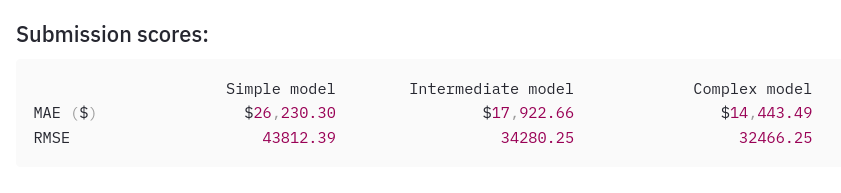

In [182]:
from IPython.display import Image
Image(filename='submission_scores.png')

---
    The predictions on the unseen data are a bit higher than the results obtained from the validation set. In particular:
    
        - for the complex model, the test MAE is ~880$ higher than the validation MAE
        
        - for the intermediate model, the MAE is ~550$ higher than the validation MAE
        
        - for the simple model, the MAE is ~1460$  higher than the validation MAE
---